# All MBD sites, MAF filtering 0.05, IMAGE  
count all CpG-SNPs in genome using maf > 0.05 SNPs from full dataset  [site](https://www.bioconductor.org/packages/release/bioc/vignettes/ramwas/inst/doc/RW2_CpG_sets.html)  
see how many CpGs are in cis/trans sites
Do MACAU  
* correct for cis-SNPs, trans-SNPs


In [1]:
INPUT = '../analyses/2bRAD/Inputs/'
mQTL = '../analyses/2bRAD/mQTL/'

In [2]:
#function to run bash commands cleanly
js <- function(shell_command){
    cat(system(shell_command, intern=TRUE), sep='\n')}

## Format genetic data

In [4]:
library(RNOmni)
library(MatrixEQTL)
library(tidyverse)
library(reshape2)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.0.4     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



In [6]:
geno <- read.table(paste0(INPUT,'MBD_HCSS_Afilt32m70_maf05_m2pop.geno'))

In [7]:
# less than 50% hets in full dataset
dim(geno)

[1] 2860   18

In [8]:
head(geno)

HC1.2 HC1.4 HC2.15 HC2.17 HC3.1 HC3.5 HC3.7 HC3.10 HC3.11 SS2.9
Contig0_109103 1     1     0      1      2     0     0     1      1      0    
Contig0_109119 0     0     0      0      2     0     0     0      1      0    
Contig0_109123 0     0     0      0      2     0     0     0      1      0    
Contig3_14914  0     0     0      0      0     0     0     1      0      0    
Contig4_51093  1     1     0      0      0     0     0     0      0      1    
Contig9_17749  1     0     0      0      0     1     0     0      0      1    
               SS2.14 SS2.18 SS3.3 SS3.14 SS3.15 SS3.16 SS3.20 SS5.18
Contig0_109103 0      0      0     2      0      1      0      2     
Contig0_109119 0      0      0     0      0      0      0      0     
Contig0_109123 0      0      0     0      0      0      0      0     
Contig3_14914  0      1      1     0      2      1      1      1     
Contig4_51093  0      0      0     0      0      0      0      0     
Contig9_17749  1      1      0     2      1      0      0      1

In [9]:
geno <- cbind(as.character(rownames(geno)),geno)
#colnames(geno) <- c("id",colnames(geno)[-1])
rownames(geno) <- NULL
# change sample names to match epigenetics
mbdorder = c("hc1_2","hc1_4","hc2_15","hc2_17","hc3_1","hc3_5","hc3_7","hc3_10","hc3_11",
        "ss2_9","ss2_14","ss2_18","ss3_3","ss3_14","ss3_15","ss3_16","ss3_20","ss5_18")
colnames(geno) <- c("id",mbdorder)
head(geno)
write.table(geno,paste0(mQTL,'MBD_HCSS_Afilt32m70_maf05_m2pop_format.tab'),sep="\t",quote = F,row.names = F)

id             hc1_2 hc1_4 hc2_15 hc2_17 hc3_1 hc3_5 hc3_7 hc3_10 hc3_11
1 Contig0_109103 1     1     0      1      2     0     0     1      1     
2 Contig0_109119 0     0     0      0      2     0     0     0      1     
3 Contig0_109123 0     0     0      0      2     0     0     0      1     
4 Contig3_14914  0     0     0      0      0     0     0     1      0     
5 Contig4_51093  1     1     0      0      0     0     0     0      0     
6 Contig9_17749  1     0     0      0      0     1     0     0      0     
  ss2_9 ss2_14 ss2_18 ss3_3 ss3_14 ss3_15 ss3_16 ss3_20 ss5_18
1 0     0      0      0     2      0      1      0      2     
2 0     0      0      0     0      0      0      0      0     
3 0     0      0      0     0      0      0      0      0     
4 0     0      1      1     0      2      1      1      1     
5 1     0      0      0     0      0      0      0      0     
6 1     1      1      0     2      1      0      0      1

In [10]:
geno %>% mutate_if(is.factor, as.character) -> geno

In [12]:
# get snp position file
geno <- as.data.frame(geno,stringsAsFactors = F)
chr = sapply(strsplit(geno$id,"_"), '[',1)
pos = sapply(strsplit(geno$id,"_"), '[',2)
snppos <- as.data.frame(cbind(geno$id,chr,pos),stringsAsFactors = F)
snppos$pos <- as.numeric(snppos$pos)
colnames(snppos) <- c('snp','chr','pos')
head(snppos)
write.table(snppos,file=paste(mQTL,"snppos_mqtl_05_m2pop.tab"),quote = F,row.names = F,sep = "\t")

snp            chr     pos   
1 Contig0_109103 Contig0 109103
2 Contig0_109119 Contig0 109119
3 Contig0_109123 Contig0 109123
4 Contig3_14914  Contig3  14914
5 Contig4_51093  Contig4  51093
6 Contig9_17749  Contig9  17749

In [29]:

bed <- cbind(chr,pos,pos, geno$id)
write.table(bed,file="{mQTL}snppos_mqtl_05_m2pop.BED",quote = F,row.names = F,col.names=F,sep = "\t")

# Looking at individual methylated sites

## Format methylation data

In [30]:
#?
module load gcc/6.2.0
module load xz/5.2.2 
module load bzip2/1.0.6
module load bedtools/2.29.0

In [16]:
# load methylation data

load("../analyses/methylation-filtered/R-objects/meth_filter_reshaped")

meth_filter_reshaped <- mutate(meth_filter_reshaped, site=paste(chr, start, end, sep="_"))
#add sample names
key = read.csv("../data/sample-key.csv",colClasses = c("character","character"))
samples = meth_filter_reshaped$sample
mapdf <- data.frame(old=key$MBD.FILENAME,new=key$SAMPLE)
meth_filter_reshaped$sample <- mapdf$new[match(samples,mapdf$old)]


`summarise()` regrouping output by 'site', 'sample', 'chr', 'start', 'end', 'population' (override with `.groups` argument)

Warning message:
“Removed 1 rows containing missing values (position_stack).”


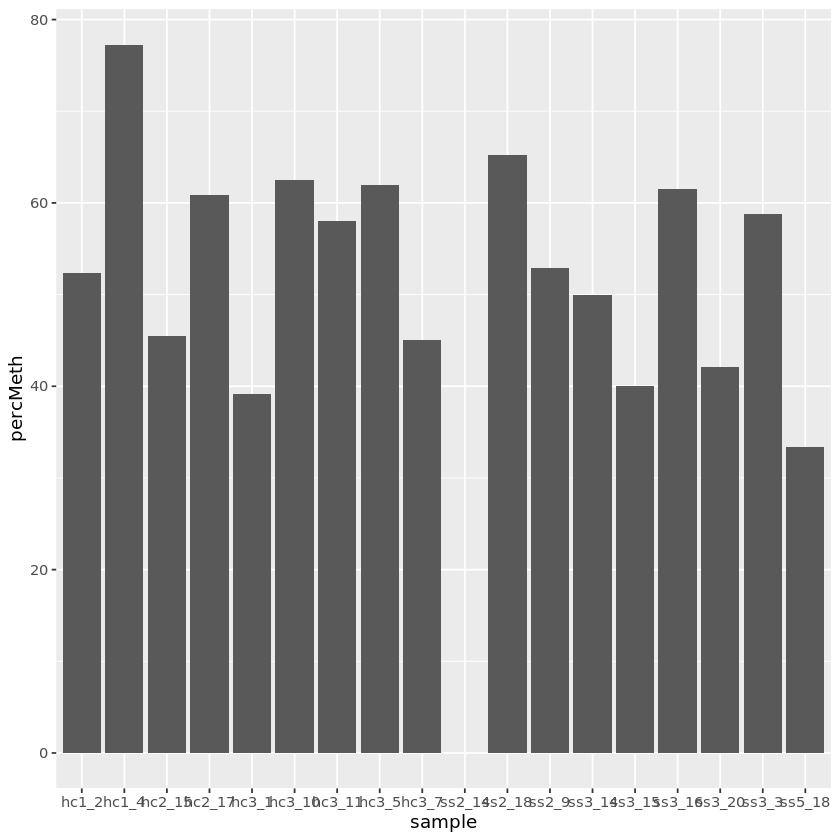

In [17]:
# Calculate % methylation for each bin
perc_meth <- meth_filter_reshaped %>% 
   group_by(site, sample, chr, start, end,population,percMeth) %>%
   dplyr::summarise(n())  

# check a couple loci to make sure % methylation is calculated separately for each sample and gene region 
perc_meth %>% filter(site=="Contig0_39226_39226") %>% ggplot(aes(x=sample, y=percMeth)) + geom_bar(stat="identity")

In [18]:

dc <- dcast(perc_meth,site~sample, value.var="percMeth")
colnames(dc) <- c("id",colnames(dc)[-1])
dc <- dc[,c("id",mbdorder)]
write.table(dc,paste0(mQTL,"meth_filter_allsites.tab"),sep="\t",row.names = F,quote = F)
head(dc)

id                  hc1_2     hc1_4     hc2_15    hc2_17    hc3_1    
1 Contig0_39226_39226  52.38095  77.27273  45.45455  60.86957  39.13043
2 Contig0_39234_39234  41.66667  25.92593  37.03704  19.23077  42.85714
3 Contig0_64179_64179  90.00000  71.42857        NA  94.44444  72.72727
4 Contig0_71523_71523 100.00000 100.00000 100.00000  88.88889  80.00000
5 Contig0_71533_71533 100.00000 100.00000  92.85714 100.00000 100.00000
6 Contig0_71542_71542  93.75000 100.00000 100.00000 100.00000 100.00000
  hc3_5     hc3_7     hc3_10    hc3_11    ss2_9     ss2_14    ss2_18   
1  61.90476  45.00000  62.50000  58.06452  52.94118        NA  65.21739
2  44.00000  30.43478  33.33333  22.22222  36.84211        NA  34.48276
3 100.00000  38.46154  91.66667  61.53846        NA        NA  73.68421
4        NA  63.63636 100.00000  93.75000  82.60870  94.44444 100.00000
5 100.00000  76.47059 100.00000 100.00000 100.00000 100.00000  88.23529
6 100.00000 100.00000  91.66667 100.00000 100.00000 100.00000 100.00000
  ss3_3     ss3_14   ss3_15   ss3_16    ss3_20    ss5_18   
1  58.82353 50.00000 40.00000  61.53846  42.10526  33.33333
2  42.10526 41.66667 48.00000  29.41176  52.17391  31.25000
3  72.72727 76.19048 87.50000 100.00000 100.00000  46.66667
4  84.61538 85.71429 87.09677  85.71429  82.35294 100.00000
5  96.66667 95.23810 94.11765  95.23810 100.00000  95.65217
6 100.00000 95.45455 96.77419  90.47619  91.66667  95.45455

In [34]:
dim(dc)

[1] 33738    19

In [56]:
myRN <- function(x){
    
    y <- x[2:19][!is.na(x[2:19])]
    n <- length(y)
    k = 0.375  
  # Ranks.
      r <- rank(y)
  
  # Apply transformation.
    out <- qnorm((r - k) / (n - 2 * k + 1))
    x[2:19][!is.na(x[2:19])] <- out
    return(x)
}


Warning message:
“Removed 1 rows containing missing values (position_stack).”
Warning message:
“Removed 1 rows containing missing values (position_stack).”


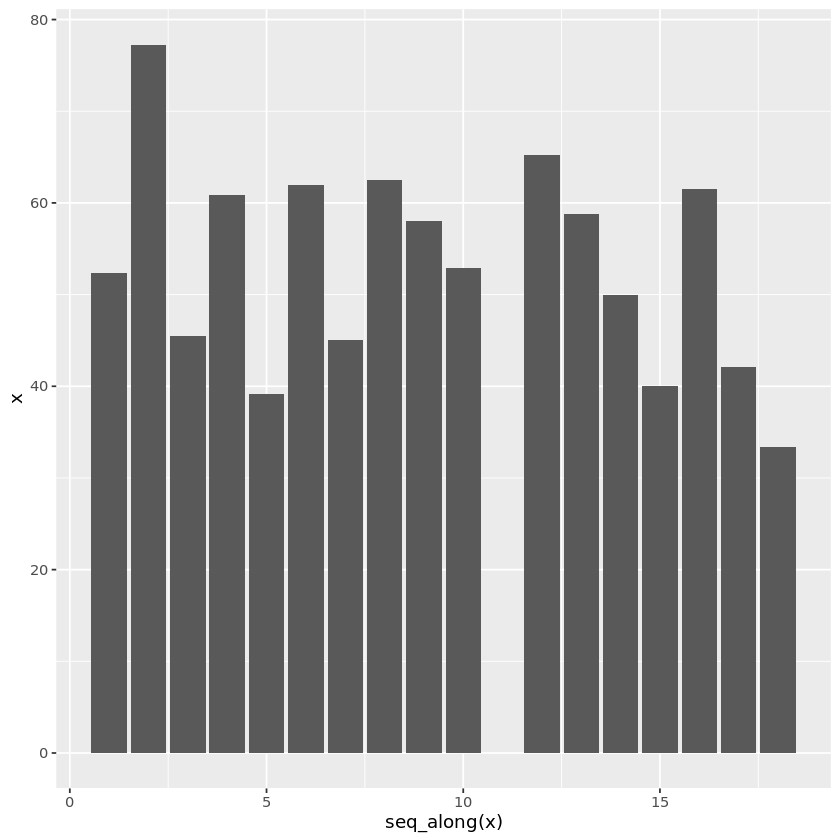

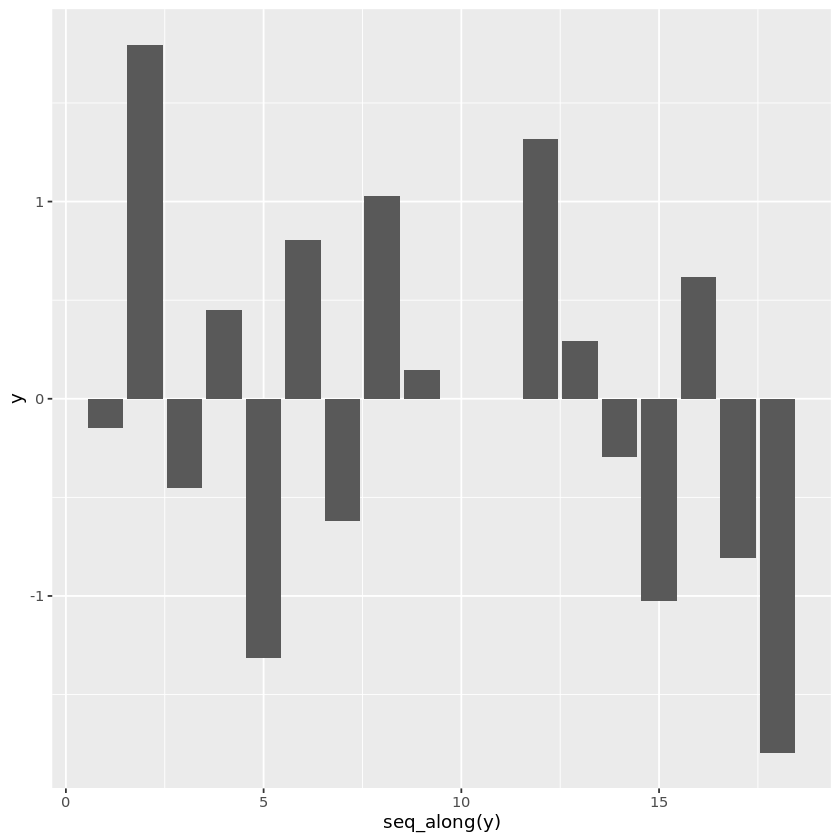

In [50]:
ggplot(data.frame(x),aes(seq_along(x),x))+geom_bar(stat="identity")
ggplot(data.frame(y),aes(seq_along(y),y))+geom_bar(stat="identity")

In [67]:
df_list <- lapply(1:nrow(dc), function(r_num) { myRN(dc[r_num, ]) })
dcN<- do.call(rbind, df_list)

In [71]:
write.table(dcN,paste0(mQTL,"meth_filter_allsites_RankNorm.tab"),sep="\t",row.names = F,quote = F)
head(dcN)

id                  hc1_2      hc1_4      hc2_15     hc2_17     hc3_1     
1 Contig0_39226_39226 -0.1458270  1.7961934 -0.4507442  0.4507442 -1.3153098
2 Contig0_39234_39234  0.3716615 -1.0271543  0.1458270 -1.7961934  0.8059185
3 Contig0_64179_64179  0.3348942 -0.7137046         NA  0.7137046 -0.4232249
4 Contig0_71523_71523  0.9109555  0.9109555  0.9109555  0.0000000 -1.3153098
5 Contig0_71533_71533  0.5804016  0.5804016 -1.0632442  0.5804016  0.5804016
6 Contig0_71542_71542 -0.8465244  0.5009045  0.5009045  0.5009045  0.5009045
  hc3_5     hc3_7      hc3_10     hc3_11     ss2_9      ss2_14    ss2_18    
1 0.8059185 -0.6185211  1.0271543  0.1458270  0.0000000        NA  1.3153098
2 1.0271543 -0.6185211 -0.2948402 -1.3153098  0.0000000        NA -0.1458270
3 1.2450462 -1.7393842  0.5149938 -0.9457771         NA        NA -0.1651163
4        NA -1.7961934  0.9109555  0.1458270 -0.8059185 0.2948402  0.9109555
5 0.5804016 -1.8217485  0.5804016  0.5804016  0.5804016 0.5804016 -1.3466835
6 0.5009045  0.5009045 -1.1929813  0.5009045  0.5009045 0.5009045  0.5009045
  ss3_3      ss3_14     ss3_15     ss3_16     ss3_20     ss5_18    
1  0.2948402 -0.2948402 -1.0271543  0.6185211 -0.8059185 -1.7961934
2  0.6185211  0.3716615  1.3153098 -0.8059185  1.7961934 -0.4507442
3 -0.4232249  0.0000000  0.1651163  1.2450462  1.2450462 -1.2450462
4 -0.6185211 -0.3716615 -0.1458270 -0.3716615 -1.0271543  0.9109555
5 -0.2075038 -0.5804016 -0.8465244 -0.5804016  0.5804016 -0.3504148
6  0.5009045 -0.5804016 -0.3504148 -1.8217485 -1.1929813 -0.5804016

In [70]:
# get meth position file
dcN <- as.data.frame(dcN,stringsAsFactors = F)
chr = sapply(strsplit(dcN$id,"_"), '[',1)
s1 = as.numeric(sapply(strsplit(dcN$id,"_"), '[',2))
s2 = as.numeric(sapply(strsplit(dcN$id,"_"), '[',3))
methpos <- as.data.frame(cbind(dcN$id,chr,s1,s2),stringsAsFactors = F)
methpos$s1 <- as.numeric(methpos$s1)
methpos$s2 <- as.numeric(methpos$s2)
colnames(methpos) <- c('geneid','chr','s1','s2')
head(methpos)
write.table(methpos,file=paste0(mQTL,"methsitespos_mqtl.tab"),quote = F,row.names = F,sep = "\t")

geneid              chr     s1    s2   
1 Contig0_39226_39226 Contig0 39226 39226
2 Contig0_39234_39234 Contig0 39234 39234
3 Contig0_64179_64179 Contig0 64179 64179
4 Contig0_71523_71523 Contig0 71523 71523
5 Contig0_71533_71533 Contig0 71533 71533
6 Contig0_71542_71542 Contig0 71542 71542

In [39]:
%expand
bed <- cbind(chr,s1,s2, dc$id)
write.table(bed,file="{mQTL}methsitepos_mqtl.BED",quote = F,row.names = F,col.names=F,sep = "\t")

In [36]:
%expand
# covariate
id = mbdorder
population = c(rep(0,9),rep(1,9))
covariate <- rbind(id,population)
write.table(covariate,"{mQTL}covariate.tab",sep="\t",row.names=T,quote=F, col.names=F)

In [37]:
%expand
cat {mQTL}covariate.tab

id	hc1_2	hc1_4	hc2_15	hc2_17	hc3_1	hc3_5	hc3_7	hc3_10	hc3_11	ss2_9	ss2_14	ss2_18	ss3_3	ss3_14	ss3_15	ss3_16	ss3_20	ss5_18
population	0	0	0	0	0	0	0	0	0	1	1	1	1	1	1	1	1	1


In [40]:
%expand
bedtools window -w 50000 -u -a {mQTL}snppos_mqtl_05_m2pop.BED -b {mQTL}methsitepos_mqtl.BED > {mQTL}snpAmethB_50kb.txt

In [41]:
%expand
bedtools window -w 50000 -u -b {mQTL}snppos_mqtl_05_m2pop.BED -a {mQTL}methsitepos_mqtl.BED > {mQTL}snpBmethA_50kb.txt

In [42]:
%expand
# how many SNPs are within 50kb of a methylated site
wc -l {mQTL}snpAmethB_50kb.txt

349 ../analyses/2bRAD/mQTL/snpAmethB_50kb.txt


In [43]:
%expand
#how many mbd sites within 50kb of a SNP
wc -l {mQTL}snpBmethA_50kb.txt

1509 ../analyses/2bRAD/mQTL/snpBmethA_50kb.txt


## Run eQTL

In [44]:
%expand
# set parameters
useModel = modelLINEAR
snpfile = "{mQTL}MBD_HCSS_Afilt32m70_maf05_m2pop_format.tab"
methfile = "{mQTL}meth_filter_allsites.tab"
covfile = "{mQTL}covariate.tab"

snposfile = "{mQTL}snppos_mqtl_05_m2pop.tab"

pvOutputThresholdcis = 0.05
pvOutputThresholdtrans = 0.01
output_file_name_cis = "{mQTL}mQTL_sites_cis50kb_p05_maf05.txt"
output_file_name_tra = "{mQTL}mQTL_sites_trans50kb_p01_maf05.txt"
errorCovariance = numeric();

# Distance for local gene-SNP pairs
cisDist = 50000  #50kb

In [45]:
snps = SlicedData$new();
snps$fileDelimiter = "\t";      # the TAB character
snps$fileOmitCharacters = "NA"; # denote missing values;
snps$fileSkipRows = 1;          # one row of column labels
snps$fileSkipColumns = 1;       # one column of row labels
snps$fileSliceSize = 2000;      # read file in pieces of 2,000 rows
snps$LoadFile( snpfile )

Rows read: 2,000

Rows read: 2860 done.



In [46]:
meth = SlicedData$new();
meth$fileDelimiter = "\t";      # the TAB character
meth$fileOmitCharacters = "NA"; # denote missing values;
meth$fileSkipRows = 1;          # one row of column labels
meth$fileSkipColumns = 1;       # one column of row labels
meth$fileSliceSize = 2000;      # read file in pieces of 2,000 rows
meth$LoadFile( methfile )

Rows read: 2,000

Rows read: 4,000

Rows read: 6,000

Rows read: 8,000

Rows read: 10,000

Rows read: 12,000

Rows read: 14,000

Rows read: 16,000

Rows read: 18,000

Rows read: 20,000

Rows read: 22,000

Rows read: 24,000

Rows read: 26,000

Rows read: 28,000

Rows read: 30,000

Rows read: 32,000

Rows read: 33738 done.



In [47]:
cvrt = SlicedData$new();
cvrt$fileDelimiter = "\t";      # the TAB character
cvrt$fileOmitCharacters = "NA"; # denote missing values;
cvrt$fileSkipRows = 1;          # one row of column labels
cvrt$fileSkipColumns = 1;       # one column of row labels
cvrt$fileSliceSize = 2000;      # read file in pieces of 2,000 rows
cvrt$LoadFile( covfile )

Rows read: 1 done.



In [48]:
## Run the analysis

meS = Matrix_eQTL_main(
snps = snps, 
gene = meth, 
cvrt = cvrt,
output_file_name     = output_file_name_tra,
pvOutputThreshold     = pvOutputThresholdtrans,
useModel = useModel, 
errorCovariance = errorCovariance, 
verbose = TRUE, 
output_file_name.cis = output_file_name_cis,
pvOutputThreshold.cis = pvOutputThresholdcis,
snpspos = snppos, 
genepos = methpos,
cisDist = cisDist,
pvalue.hist = "qqplot",
min.pv.by.genesnp = TRUE,
noFDRsaveMemory = FALSE);

unlink(output_file_name_tra);
unlink(output_file_name_cis);

Matching data files and location files

33738 of 33738 genes matched

2860 of 2860 SNPs matched


Task finished in 0.019 seconds

Reordering genes

Task finished in 0.477 seconds

Processing covariates

Task finished in 0.005 seconds

Processing gene expression data (imputation, residualization)

Task finished in 0.163 seconds

Creating output file(s)

Task finished in 0.041 seconds

Performing eQTL analysis

 2.94% done, 132 cis-eQTLs, 49,061 trans-eQTLs

 5.88% done, 97,883 trans-eQTLs

 8.82% done, 146,211 trans-eQTLs

11.76% done, 194,904 trans-eQTLs

14.70% done, 243,569 trans-eQTLs

17.64% done, 291,716 trans-eQTLs

20.58% done, 340,925 trans-eQTLs

23.52% done, 389,085 trans-eQTLs

26.47% done, 438,906 trans-eQTLs

29.41% done, 488,406 trans-eQTLs

32.35% done, 537,685 trans-eQTLs

35.29% done, 587,211 trans-eQTLs

38.23% done, 637,332 trans-eQTLs

41.17% done, 686,766 trans-eQTLs

44.11% done, 737,111 trans-eQTLs

47.05% done, 786,387 trans-eQTLs

50.00% done, 828,552 trans-eQT

In [49]:
%expand
save(meS,file="{mQTL}MBD_HCSS_Afilt32m70_maf05_m2pop_sites50k_mQTL")

In [50]:
cat('Detected local eQTLs:', '\n');
show(meS$cis$eqtls)
cat('Detected distant eQTLs:', '\n');
head(meS$trans$eqtls)

Detected local eQTLs: 
                 snps                    gene  statistic       pvalue
1    Contig23519_7291   Contig23519_9293_9293 -14.173608 4.308558e-10
2    Contig24215_2988   Contig24215_1925_1925  -6.124513 1.944758e-05
3   Contig24017_15180 Contig24017_15216_15216  -5.869618 3.082254e-05
4    Contig54642_5622   Contig54642_8901_8901  -5.717828 4.071957e-05
5    Contig24215_2988   Contig24215_1835_1835  -5.537405 5.692590e-05
6    Contig41076_7787 Contig41076_12546_12546  -4.824013 2.231353e-04
7    Contig168159_937    Contig168159_859_859  -4.372161 5.465643e-04
8    Contig31124_7124   Contig31124_5961_5961  -4.139753 8.730403e-04
9    Contig26107_2576   Contig26107_7351_7351  -4.020594 1.111773e-03
10   Contig26107_2582   Contig26107_7351_7351  -4.020594 1.111773e-03
11   Contig37183_1991   Contig37183_6204_6204   3.990655 1.181566e-03
12   Contig43574_3303   Contig43574_6730_6730   3.980382 1.206526e-03
13   Contig43574_3305   Contig43574_6730_6730   3.980382 1.206526e-

snps              gene                  statistic pvalue        FDR          
1 Contig55653_4319  Contig17607_5734_5734       Inf 2.225074e-308 1.073472e-300
2 Contig59246_11313 Contig17607_5734_5734       Inf 2.225074e-308 1.073472e-300
3 Contig23564_3850  Contig41436_9662_9662 129955756 2.632771e-114 4.233877e-107
4 Contig47140_12962 Contig41436_9662_9662 129955756 2.632771e-114 4.233877e-107
5 Contig47538_11559 Contig41436_9662_9662 129955756 2.632771e-114 4.233877e-107
6 Contig77937_5842  Contig72939_1635_1635 129955756 2.632771e-114 4.233877e-107
  beta    
1 5.000000
2 5.000000
3 2.777778
4 2.777778
5 2.777778
6 1.428571

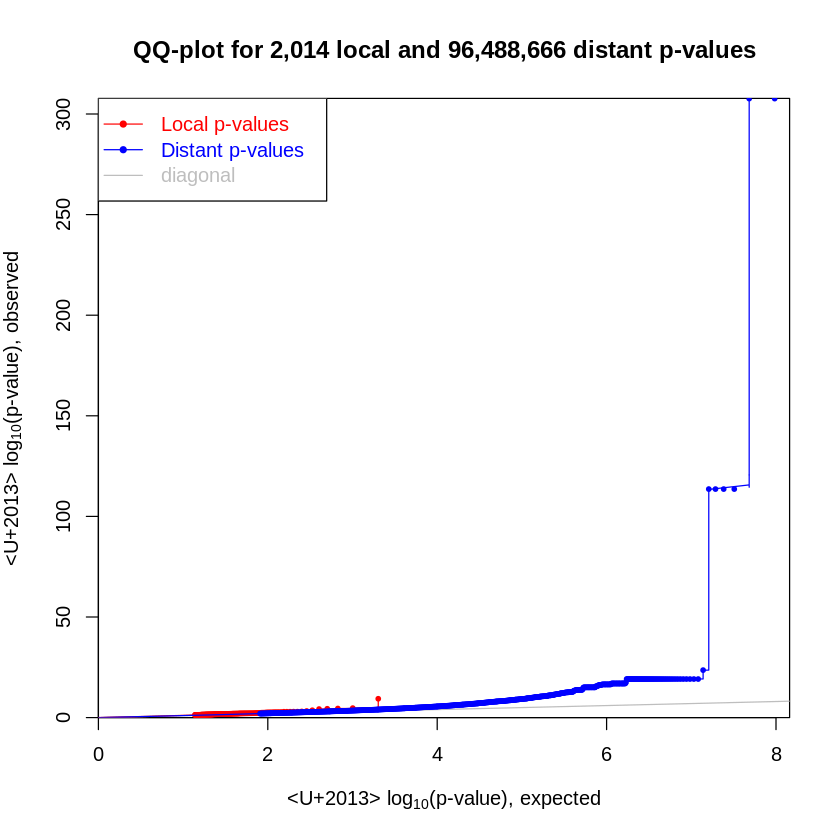

In [51]:
plot(meS)

### looking at trans genes that are highly sih

In [52]:
meS$trans$neqtls

[1] 1192688

In [53]:
sigtrans <- meS$trans$eqtls[which(meS$trans$eqtls$FDR < 0.05),]
# Calculate mean p-value for each sig trans meth site
mean_sigtrans <- sigtrans %>% 
   group_by(gene) %>%
   dplyr::summarise(
    mean_fdr= mean(FDR, na.rm=TRUE),
    mean_beta= mean(beta,na.rm=TRUE),
    n())  
dim(mean_sigtrans)

`summarise()` ungrouping output (override with `.groups` argument)



[1] 4936    4

In [54]:
mean(mean_sigtrans$`n()`)

[1] 2.868517

In [55]:
trans_snps <- meS$trans$eqtls[which(meS$trans$eqtls$FDR < 0.05),] %>%
group_by(snps) %>%
dplyr::summarise(
    mean_fdr= mean(FDR, na.rm=TRUE),
    mean_beta= mean(beta,na.rm=TRUE),
    n()) 
 
dim(trans_snps)

`summarise()` ungrouping output (override with `.groups` argument)



[1] 1632    4

In [56]:
mean(trans_snps$`n()`)

[1] 8.675858

* 2017 methylated sites out of 33738 total sites have at least 1 trans (> 50kb away) SNP that is statistically linked (FDR < 1%). Mean 2.8 SNPs are significantly associated with each bin. 935 SNPs are associated with at least 1 site, mean 6 sites per SNP.  
* 4936 methylated sites out of 33738 total sites have at least 1 trans (> 50kb away) SNP that is statistically linked (FDR < 5%). Mean 2.86 SNPs are significantly associated with each bin. 1,632 SNPs are associated with at least 1 site, mean 8.7 sites per SNP.  

In [57]:
head(mean_sigtrans[order(mean_sigtrans$mean_beta),],n = 20)

gene                    mean_fdr     mean_beta n()
1  Contig41264_11731_11731 0.0032636355 -88.92106  1 
2  Contig56688_1518_1518   0.0004073354 -87.60337  1 
3  Contig47781_6149_6149   0.0228123090 -86.93418  5 
4  Contig74537_1571_1571   0.0006506861 -86.60830  2 
5  Contig46601_8175_8175   0.0002110343 -85.18110  8 
6  Contig43177_12092_12092 0.0091432695 -84.41653  3 
7  Contig57936_294_294     0.0003706918 -84.21355  1 
8  Contig143_19461_19461   0.0096656429 -83.05348  1 
9  Contig6699_7862_7862    0.0007570169 -82.77635  1 
10 Contig10599_133_133     0.0264162585 -82.50538  3 
11 Contig38343_916_916     0.0439152844 -81.72232  5 
12 Contig1270_4727_4727    0.0023199431 -81.20491  1 
13 Contig24215_22330_22330 0.0007232334 -81.08812  2 
14 Contig695_177_177       0.0189884515 -79.70718  3 
15 Contig101661_1298_1298  0.0048058124 -79.44343  3 
16 Contig29266_6271_6271   0.0397139720 -78.20646  7 
17 Contig71265_228_228     0.0210337618 -78.10206  3 
18 Contig173_13455_13455   0.0008352292 -77.66545  2 
19 Contig27574_29746_29746 0.0126290980 -76.37157  4 
20 Contig57394_2396_2396   0.0092813721 -76.22438 25

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



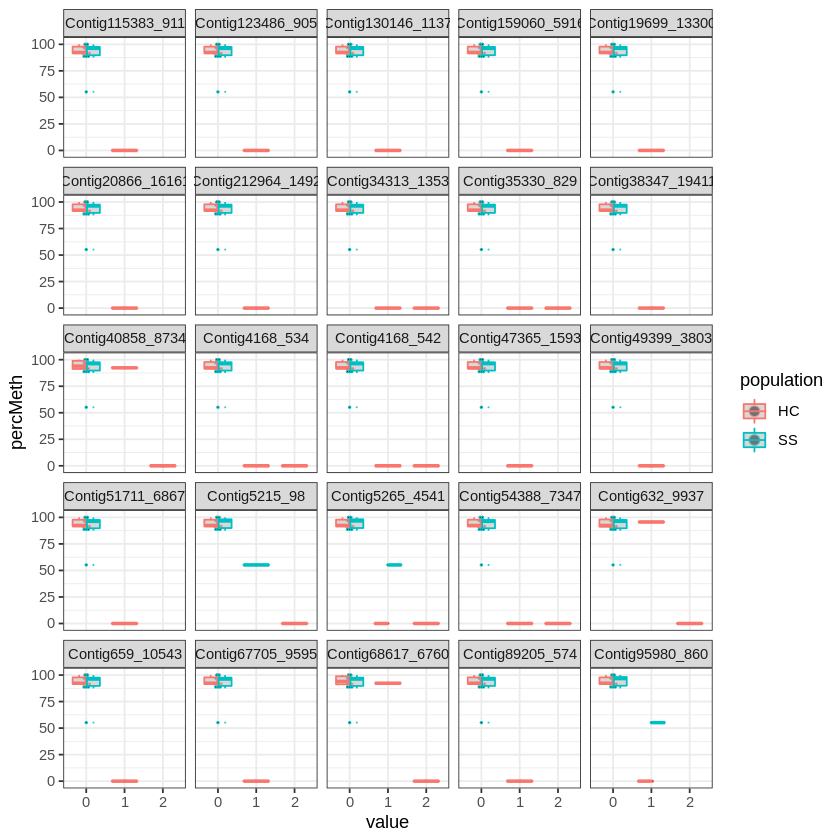

In [58]:
m <- perc_meth %>% filter(site=="Contig57394_2396_2396")
s <- meS$trans$eqtls[which(meS$trans$eqtls$gene == "Contig57394_2396_2396" & meS$trans$eqtls$FDR < 0.05),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw()

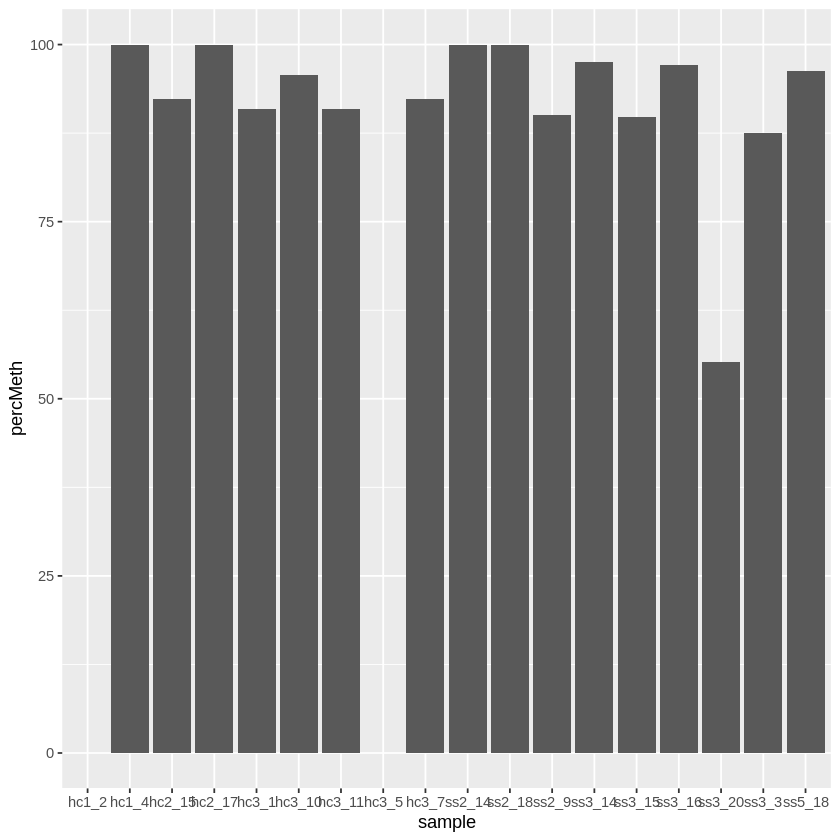

In [59]:
perc_meth %>% filter(site=="Contig57394_2396_2396") %>% ggplot(aes(x=sample, y=percMeth)) + geom_bar(stat="identity")

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 8 rows containing non-finite values (stat_bindot)."
Warning message:
"Removed 8 rows containing non-finite values (stat_boxplot)."


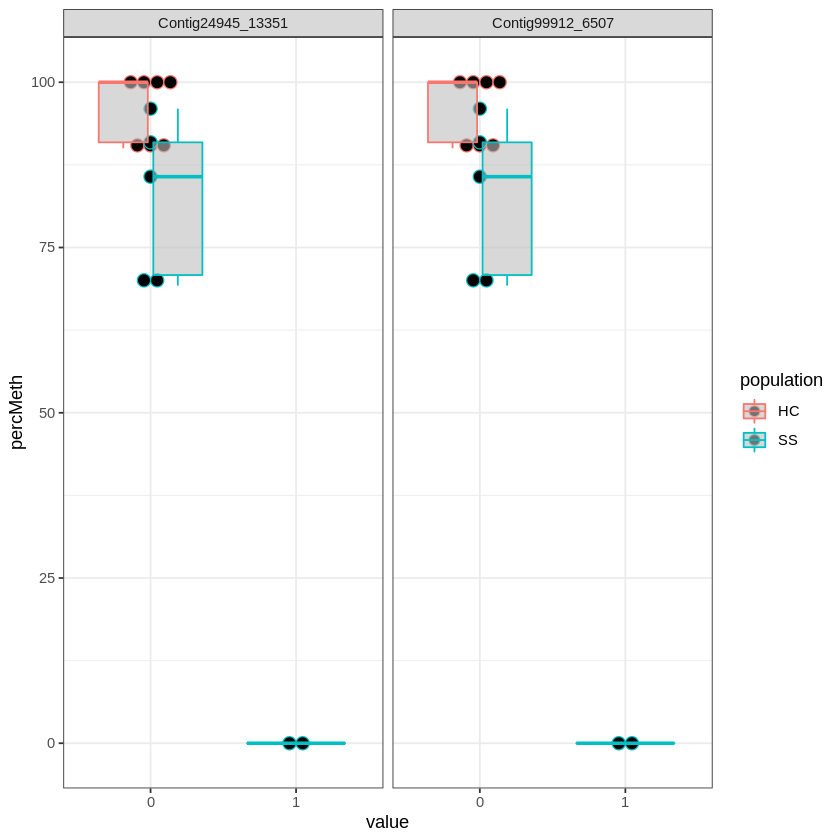

In [61]:
m <- perc_meth %>% filter(site=="Contig24215_22330_22330")
s <- meS$trans$eqtls[which(meS$trans$eqtls$gene == "Contig24215_22330_22330" & meS$trans$eqtls$FDR < 0.05),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw()

### Cis snps

In [62]:
meS$cis$neqtls

[1] 146

In [63]:
# Calculate mean p-value for each sig trans meth site
mean_sigcis <- meS$cis$eqtls %>% 
   group_by(gene) %>%
   dplyr::summarise(
    mean_pval= mean(pvalue, na.rm=TRUE),
    mean_beta= mean(beta,na.rm=TRUE),
    n())  
dim(mean_sigcis)

`summarise()` ungrouping output (override with `.groups` argument)



[1] 131   4

In [64]:
mean(mean_sigcis$`n()`)

[1] 1.114504

In [65]:
cis_snps <- meS$cis$eqtls %>%
group_by(snps) %>%
dplyr::summarise(
    mean_pval= mean(pvalue, na.rm=TRUE),
    mean_beta= mean(beta,na.rm=TRUE),
    n()) 
 
dim(cis_snps)

`summarise()` ungrouping output (override with `.groups` argument)



[1] 104   4

In [202]:
mean(cis_snps$`n()`)

[1] 1.403846

131 methylated sites out of 33738 total sites have at least 1 cis (< 50kb away) SNP that is statistically linked (pvalue < 0.05). Mean 1.1 SNPs are significantly associated with each bin. 104 SNPs are associated with at least 1 site, mean 1.4 sites per SNP.  

In [66]:
show(meS$cis$eqtls)

                 snps                    gene  statistic       pvalue
1    Contig23519_7291   Contig23519_9293_9293 -14.173608 4.308558e-10
2    Contig24215_2988   Contig24215_1925_1925  -6.124513 1.944758e-05
3   Contig24017_15180 Contig24017_15216_15216  -5.869618 3.082254e-05
4    Contig54642_5622   Contig54642_8901_8901  -5.717828 4.071957e-05
5    Contig24215_2988   Contig24215_1835_1835  -5.537405 5.692590e-05
6    Contig41076_7787 Contig41076_12546_12546  -4.824013 2.231353e-04
7    Contig168159_937    Contig168159_859_859  -4.372161 5.465643e-04
8    Contig31124_7124   Contig31124_5961_5961  -4.139753 8.730403e-04
9    Contig26107_2576   Contig26107_7351_7351  -4.020594 1.111773e-03
10   Contig26107_2582   Contig26107_7351_7351  -4.020594 1.111773e-03
11   Contig37183_1991   Contig37183_6204_6204   3.990655 1.181566e-03
12   Contig43574_3303   Contig43574_6730_6730   3.980382 1.206526e-03
13   Contig43574_3305   Contig43574_6730_6730   3.980382 1.206526e-03
14   Contig54642_562

In [67]:
head(meS$cis$eqtls)

snps              gene                    statistic  pvalue      
1 Contig23519_7291  Contig23519_9293_9293   -14.173608 4.308558e-10
2 Contig24215_2988  Contig24215_1925_1925    -6.124513 1.944758e-05
3 Contig24017_15180 Contig24017_15216_15216  -5.869618 3.082254e-05
4 Contig54642_5622  Contig54642_8901_8901    -5.717828 4.071957e-05
5 Contig24215_2988  Contig24215_1835_1835    -5.537405 5.692590e-05
6 Contig41076_7787  Contig41076_12546_12546  -4.824013 2.231353e-04
  FDR          beta      
1 8.677436e-07 -61.502683
2 1.958371e-02 -18.874410
3 2.050231e-02 -31.373238
4 2.050231e-02 -12.922342
5 2.292975e-02 -19.284748
6 7.489910e-02  -8.108287

In [68]:
%expand
write.table(meS$cis$eqtls,"{mQTL}mQTL_sites_cis50kb_p05_maf05_2pop.txt",quote = F,row.names = F)

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."
Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."


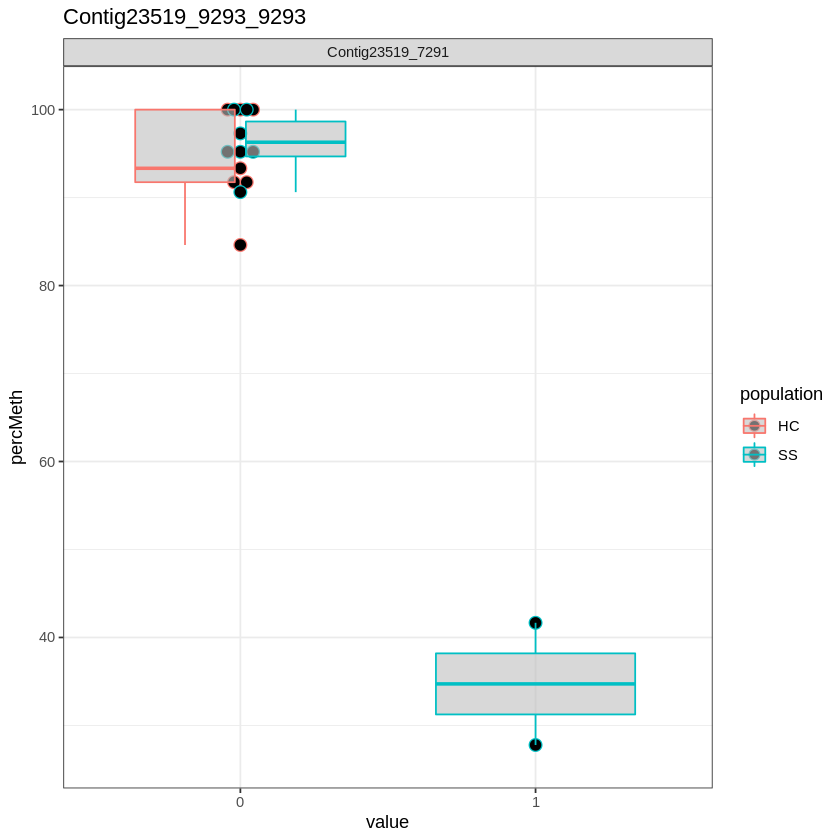

In [69]:
m <- perc_meth %>% filter(site=="Contig23519_9293_9293")
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == "Contig23519_9293_9293"),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw() + ggtitle("Contig23519_9293_9293")

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."
Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."


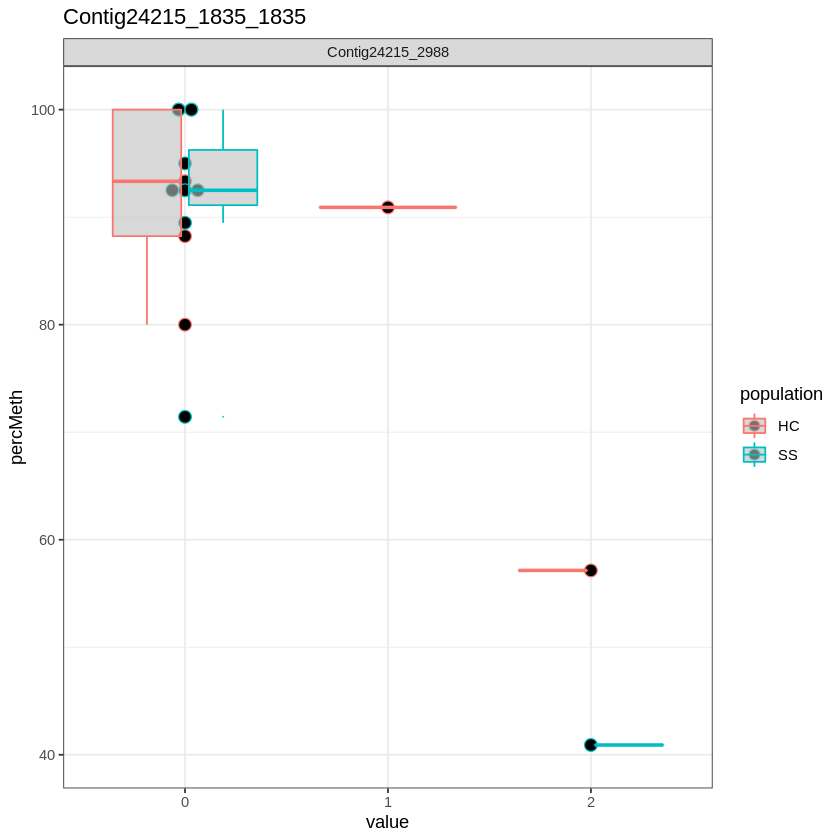

In [70]:
m <- perc_meth %>% filter(site=="Contig24215_1835_1835")
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == "Contig24215_1835_1835"),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6,) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw() + ggtitle("Contig24215_1835_1835")

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."
Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."


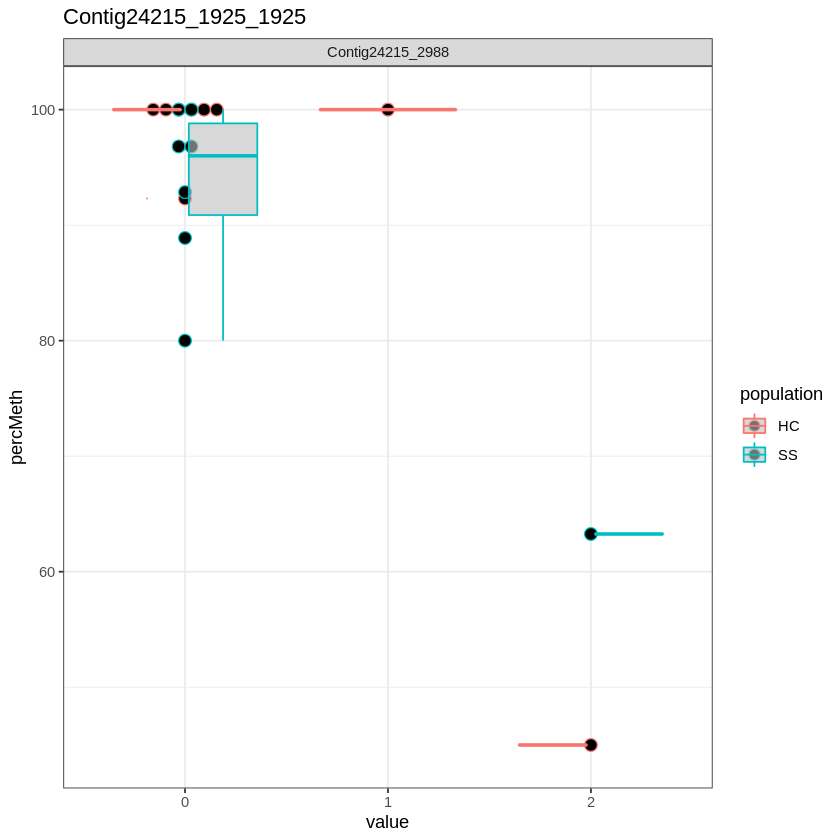

In [190]:
m <- perc_meth %>% filter(site=="Contig24215_1925_1925")
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == "Contig24215_1925_1925"),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6,) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw() + ggtitle("Contig24215_1925_1925")

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."
Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."


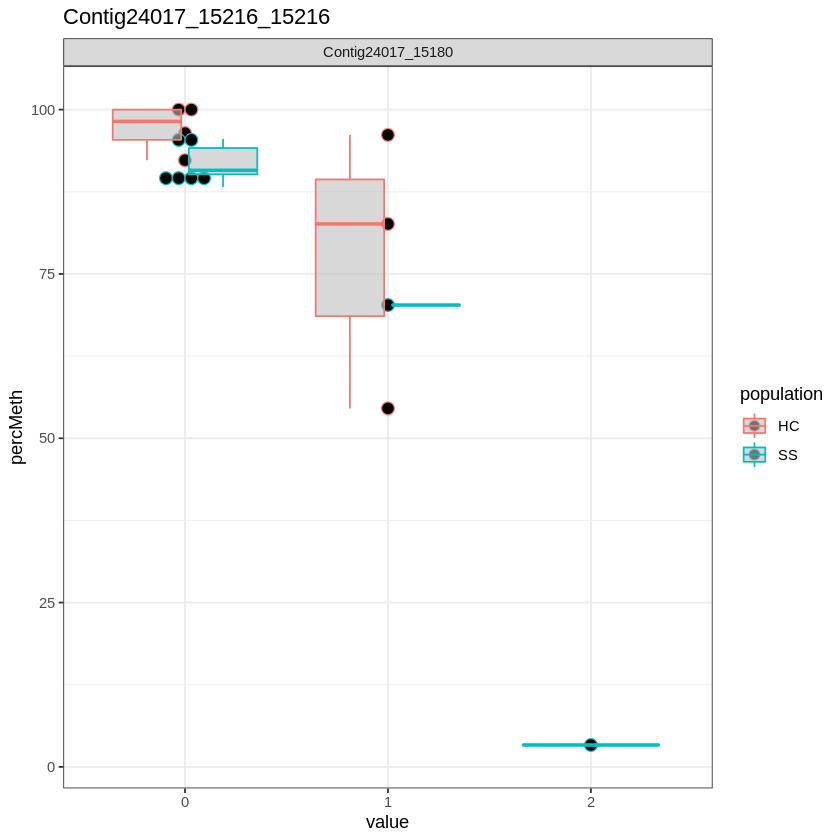

In [71]:
m <- perc_meth %>% filter(site=="Contig24017_15216_15216")
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == "Contig24017_15216_15216"),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6,) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw() + ggtitle("Contig24017_15216_15216")

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bindot)."
Warning message:
"Removed 4 rows containing non-finite values (stat_boxplot)."


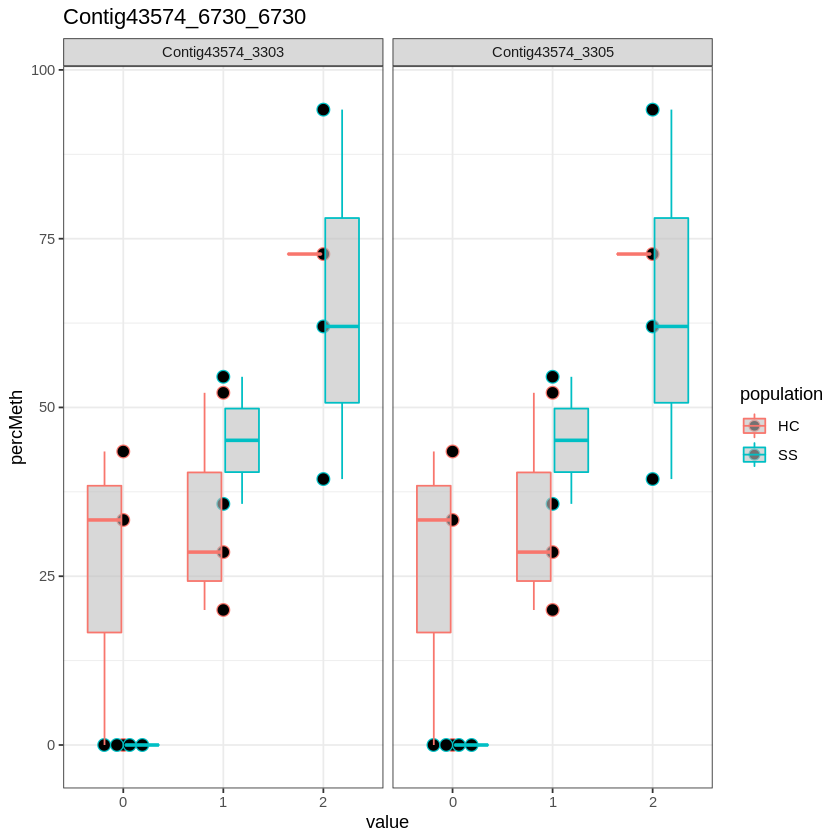

In [72]:
m <- perc_meth %>% filter(site=="Contig43574_6730_6730")
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == "Contig43574_6730_6730"),]$snps

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g))) %>%
ggplot(., aes(value, percMeth,colour=population)) + 
        geom_dotplot(binaxis='y', stackdir='center',dotsize=0.6,) +
        geom_boxplot(outlier.size=0, alpha=0.6, fill="grey") +
        facet_wrap(~id) + theme_bw() + ggtitle("Contig43574_6730_6730")

### All cis-meQTLs

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."
Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


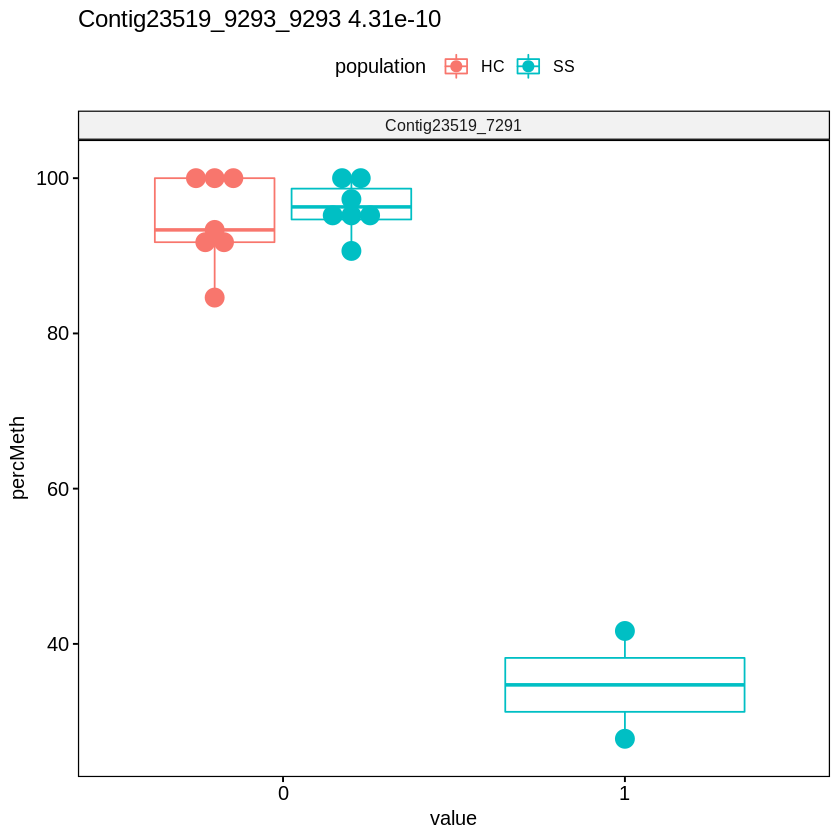

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


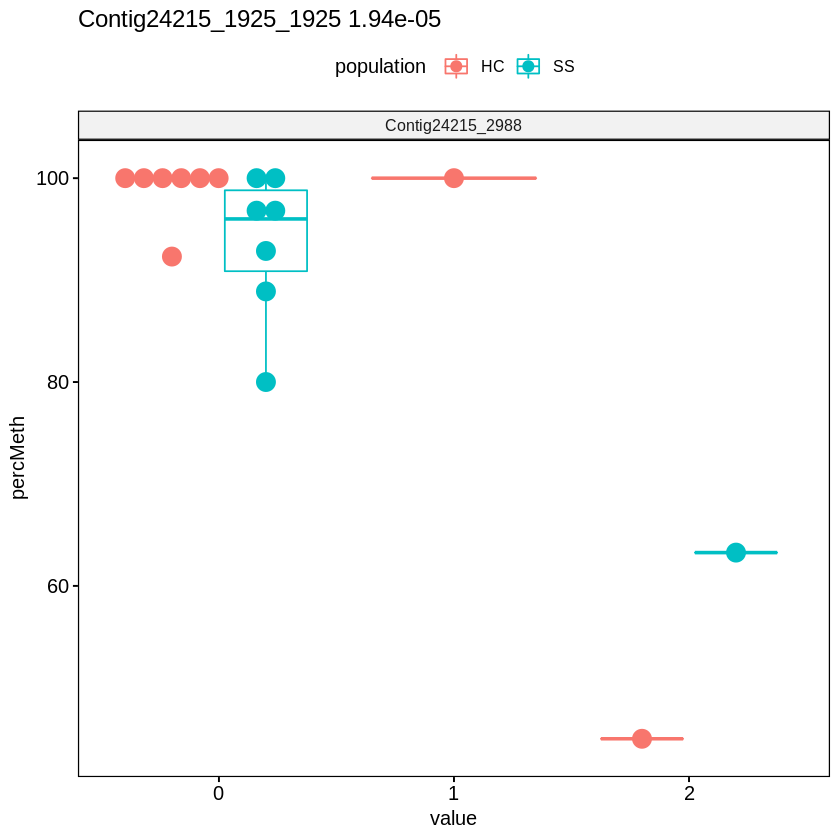

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


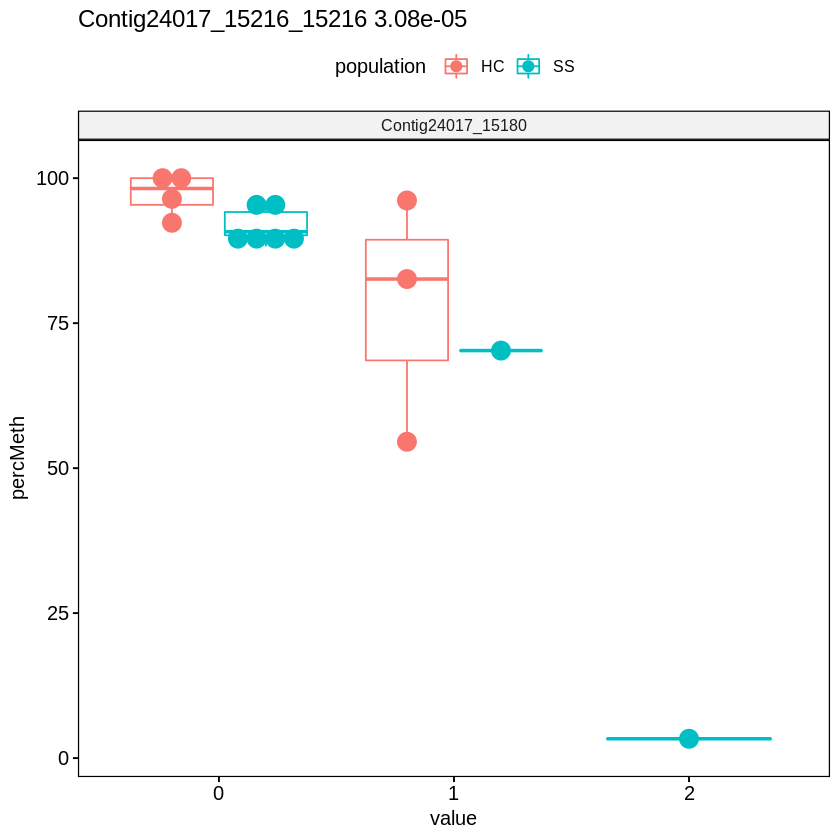

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


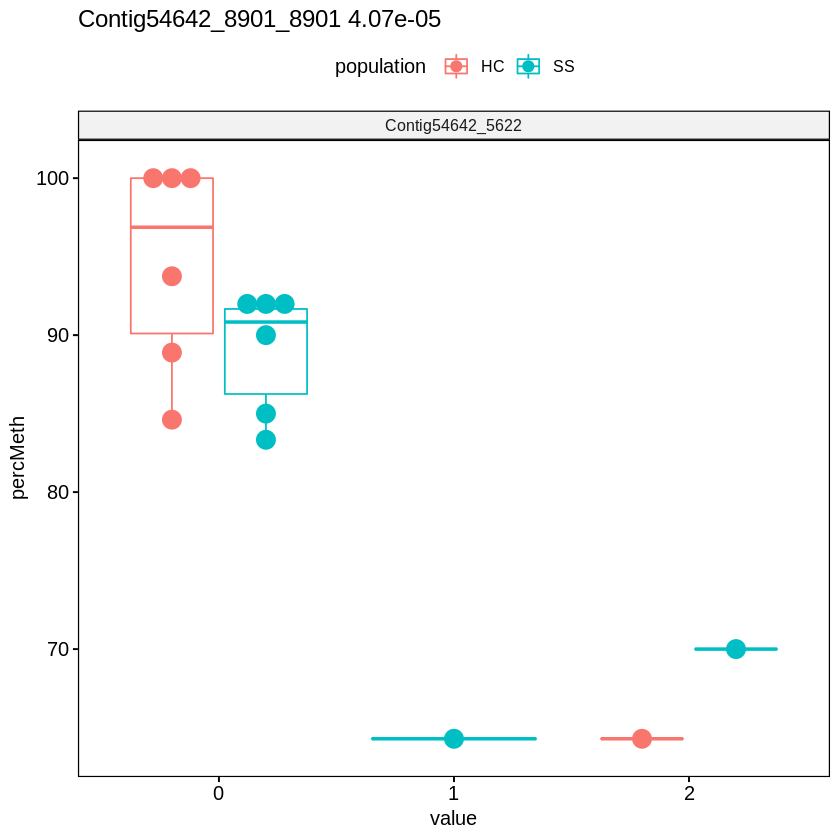

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


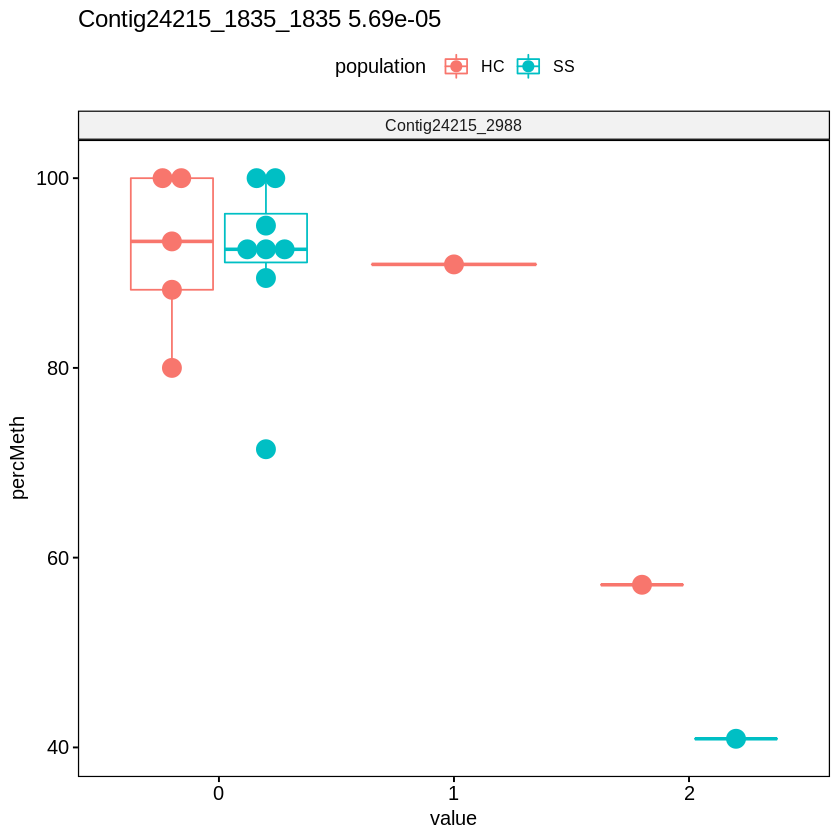

Warning message:
"Removed 6 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 6 rows containing non-finite values (stat_bindot)."


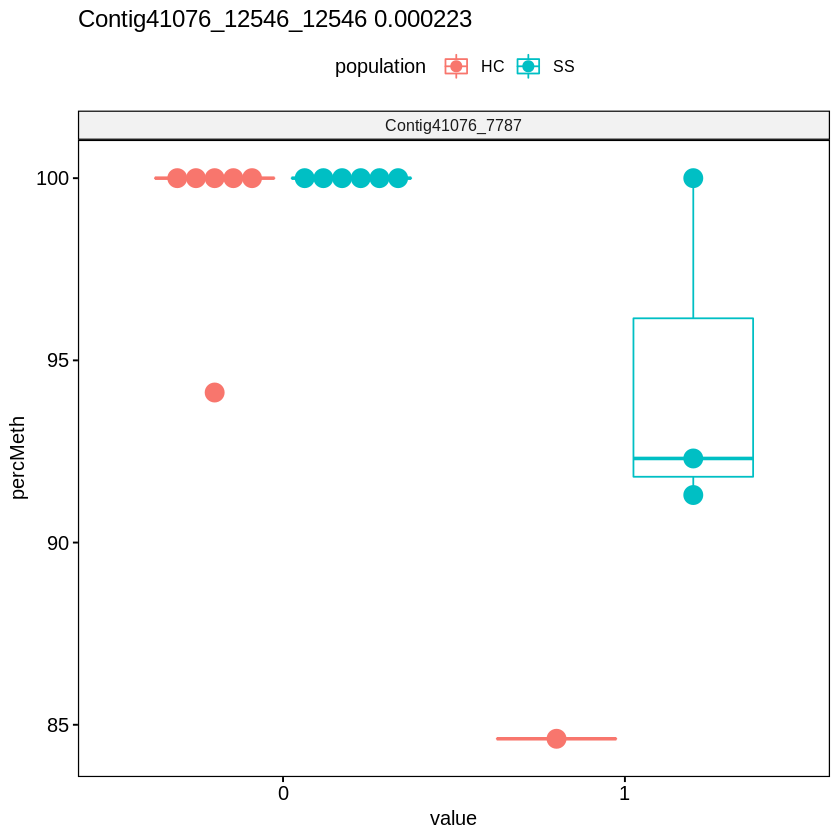

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


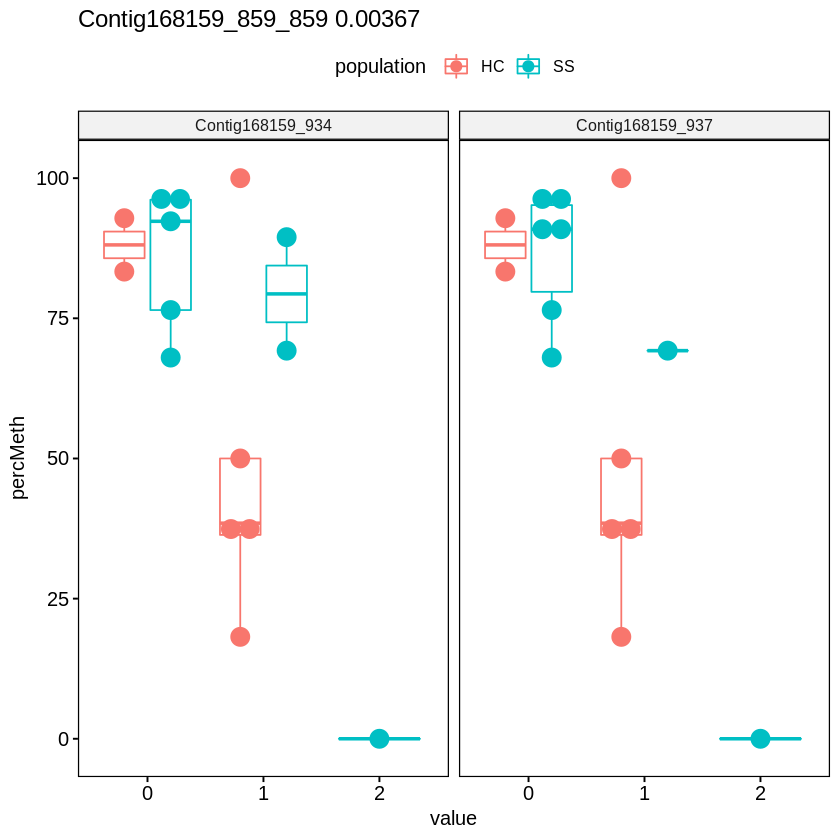

Warning message:
"Removed 12 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 12 rows containing non-finite values (stat_bindot)."


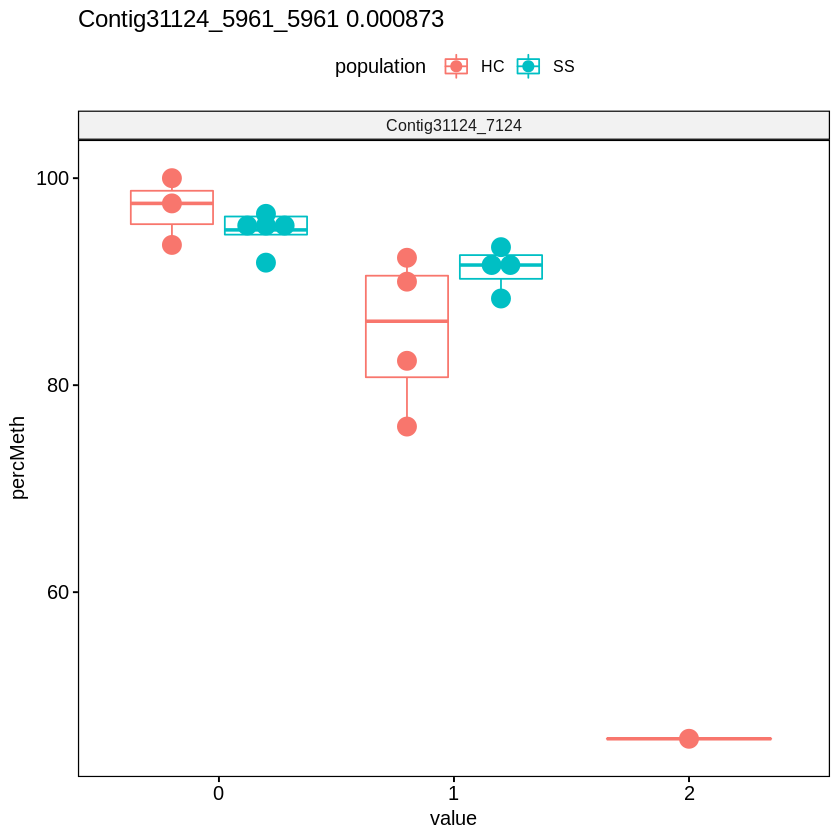

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



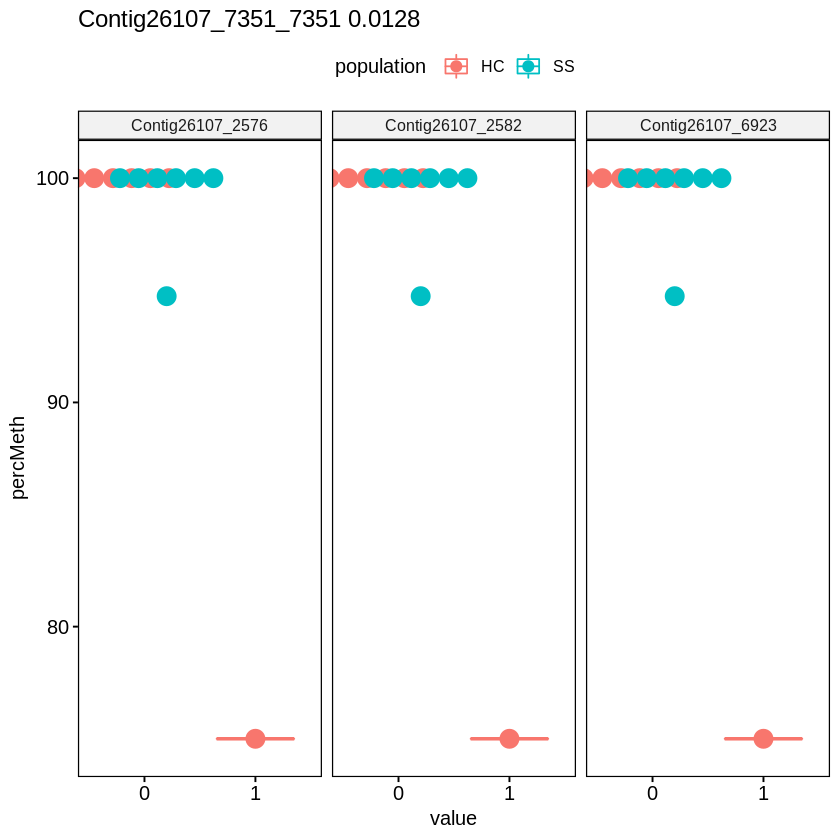

Warning message:
"Removed 4 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bindot)."


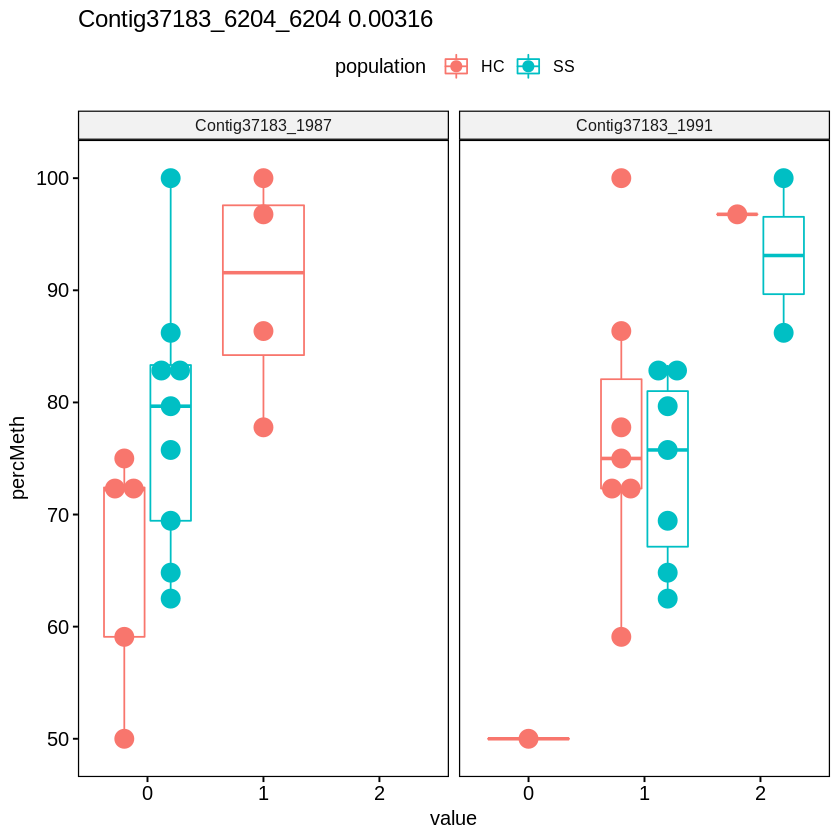

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


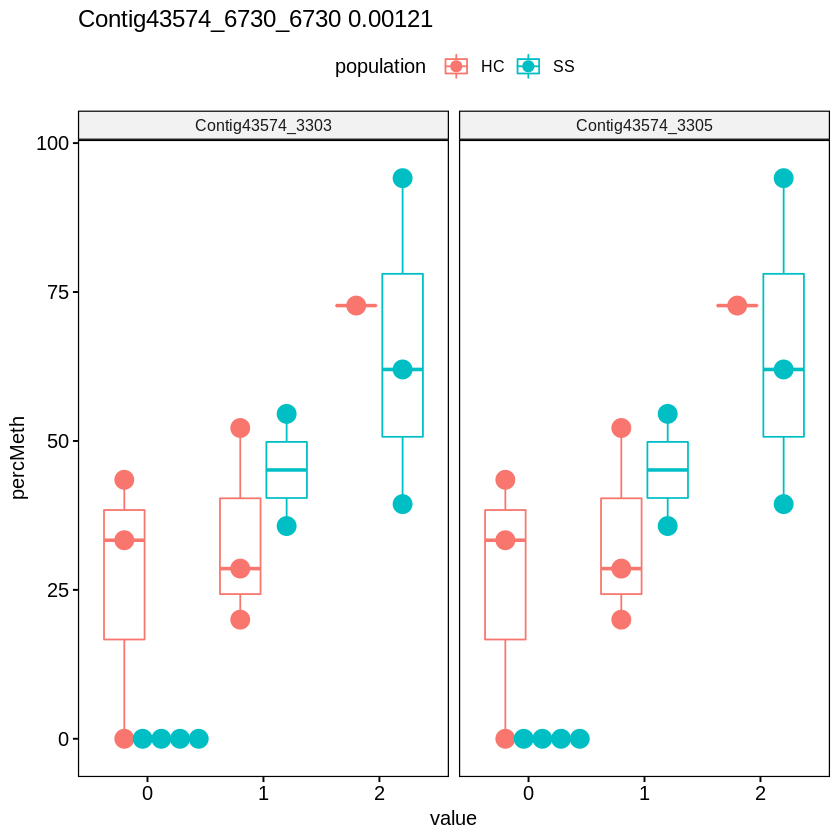

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


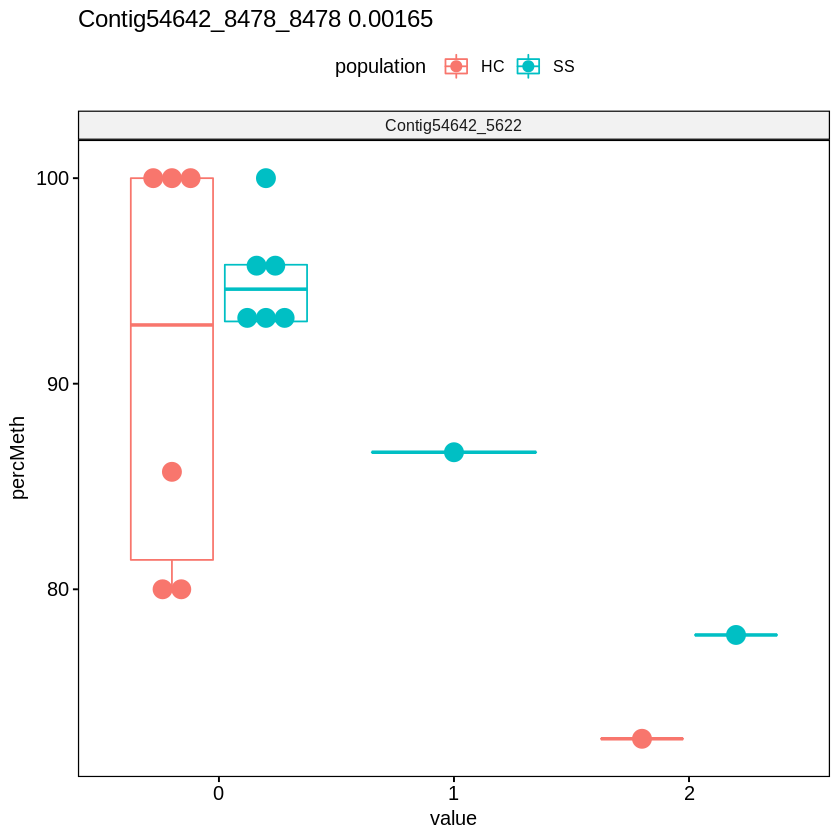

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


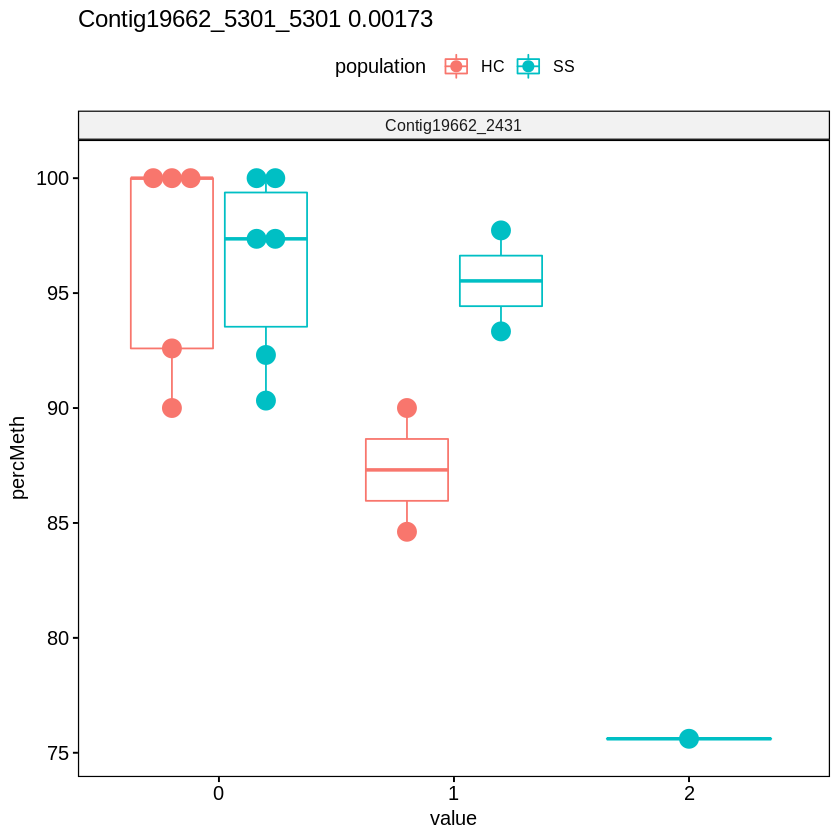

Warning message:
"Removed 4 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bindot)."


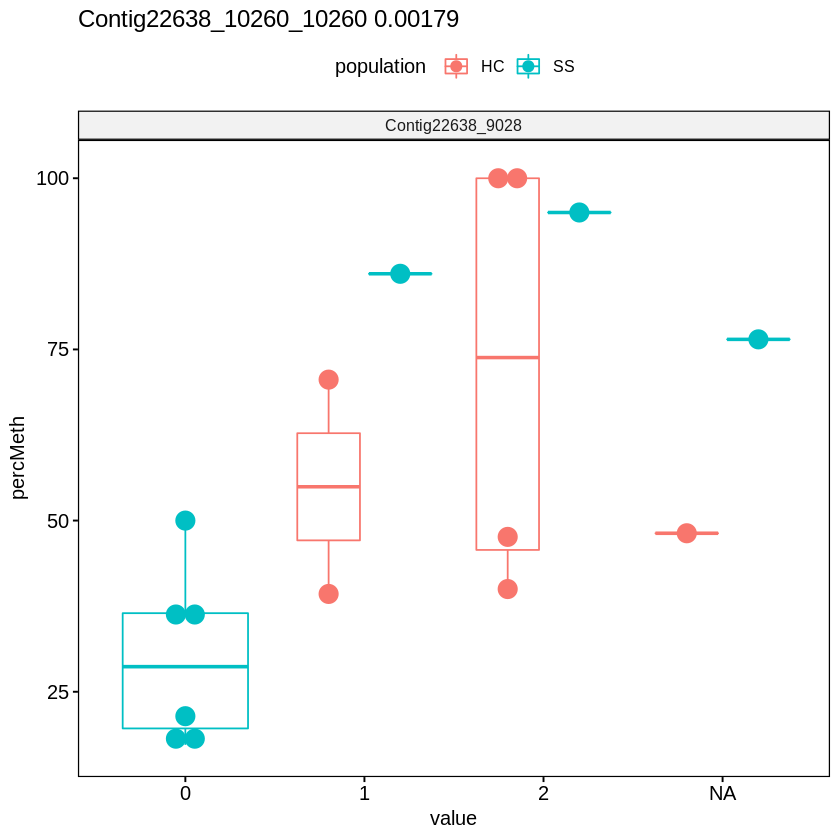

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


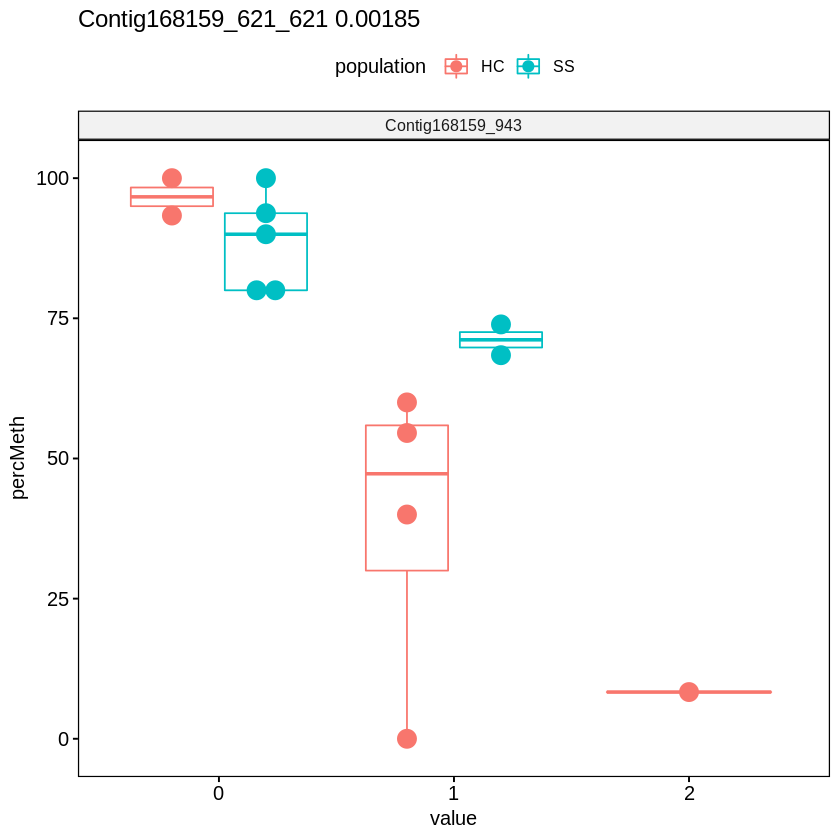

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



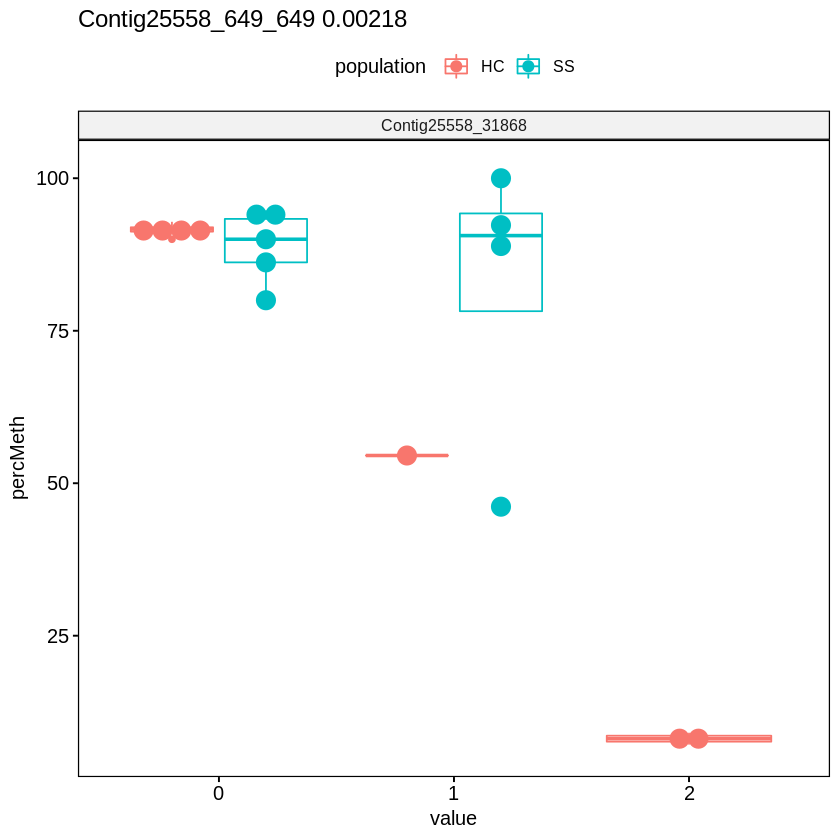

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



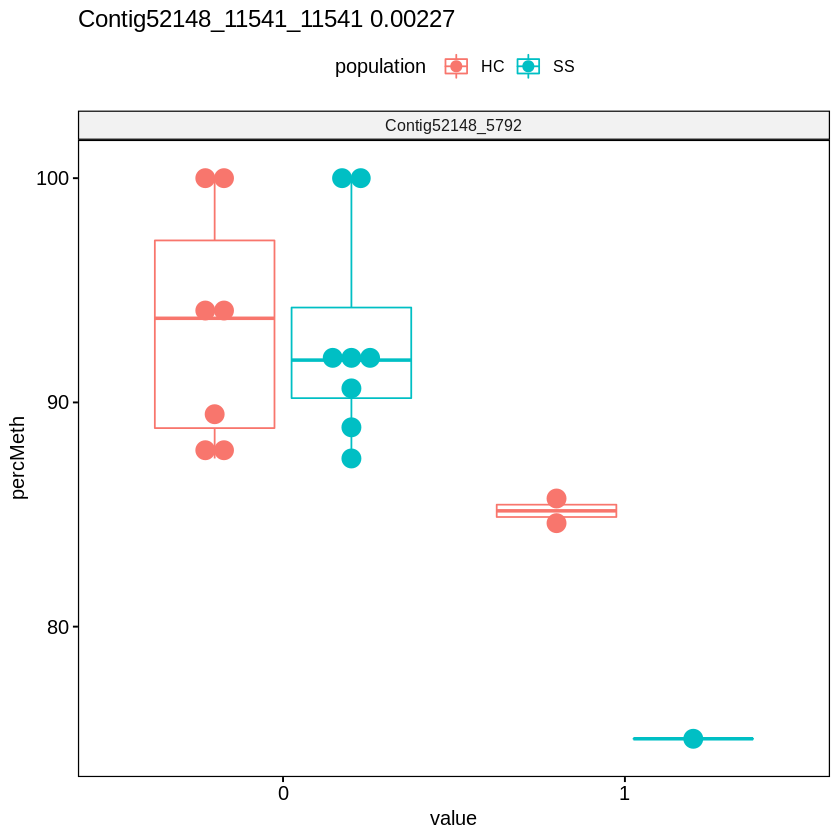

Warning message:
"Removed 4 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bindot)."


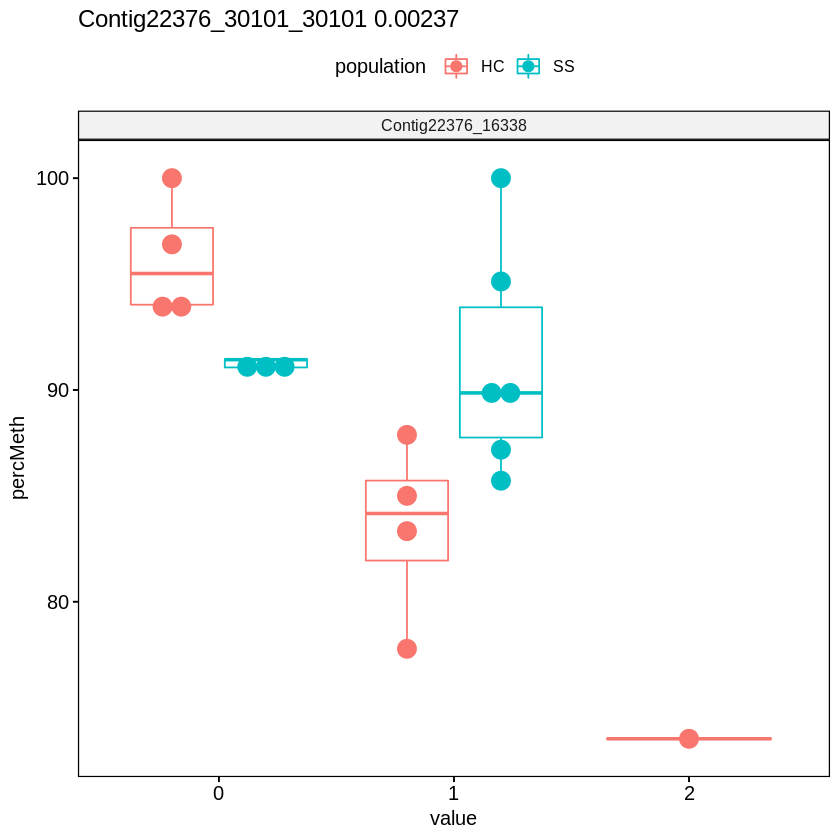

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


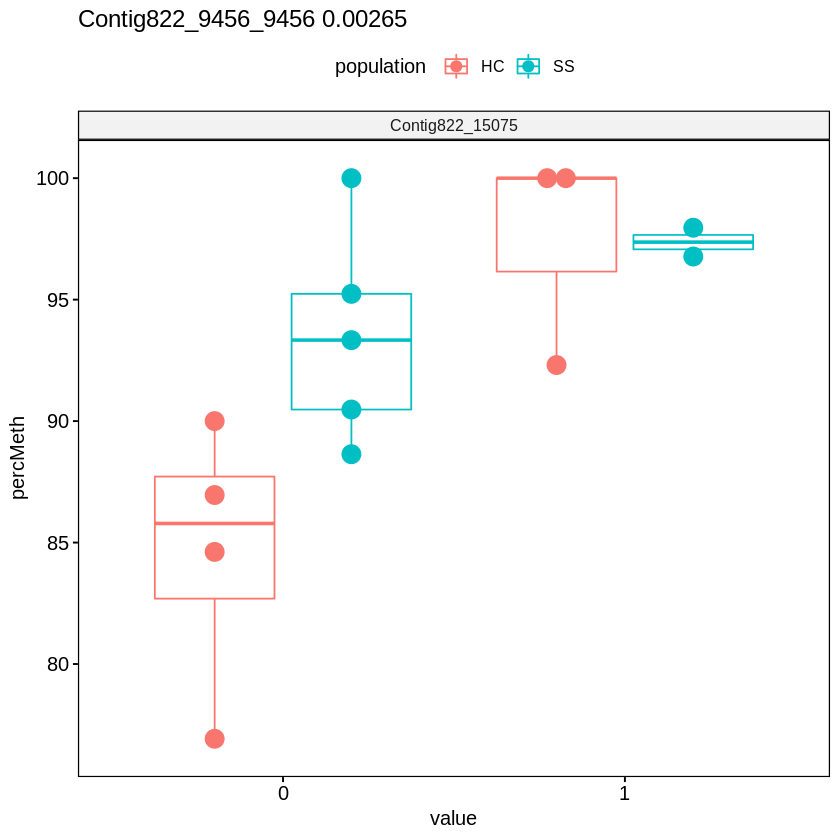

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


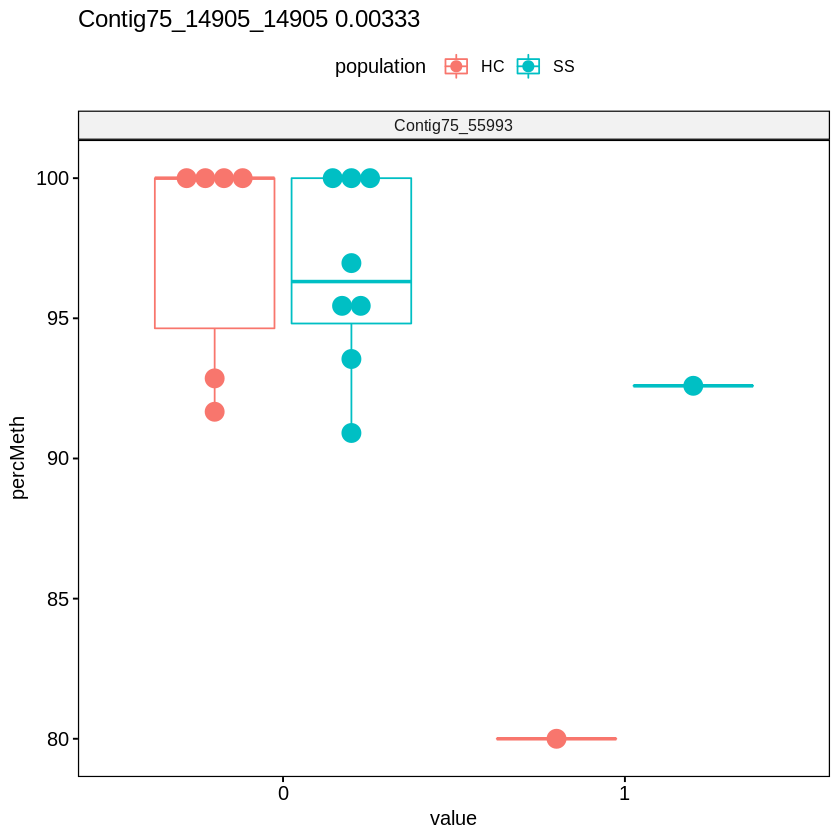

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


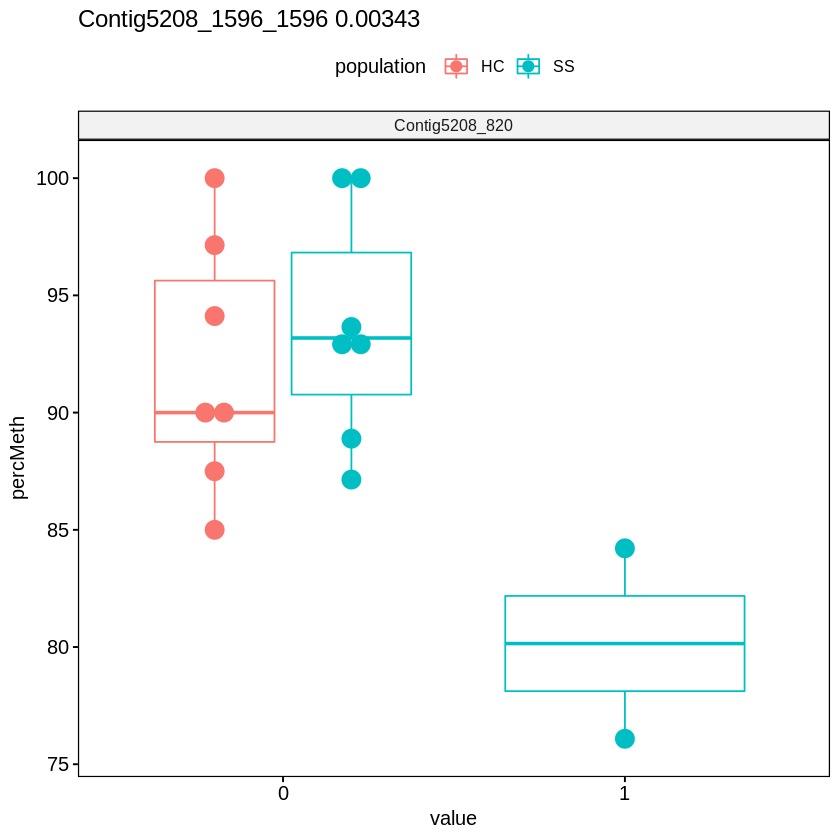

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


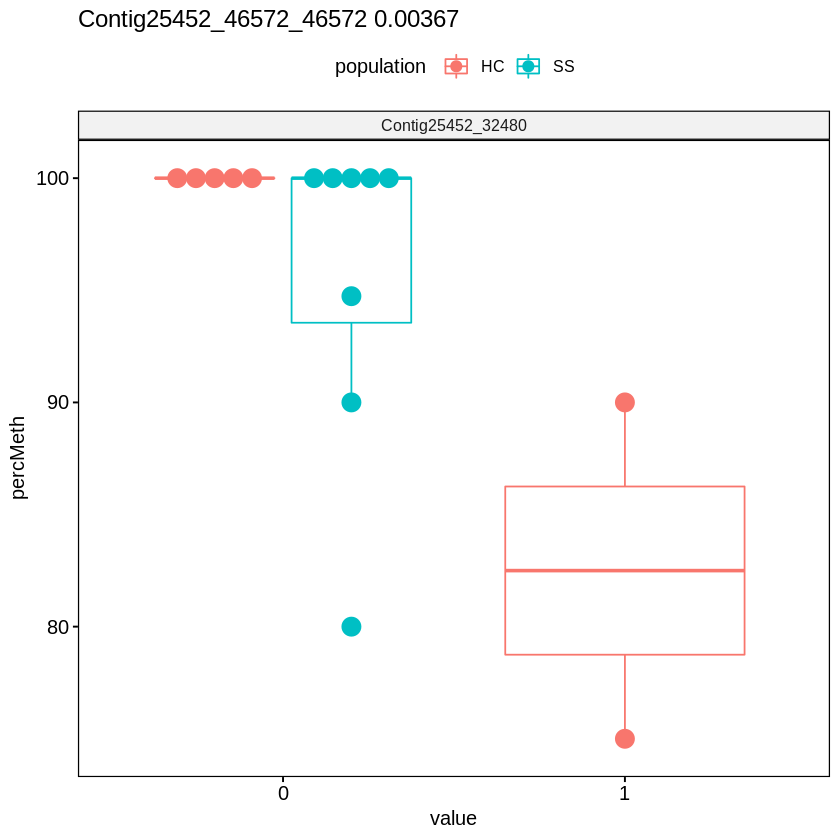

Warning message:
"Removed 4 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bindot)."


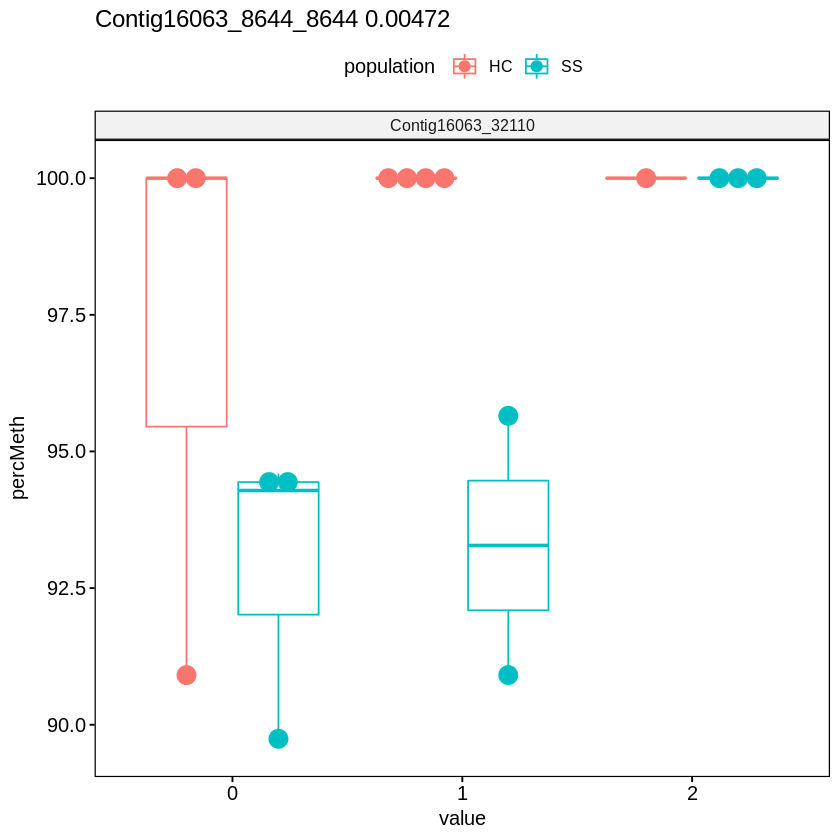

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


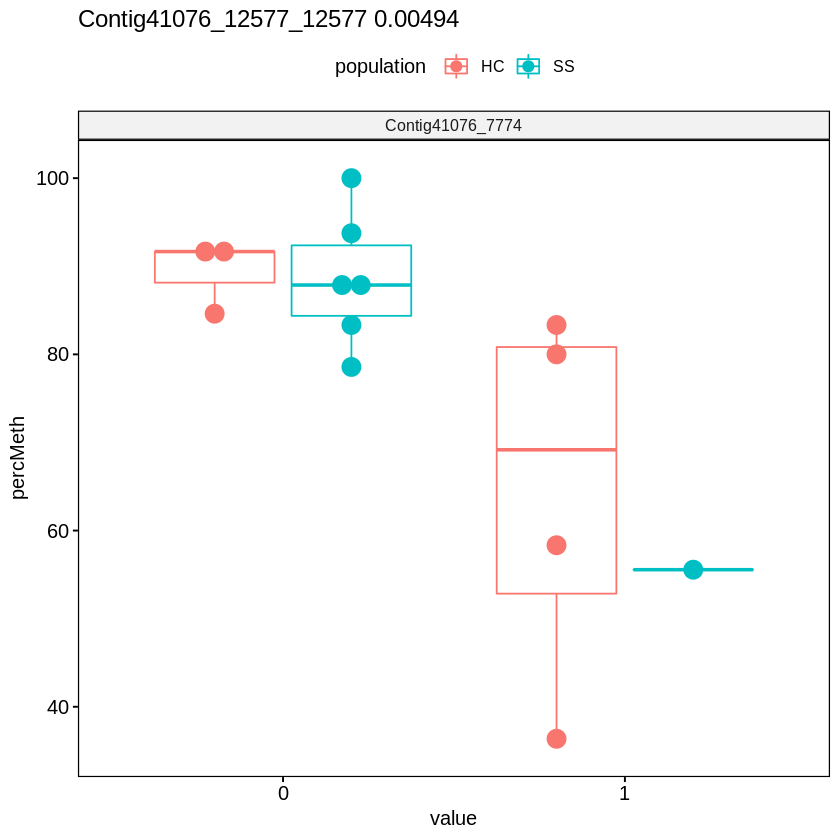

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


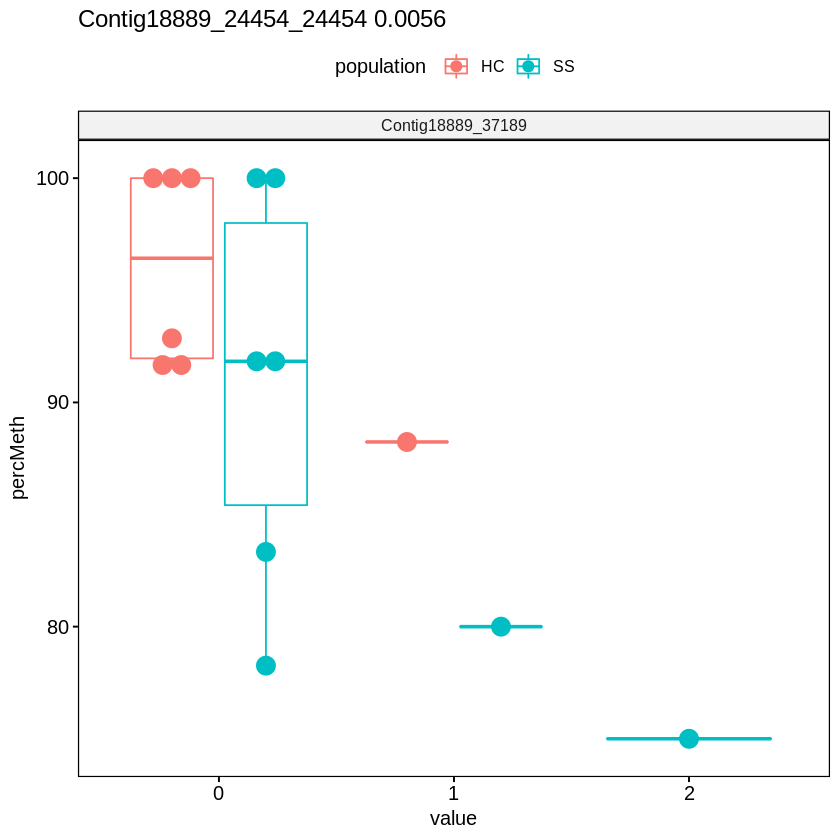

Warning message:
"Removed 4 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bindot)."


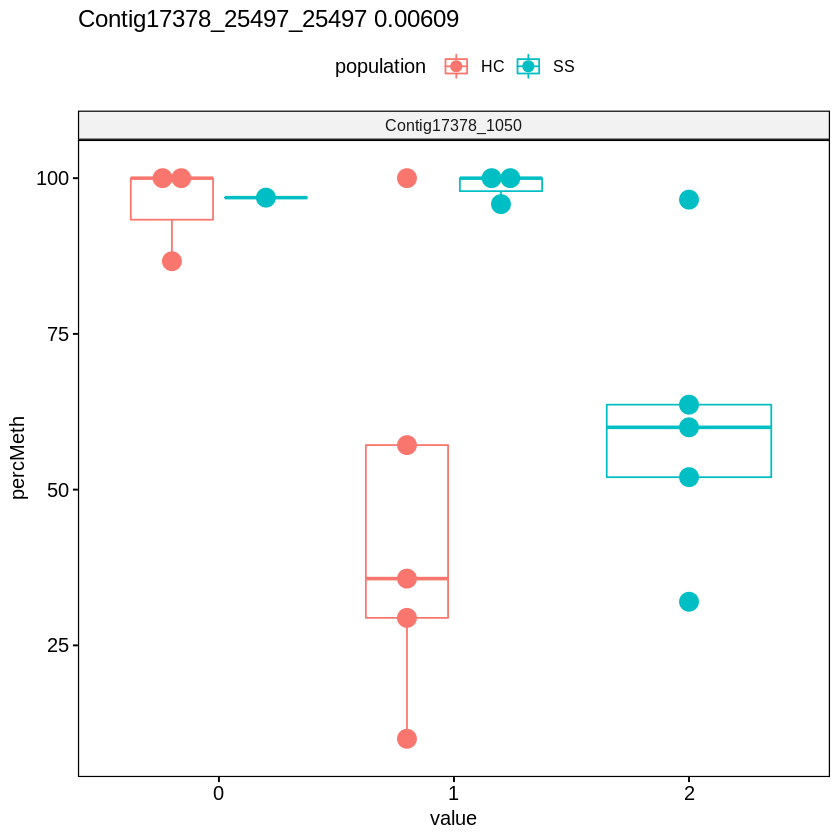

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


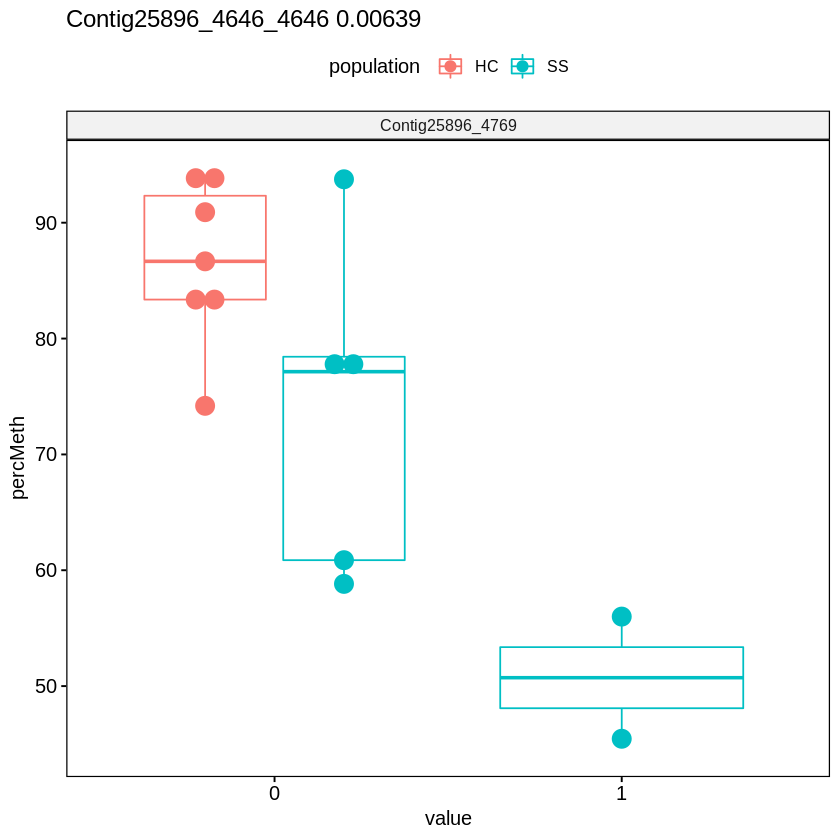

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


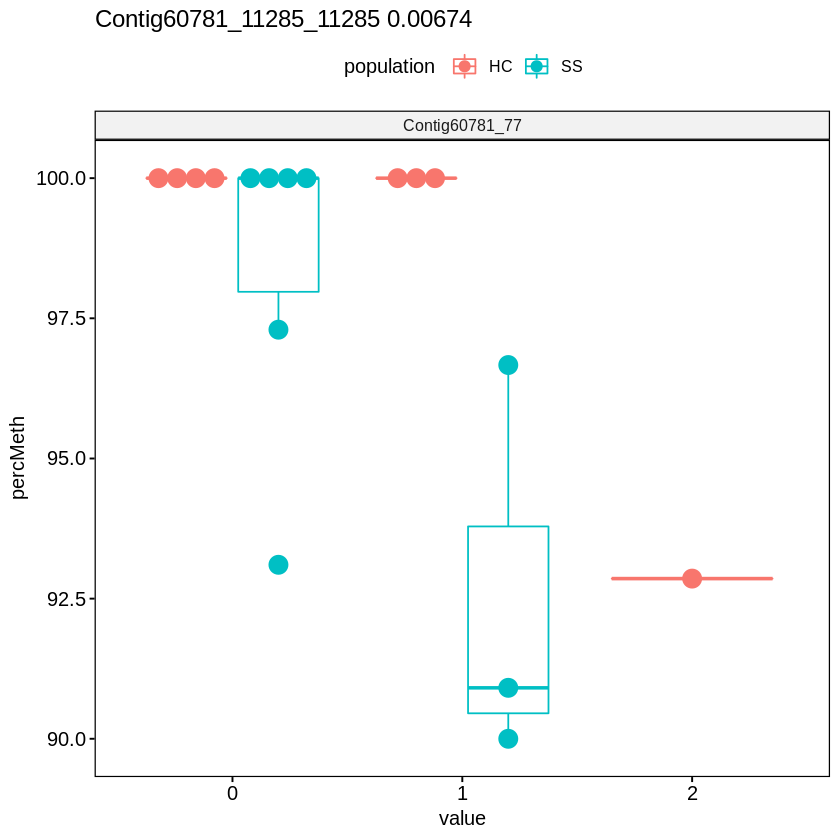

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



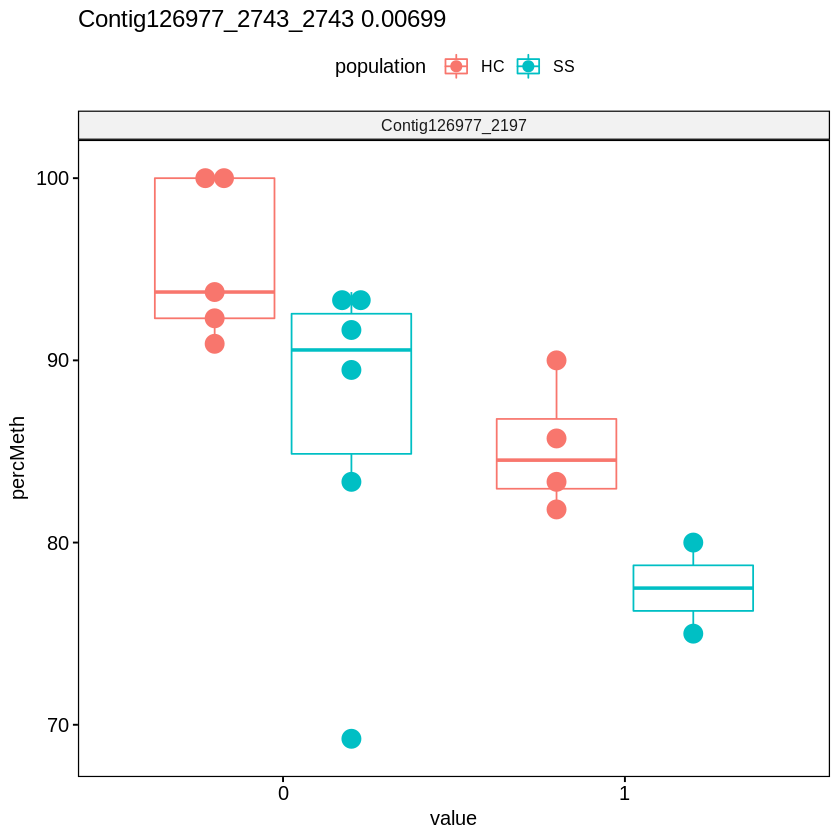

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


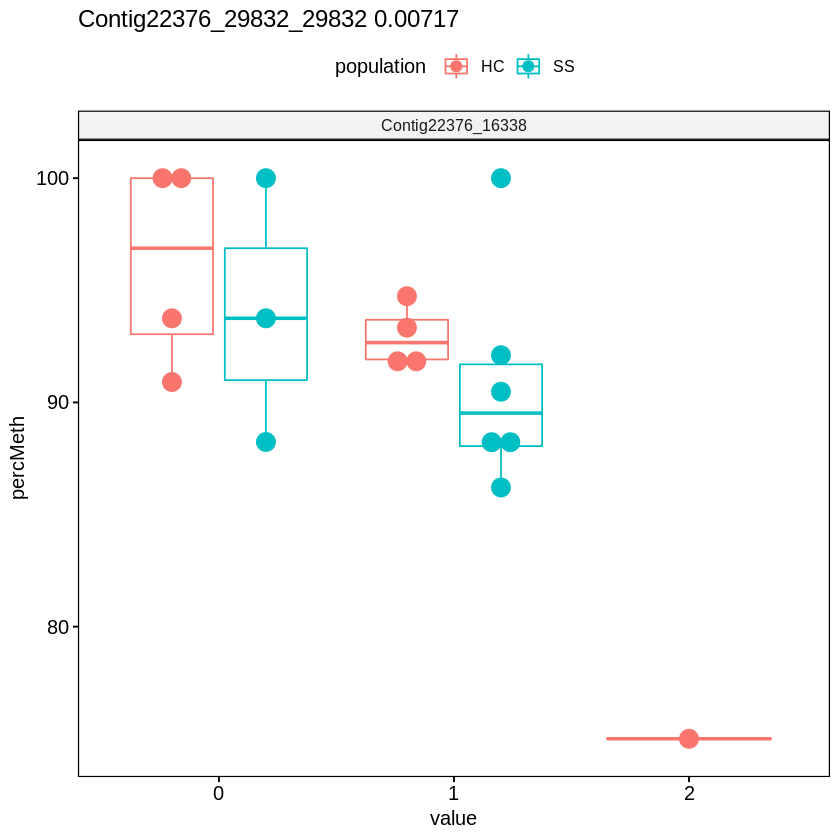

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


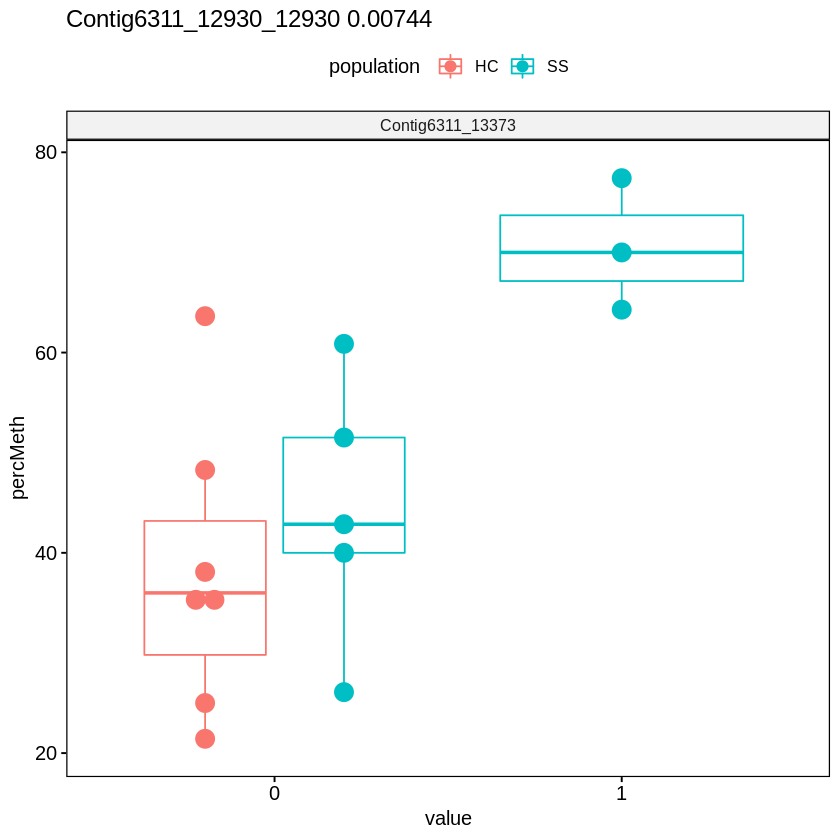

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


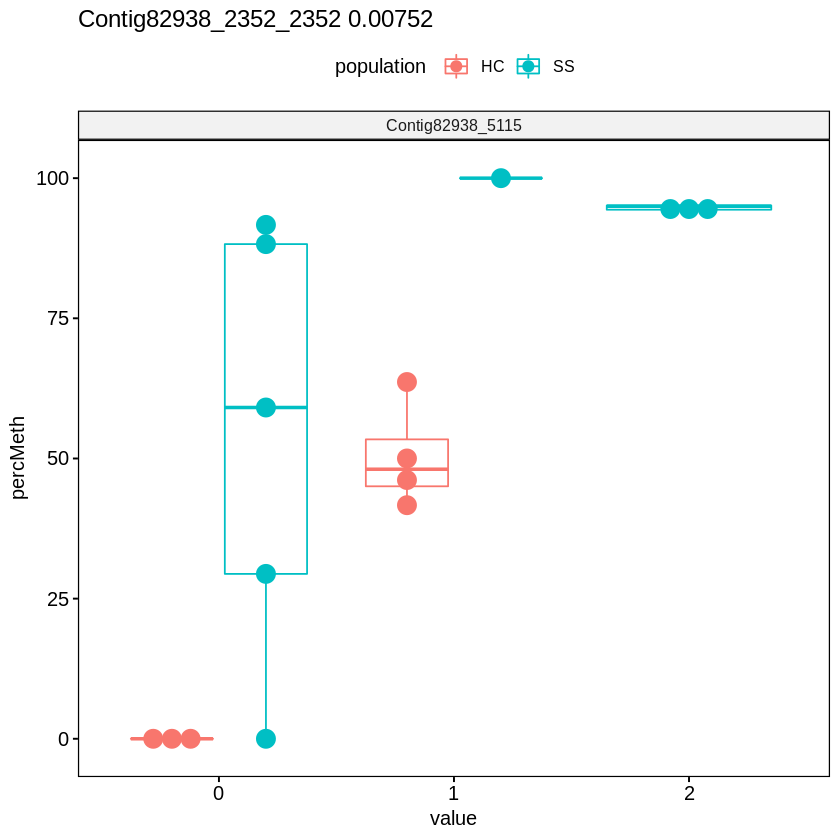

Warning message:
"Removed 4 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bindot)."


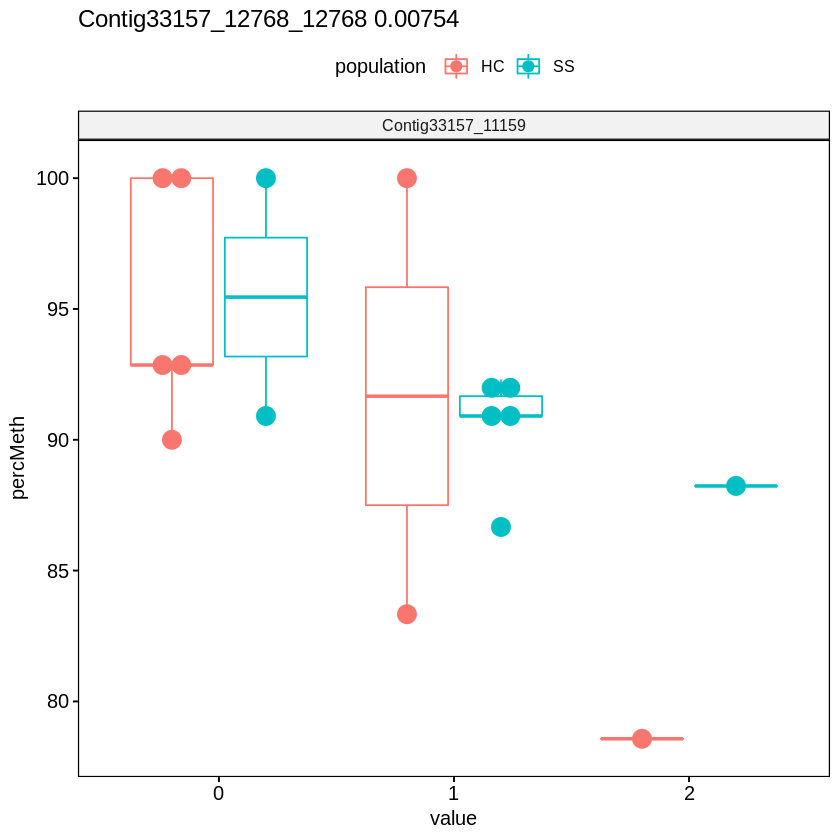

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



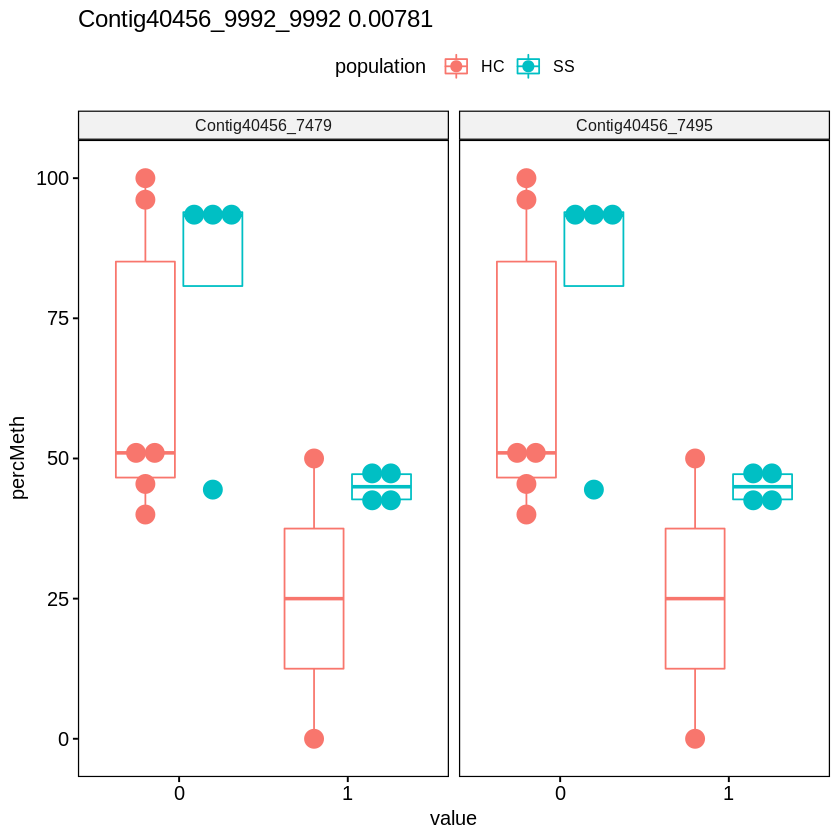

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


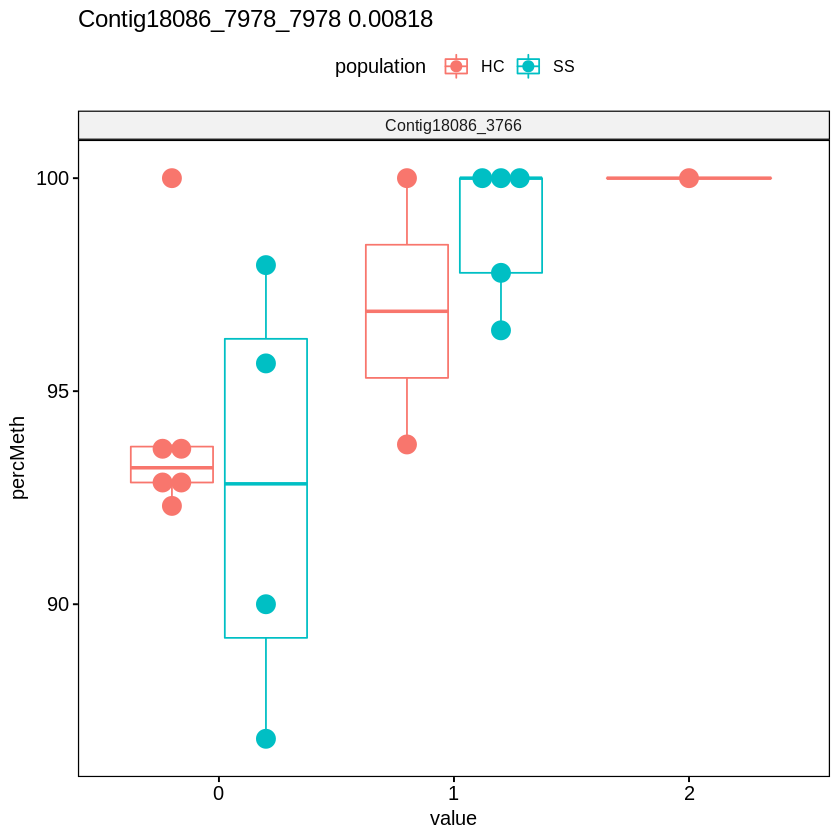

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



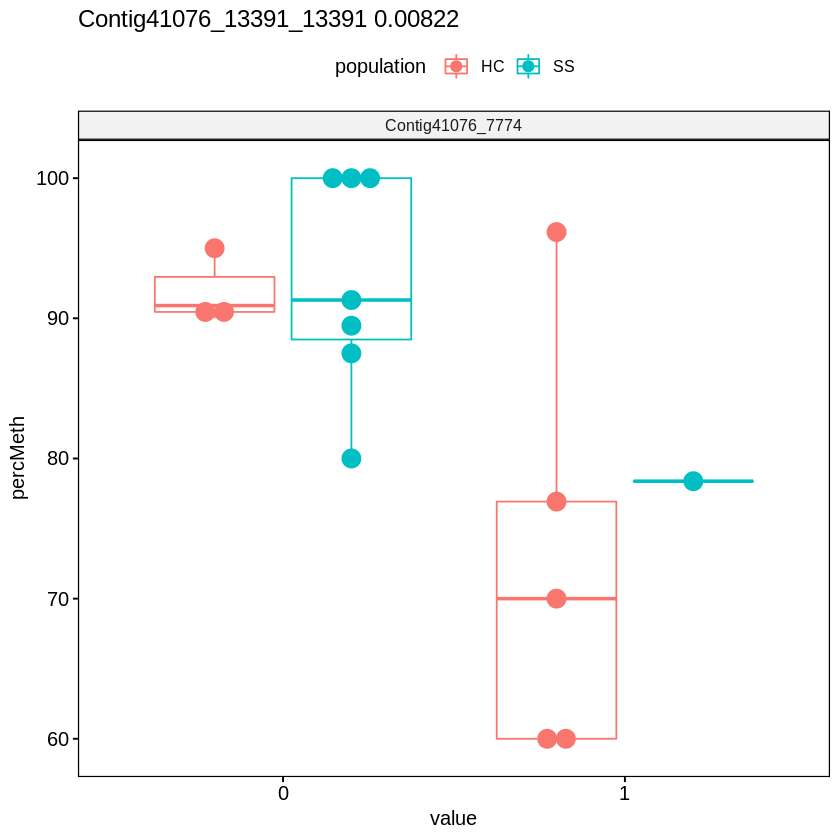

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


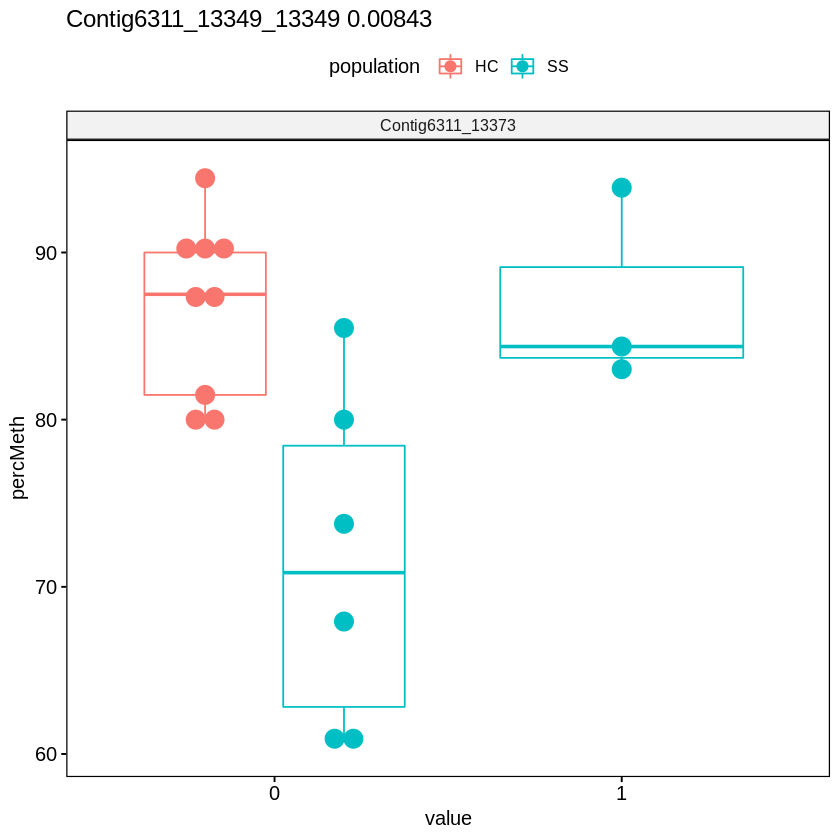

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



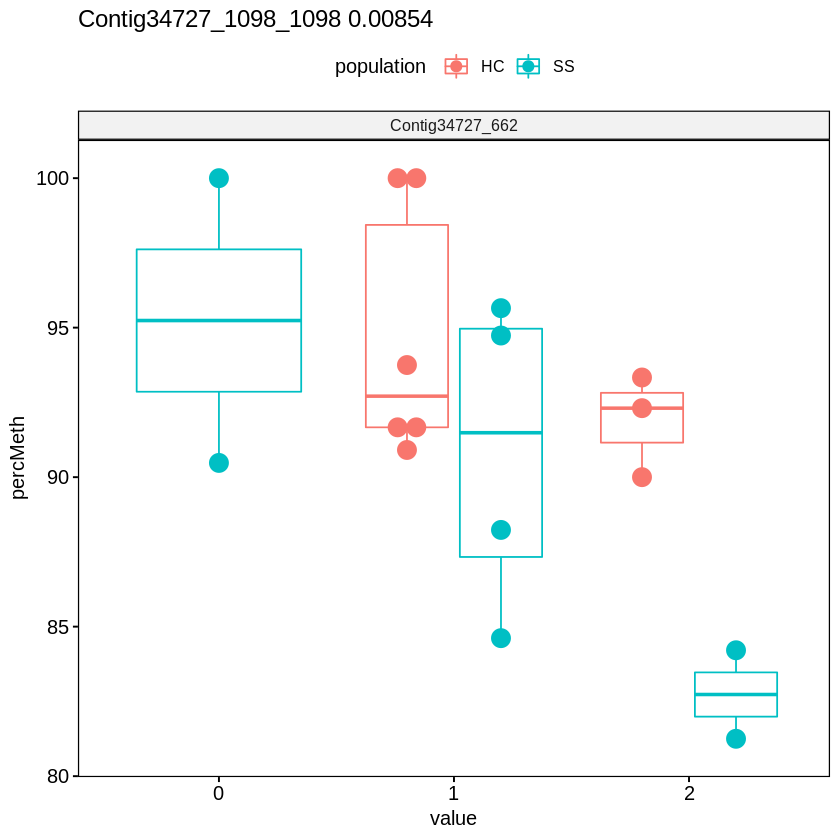

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


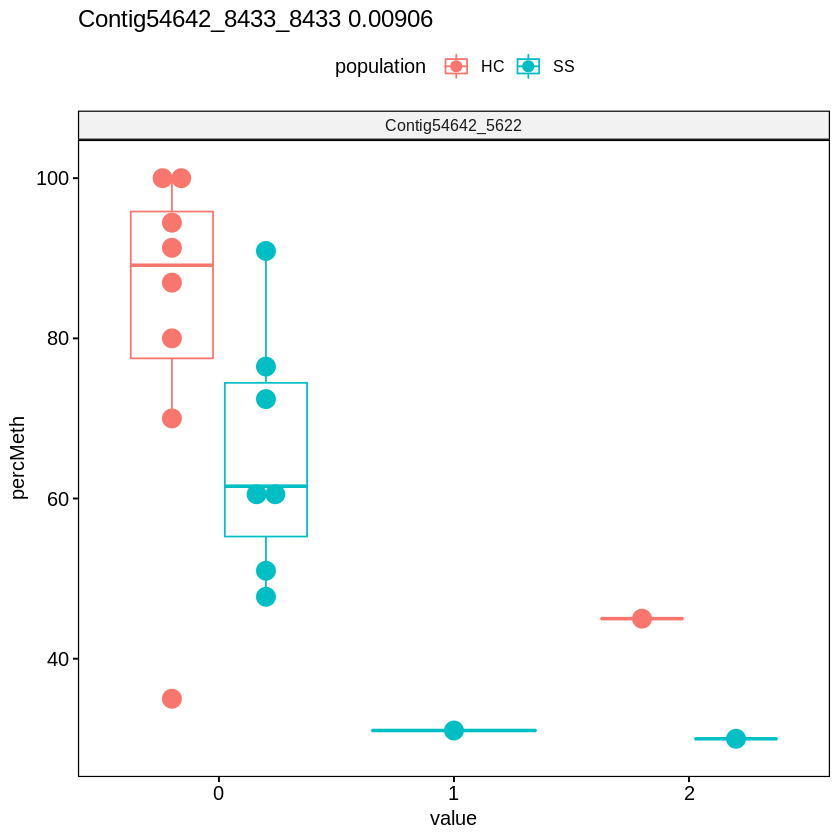

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


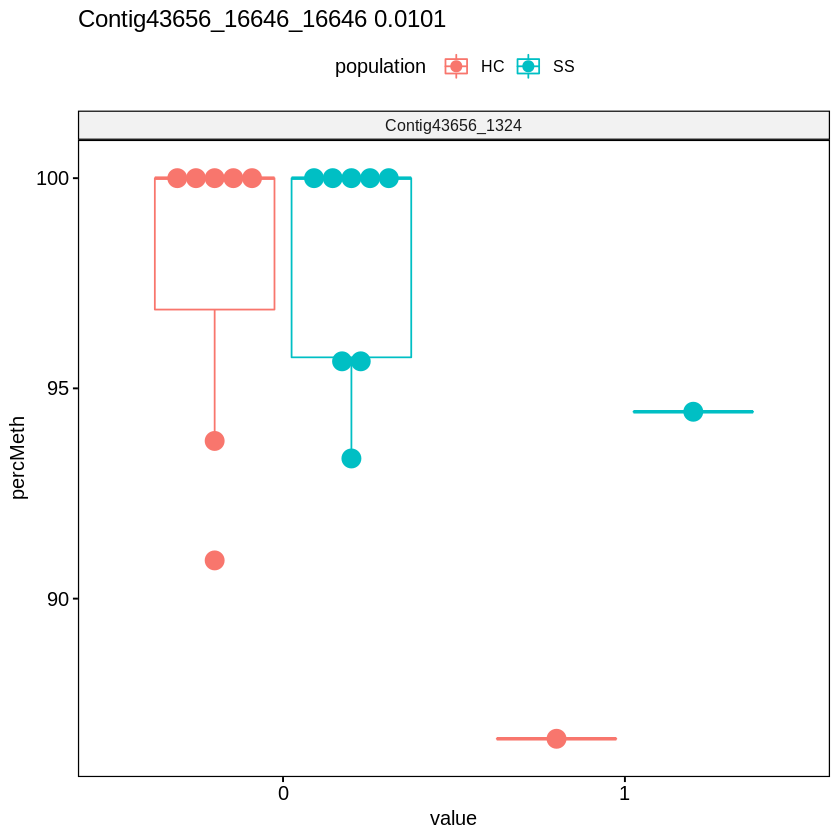

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


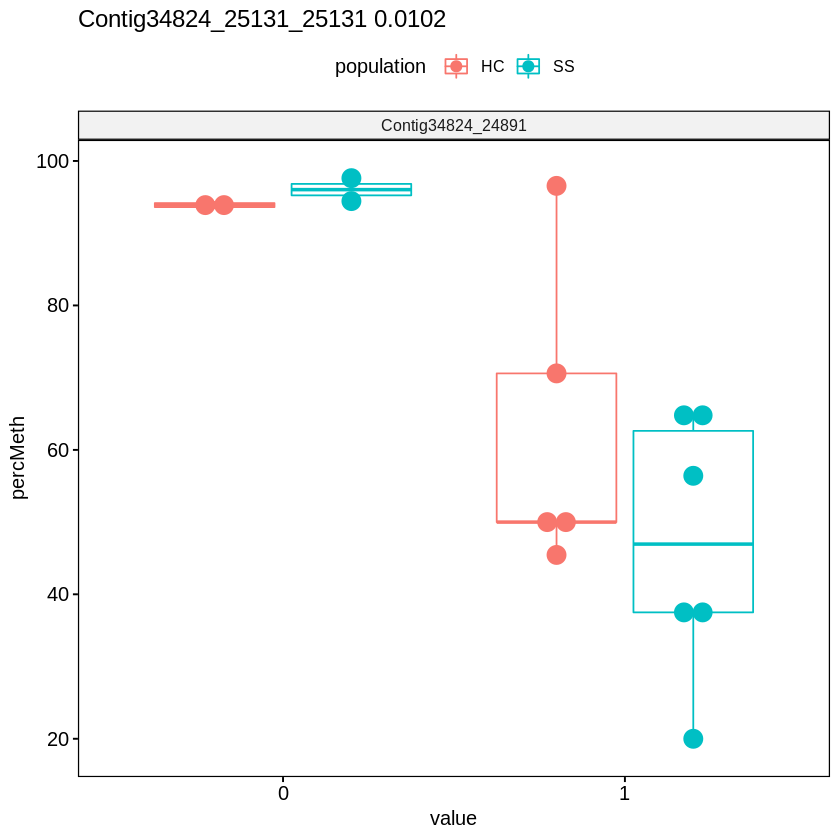

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


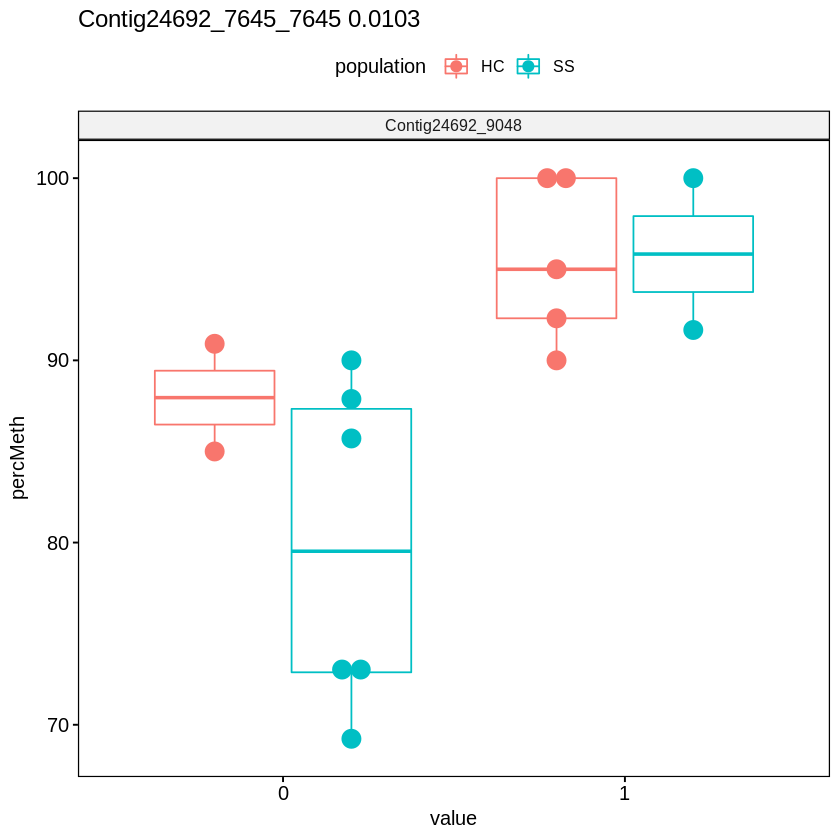

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



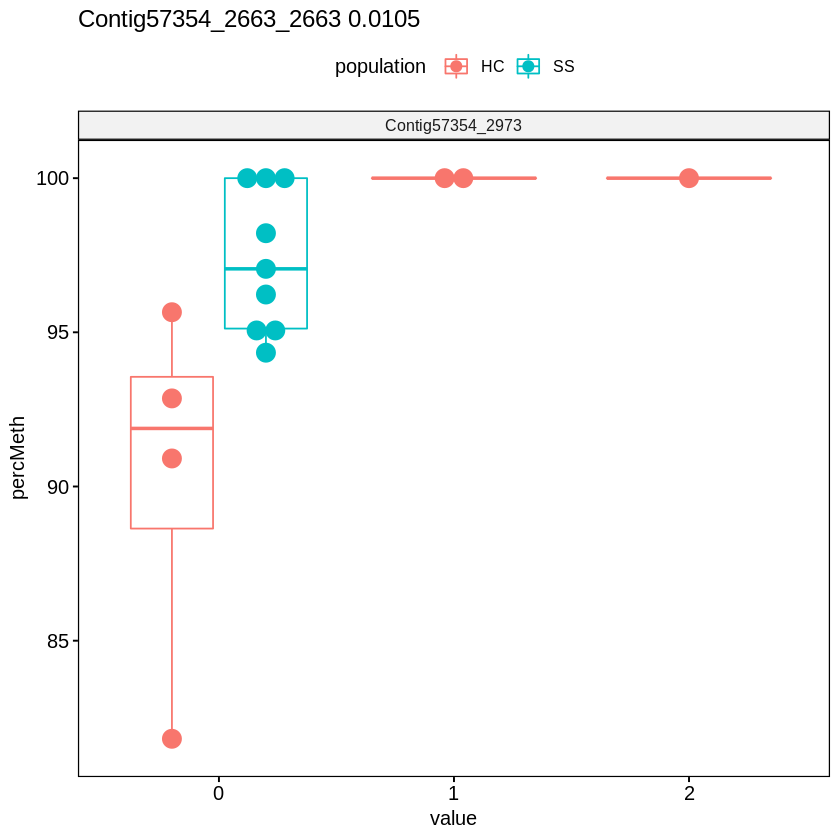

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


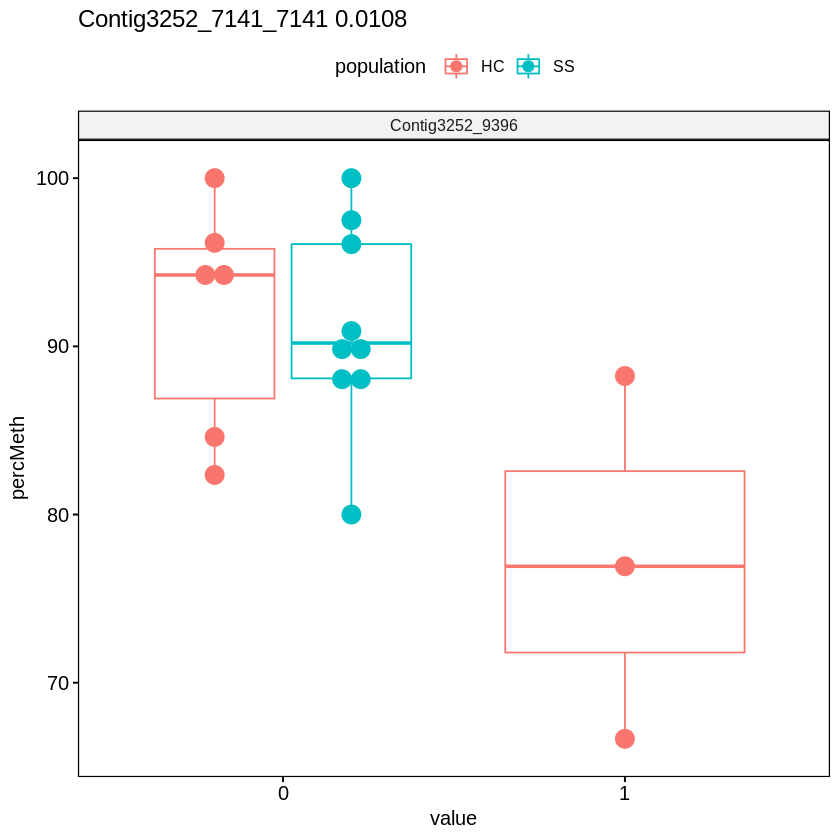

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



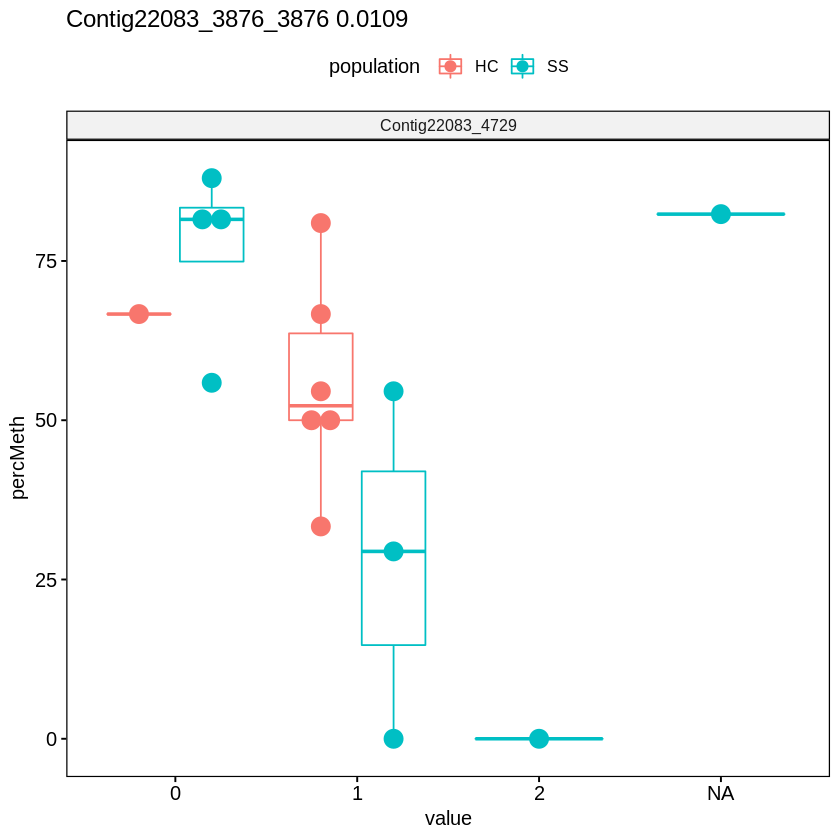

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



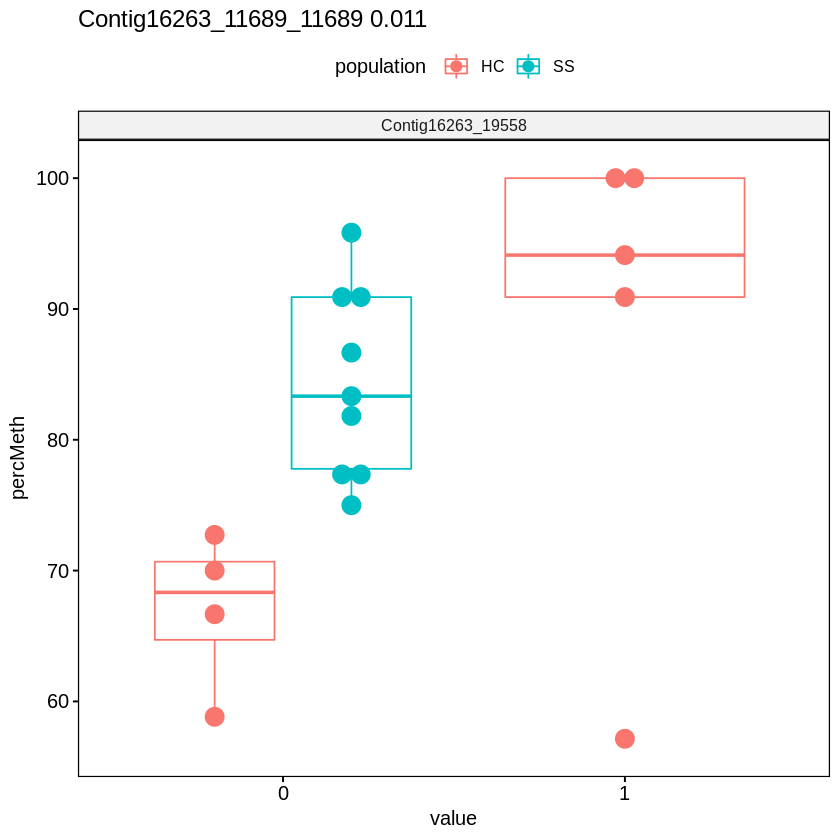

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


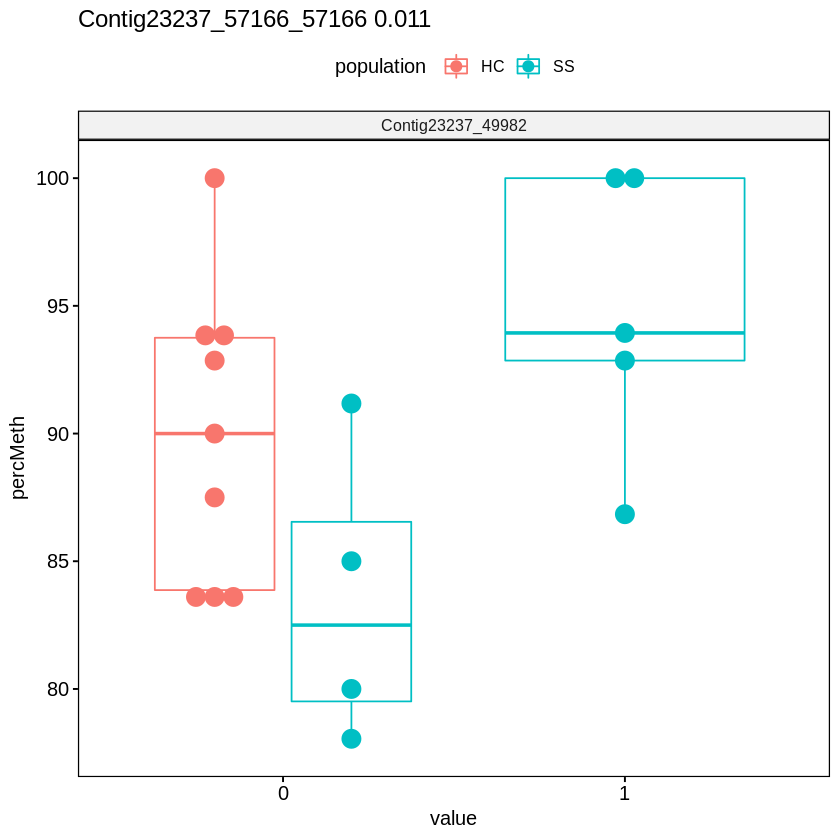

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



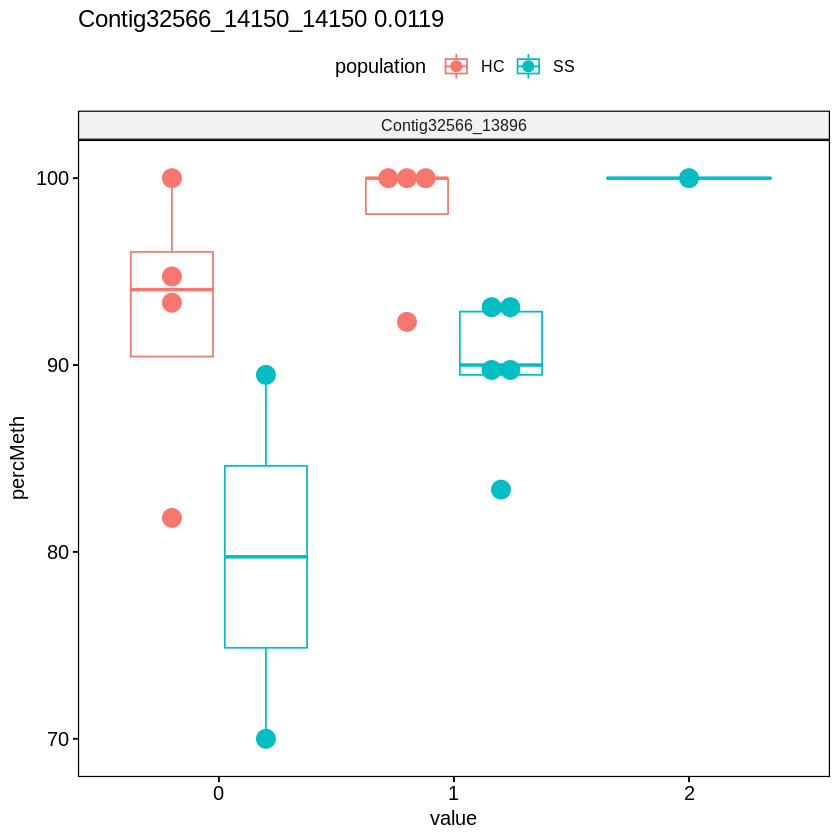

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


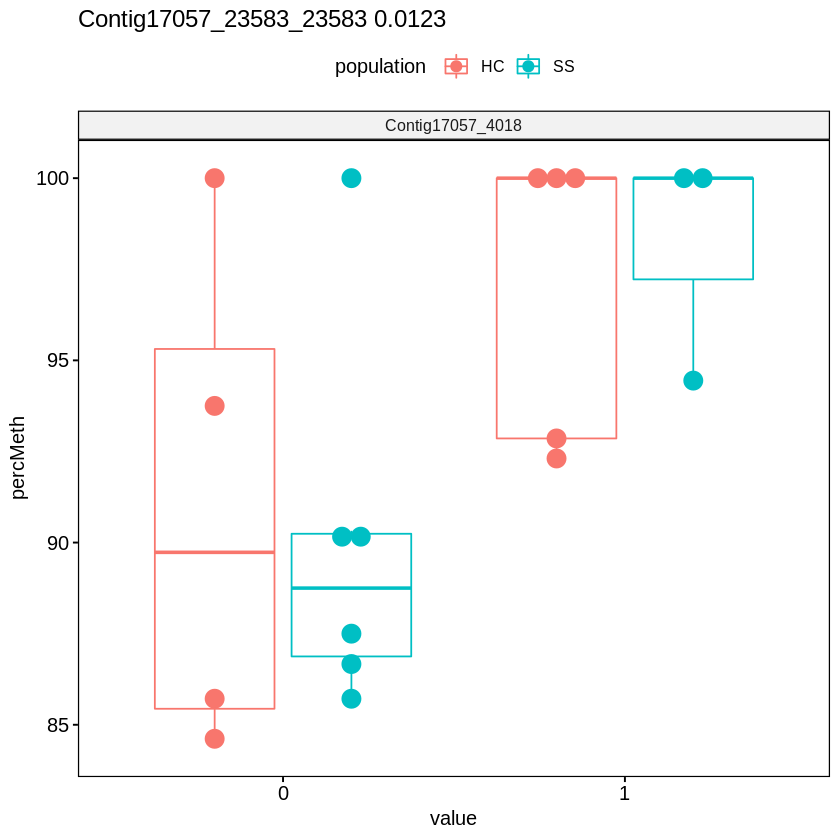

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


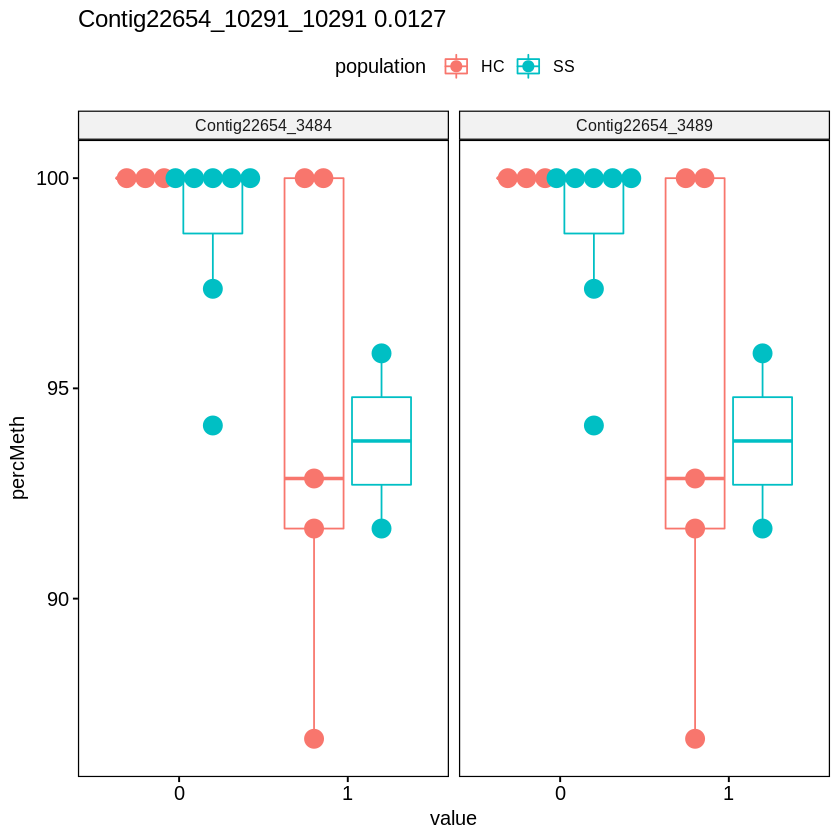

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


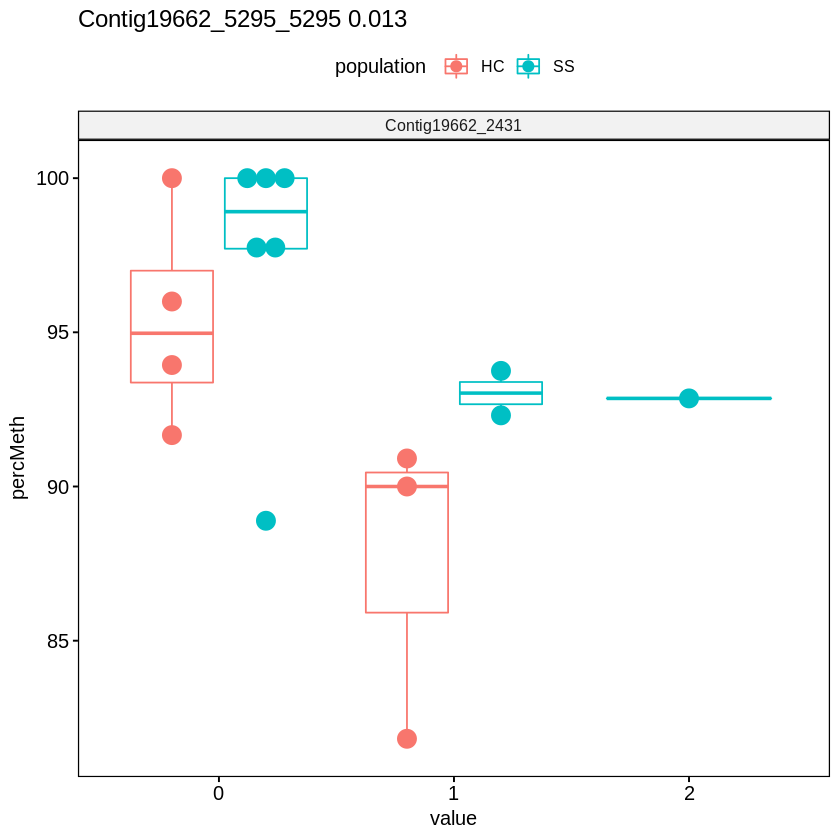

Warning message:
"Removed 4 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bindot)."


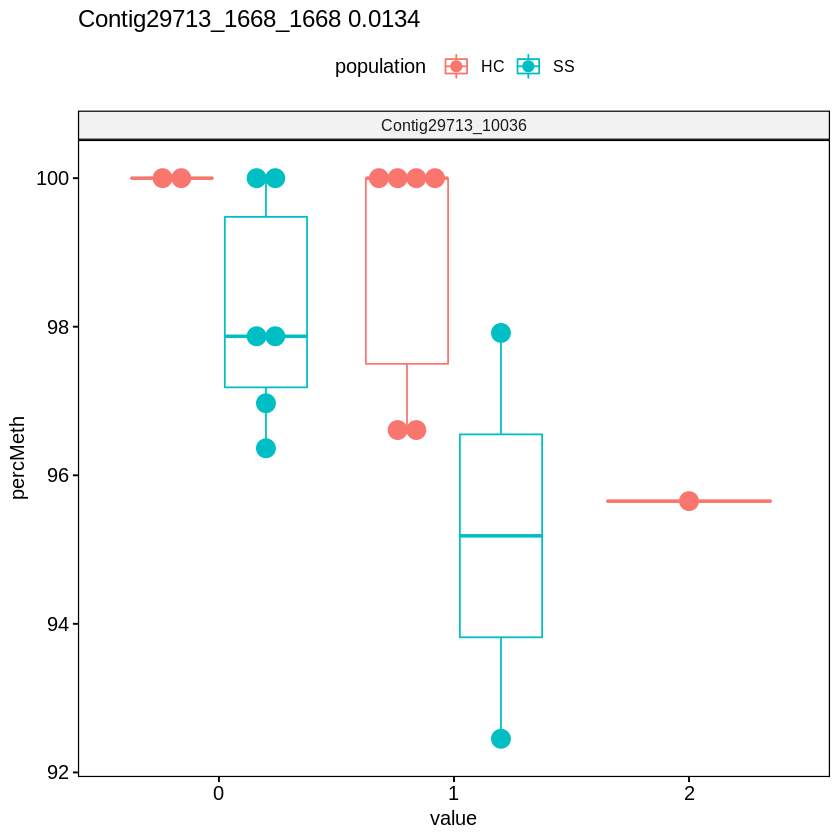

Warning message:
"Removed 6 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 6 rows containing non-finite values (stat_bindot)."


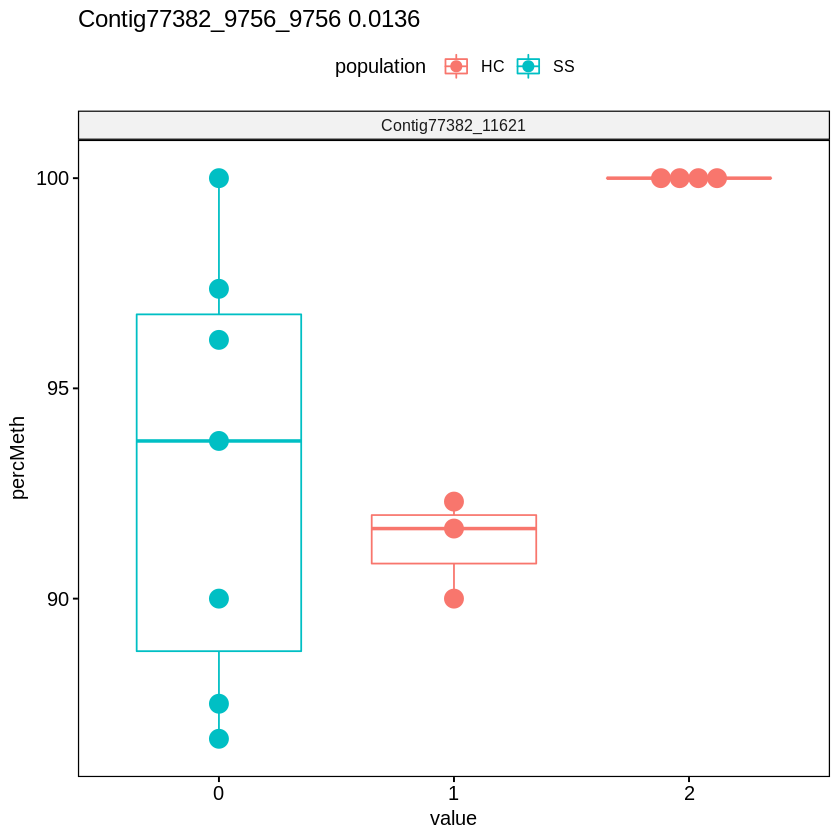

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


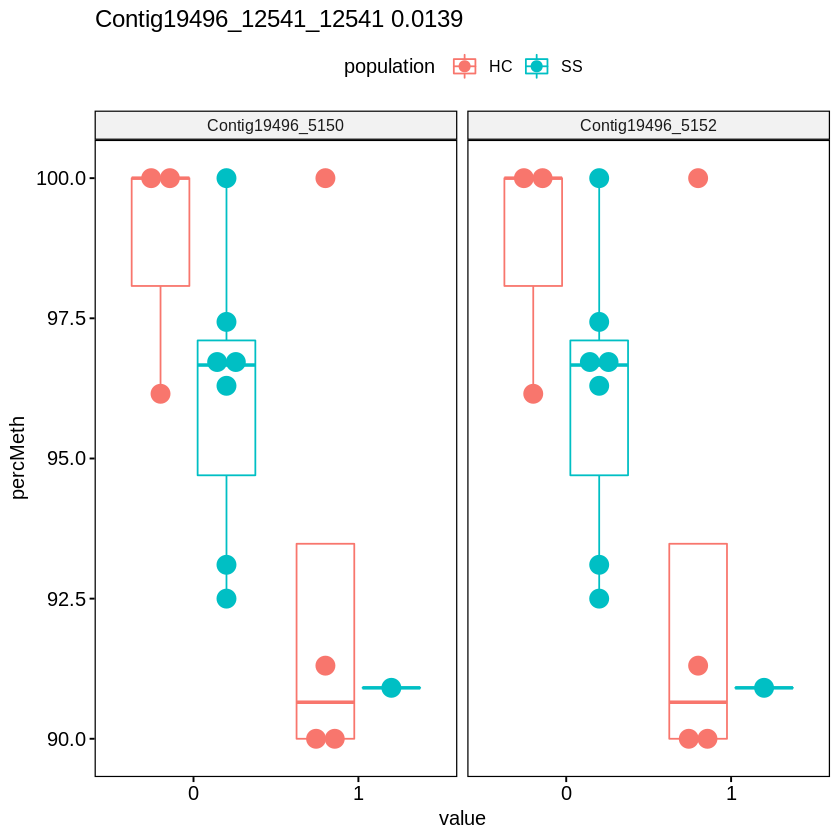

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



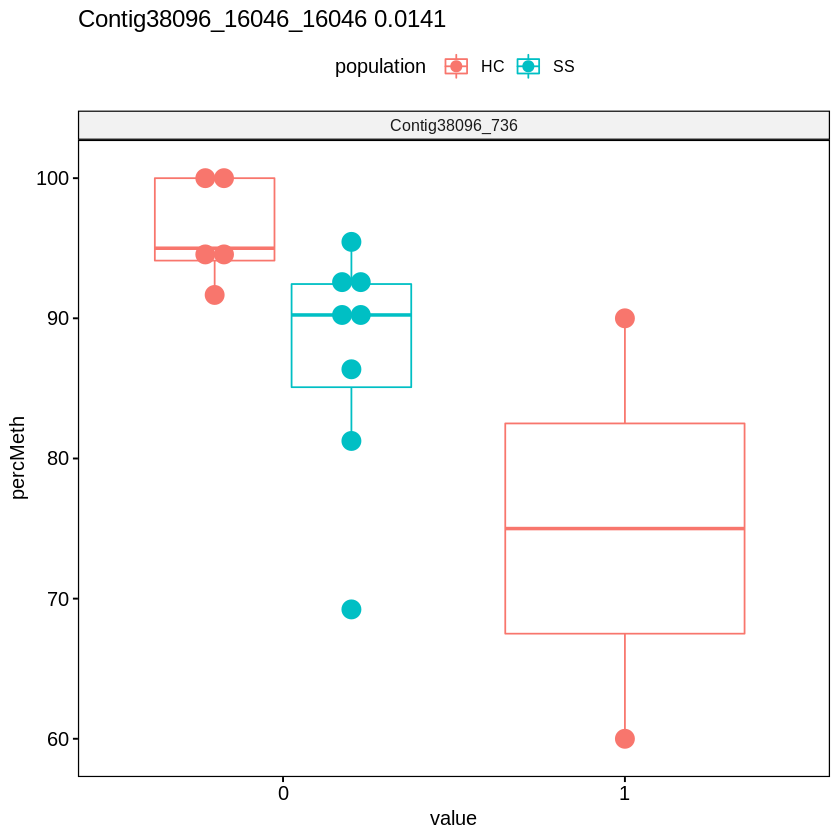

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


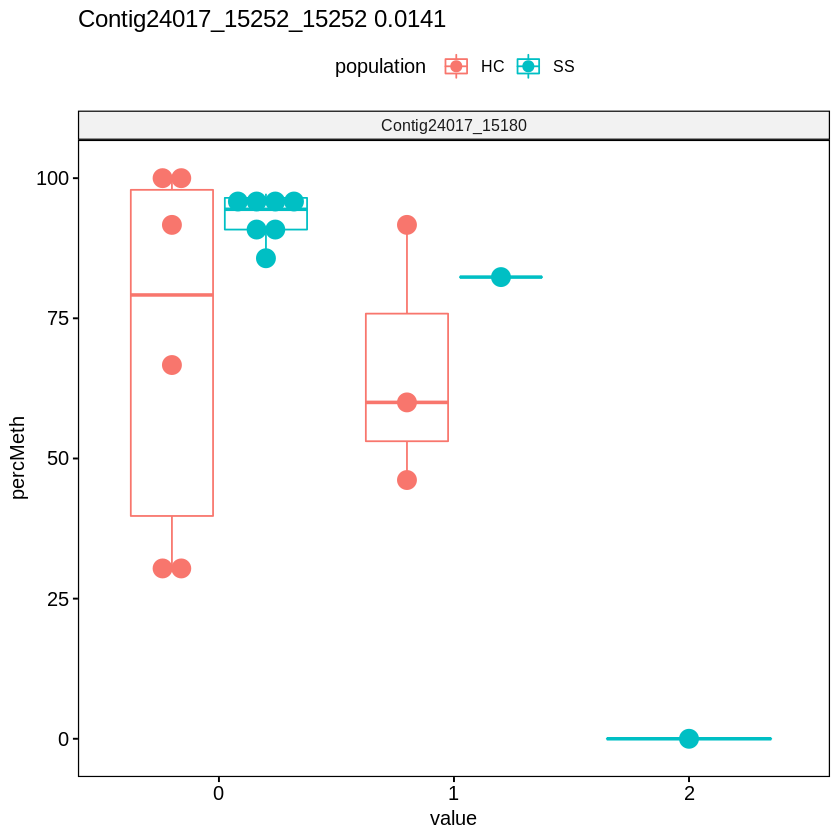

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


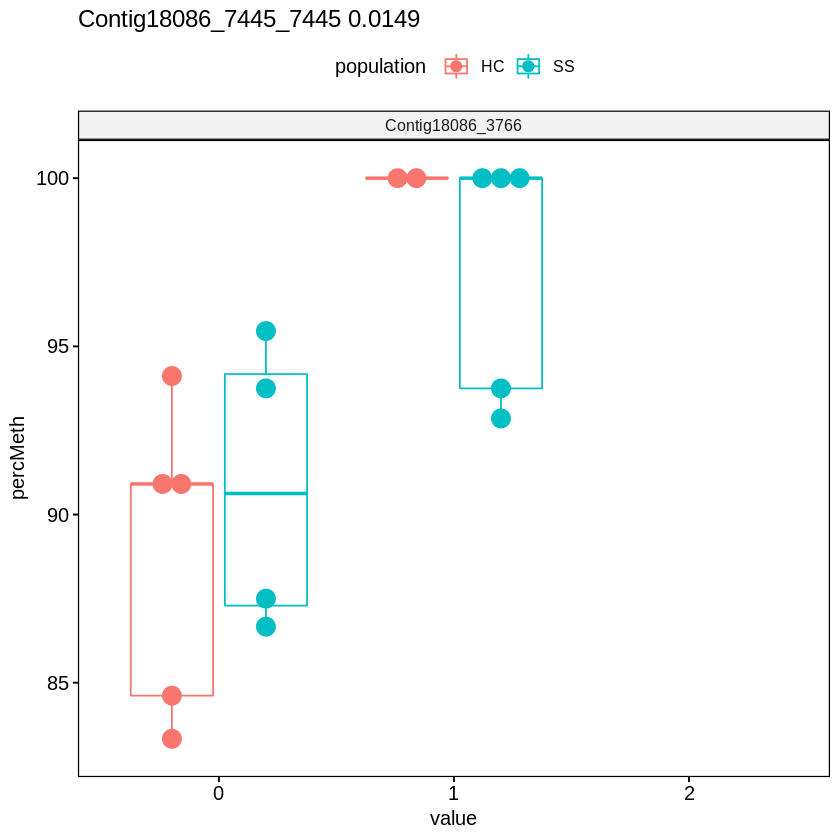

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


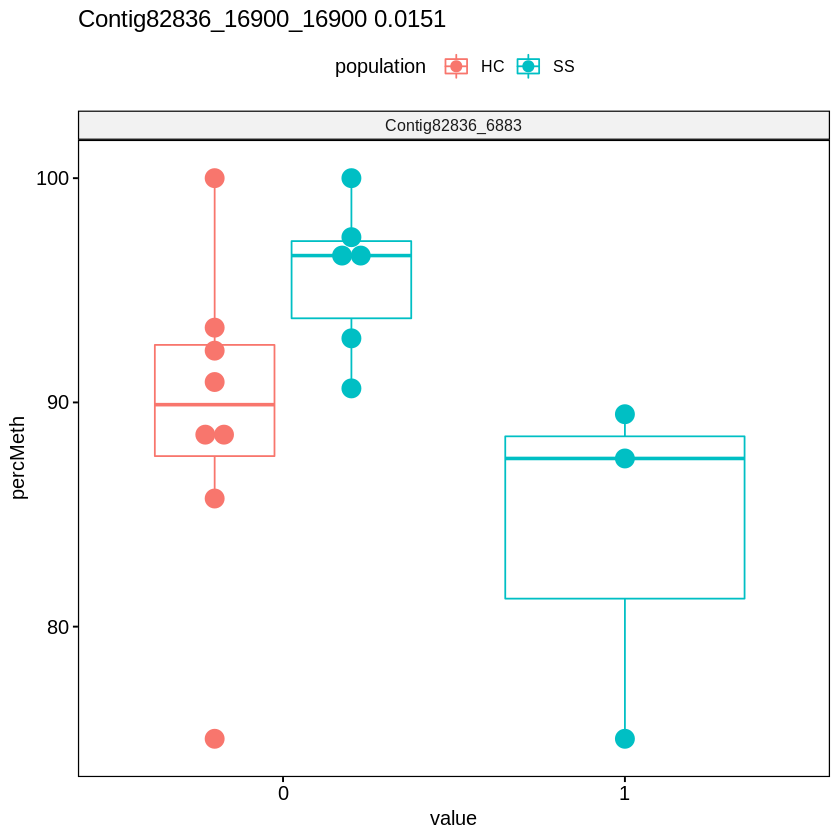

Warning message:
"Removed 4 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bindot)."


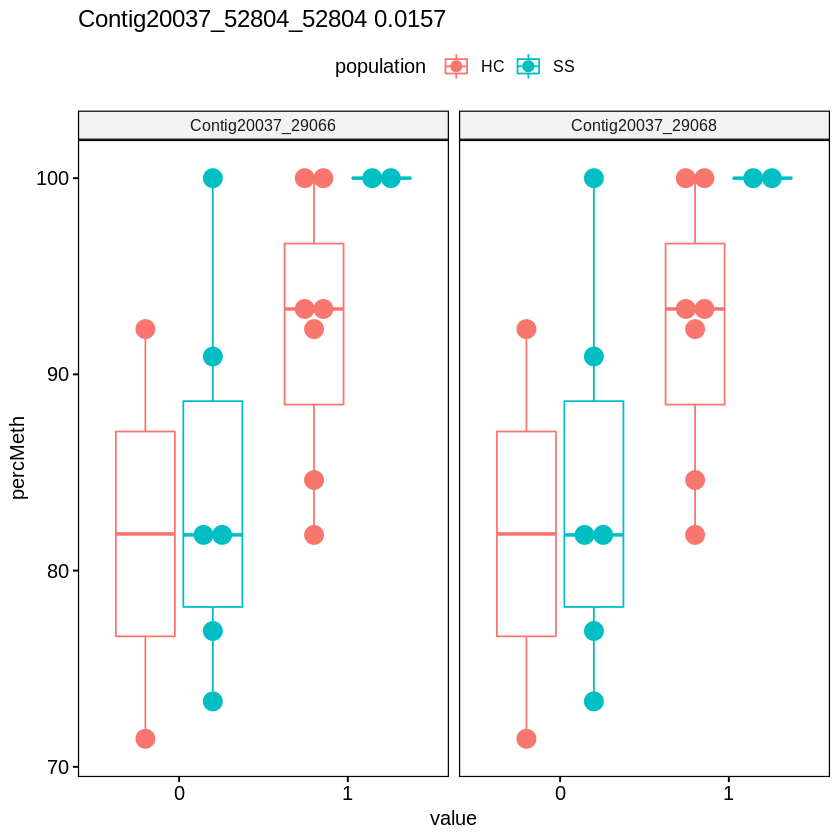

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


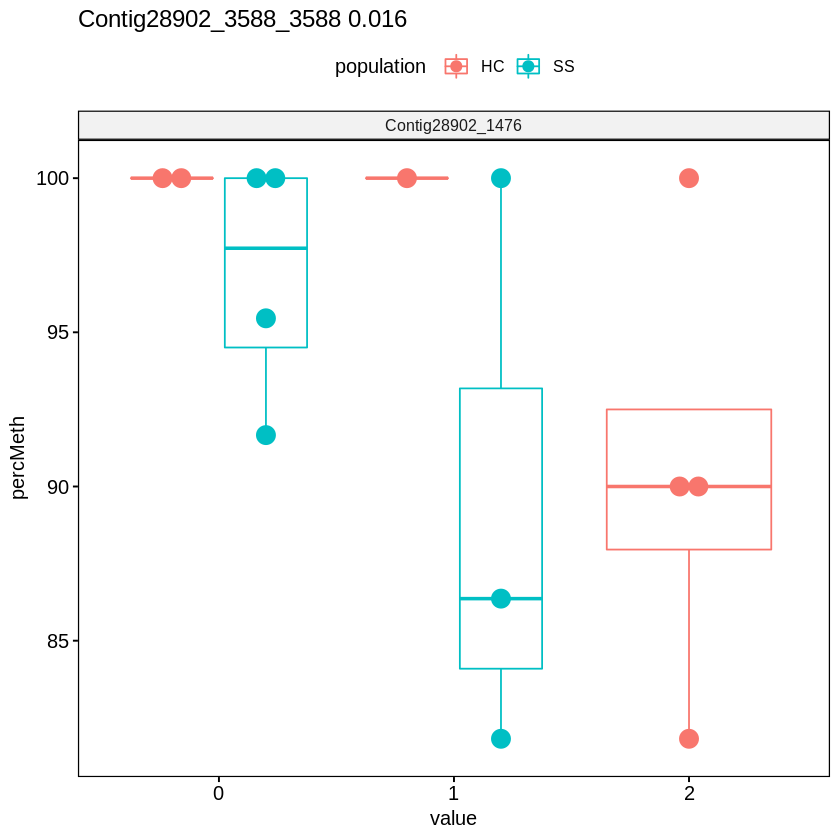

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


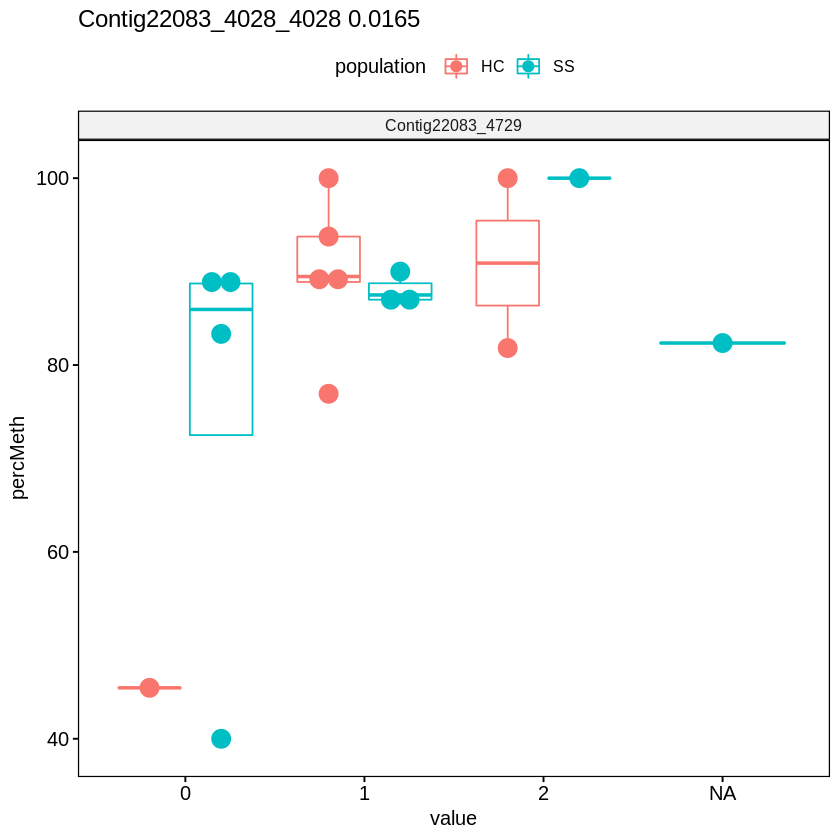

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


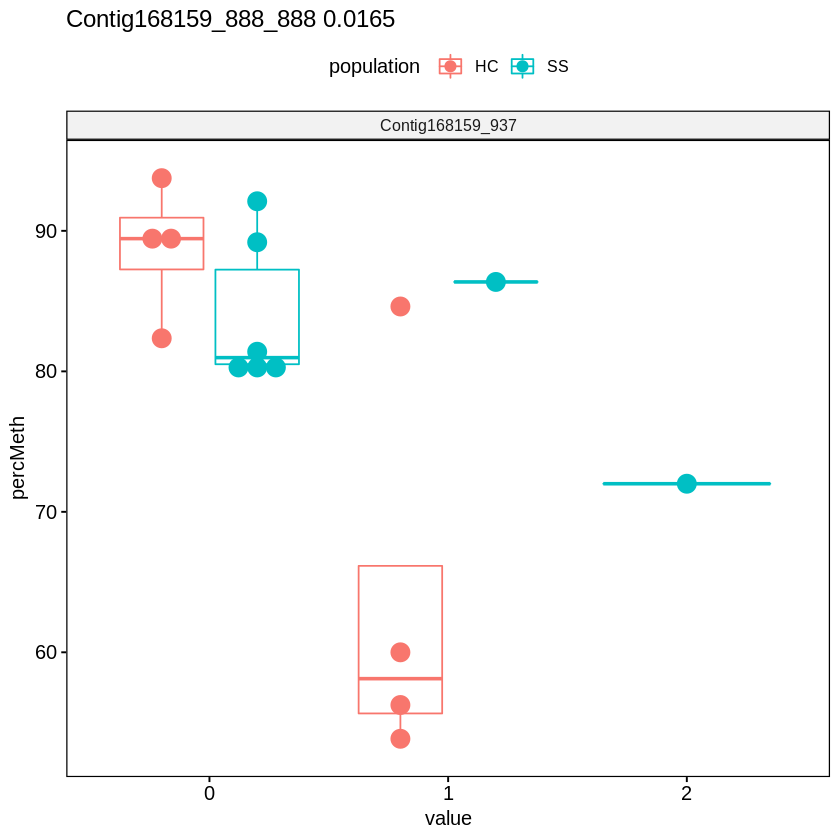

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


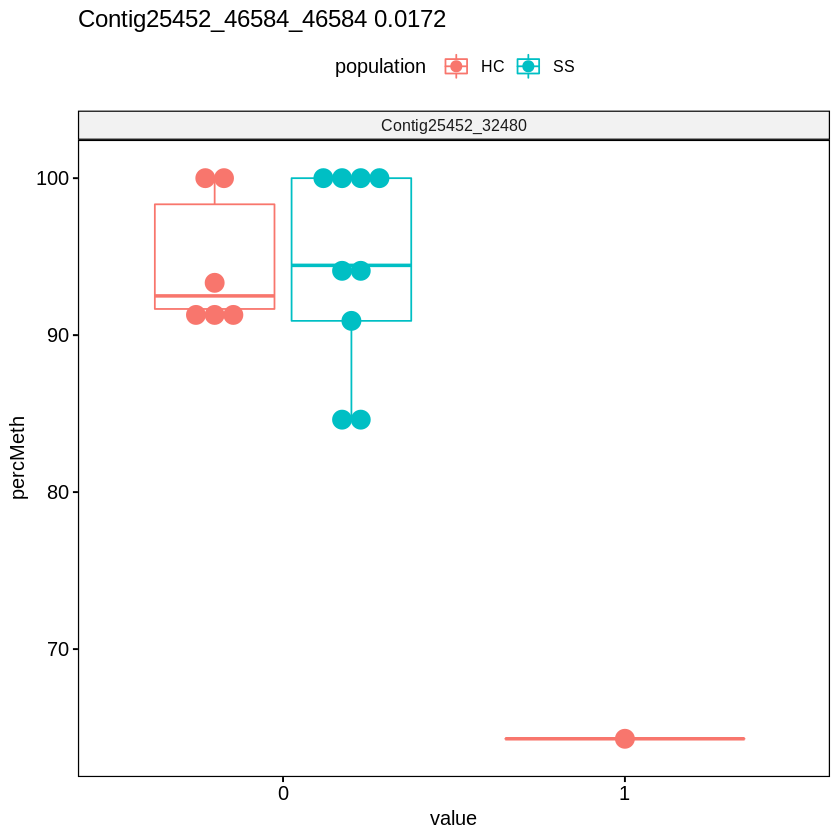

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


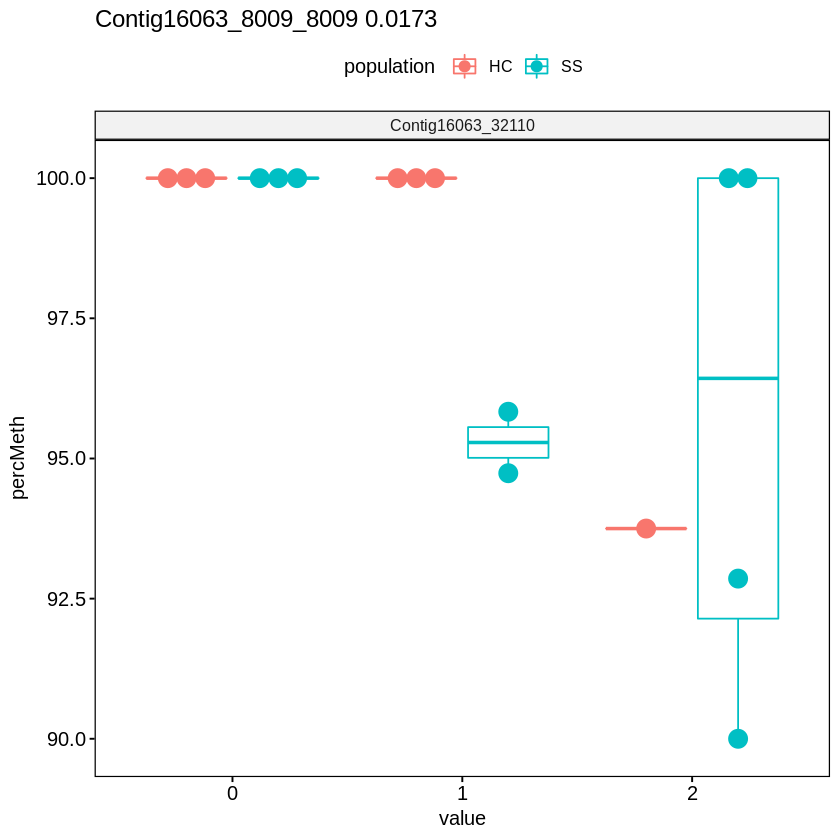

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



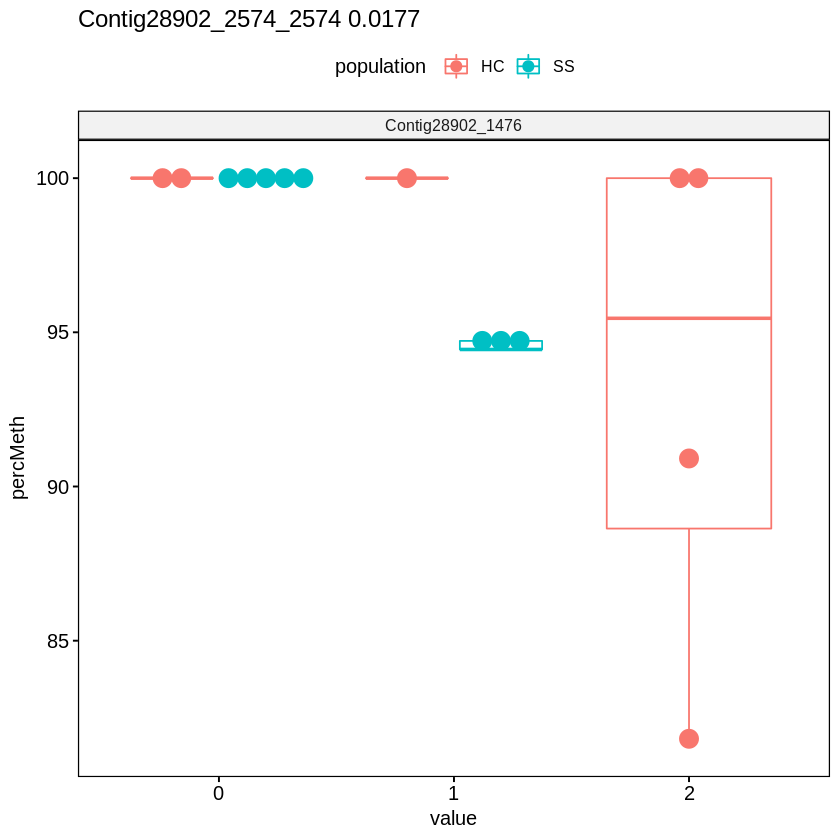

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


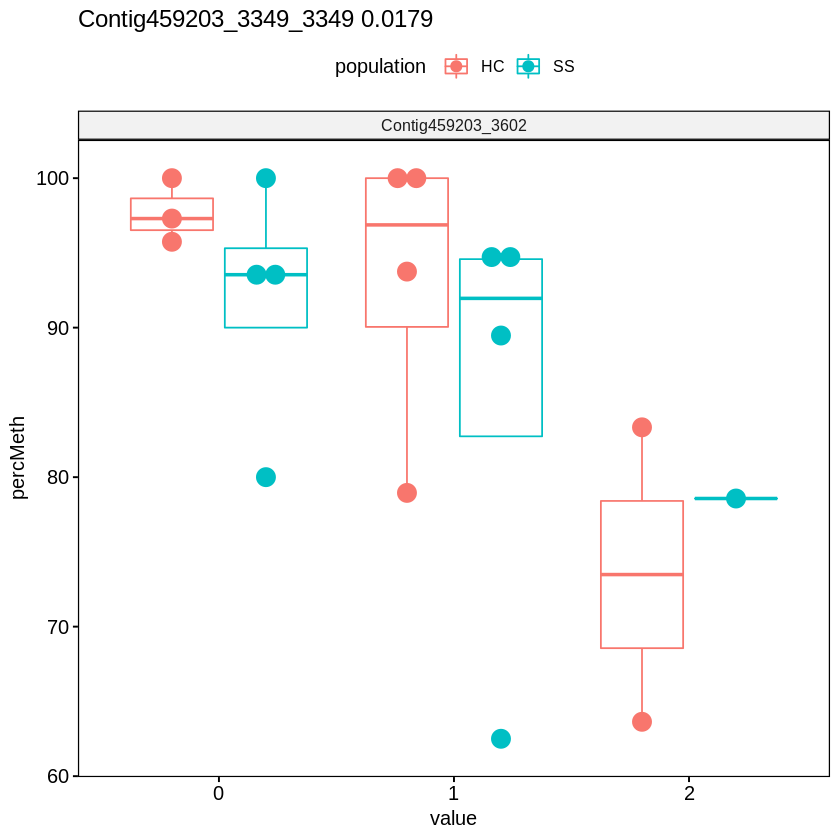

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


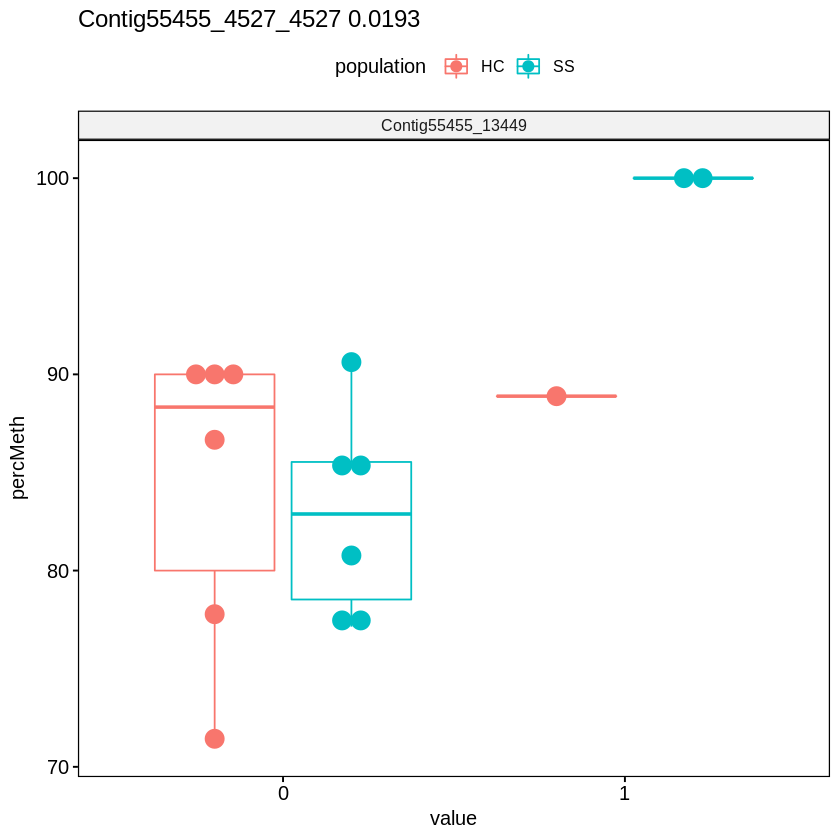

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


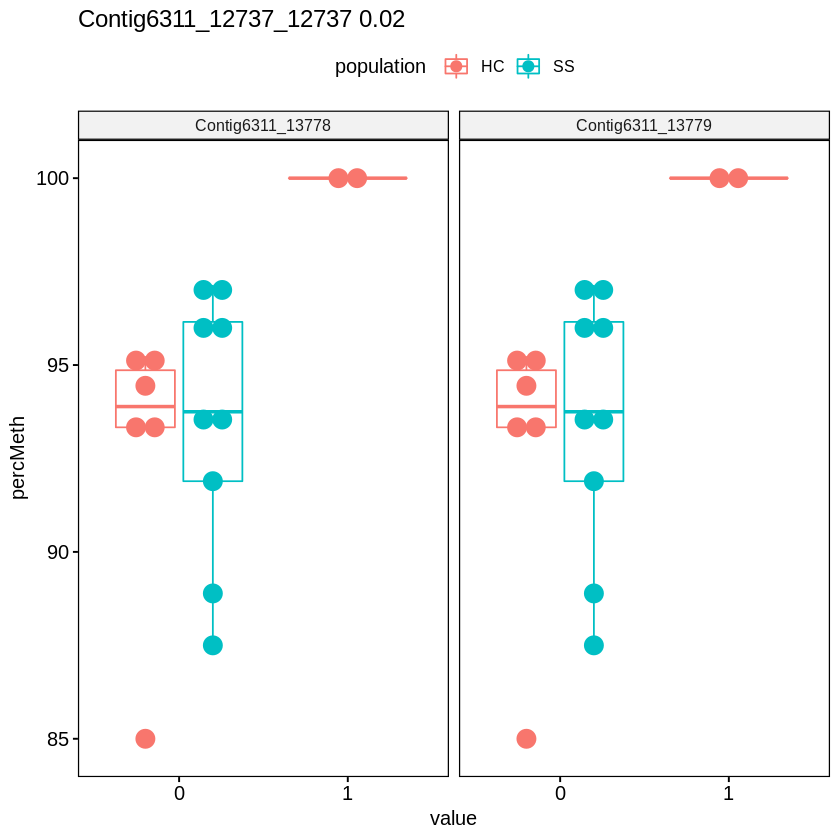

Warning message:
"Removed 6 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 6 rows containing non-finite values (stat_bindot)."


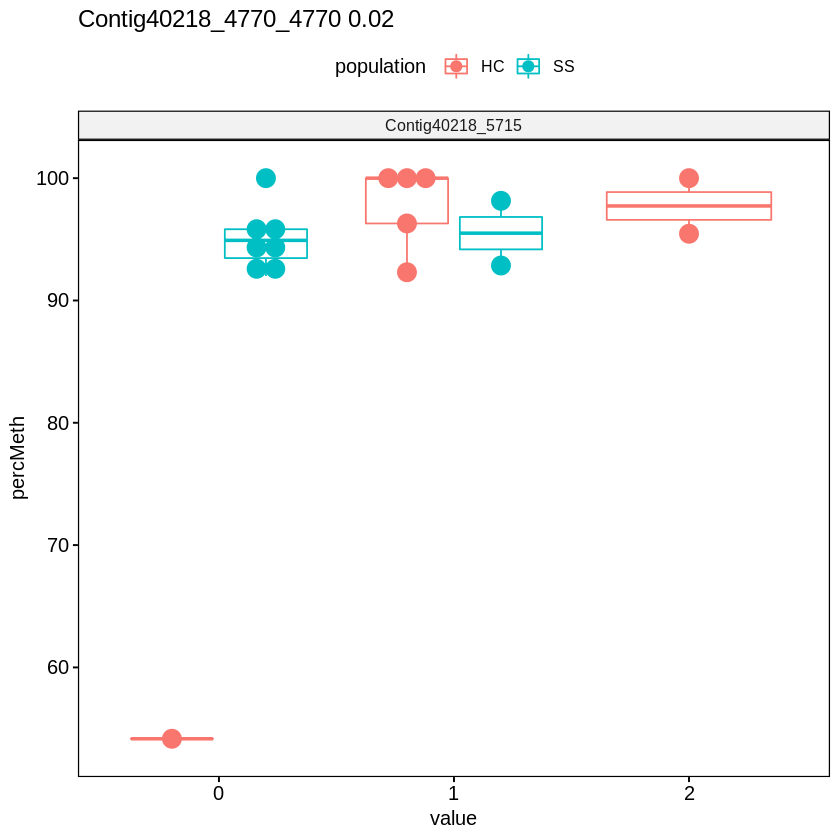

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


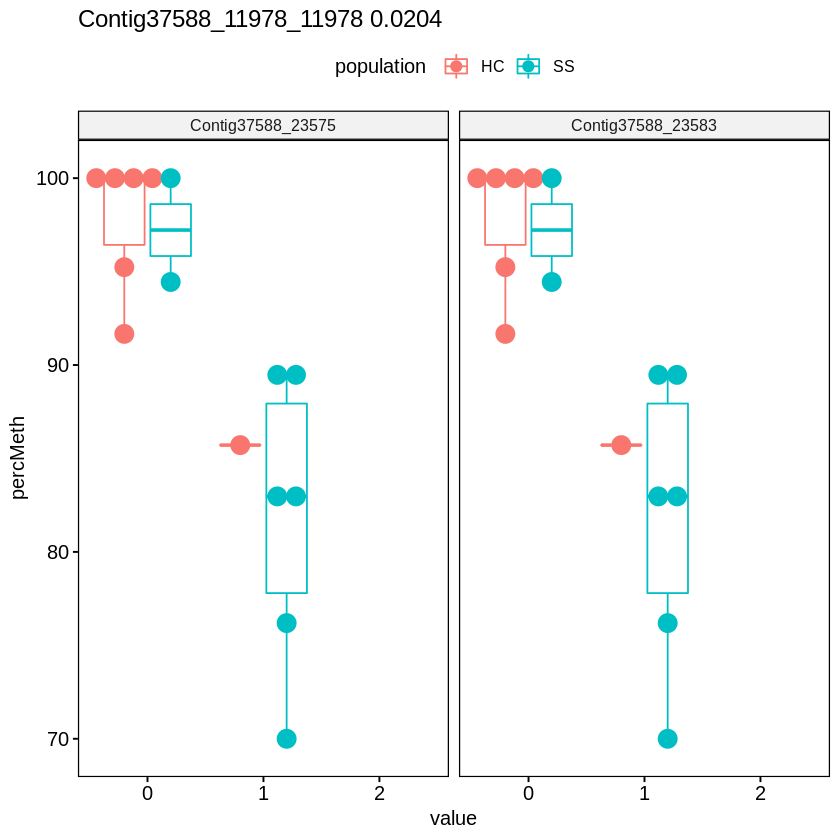

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


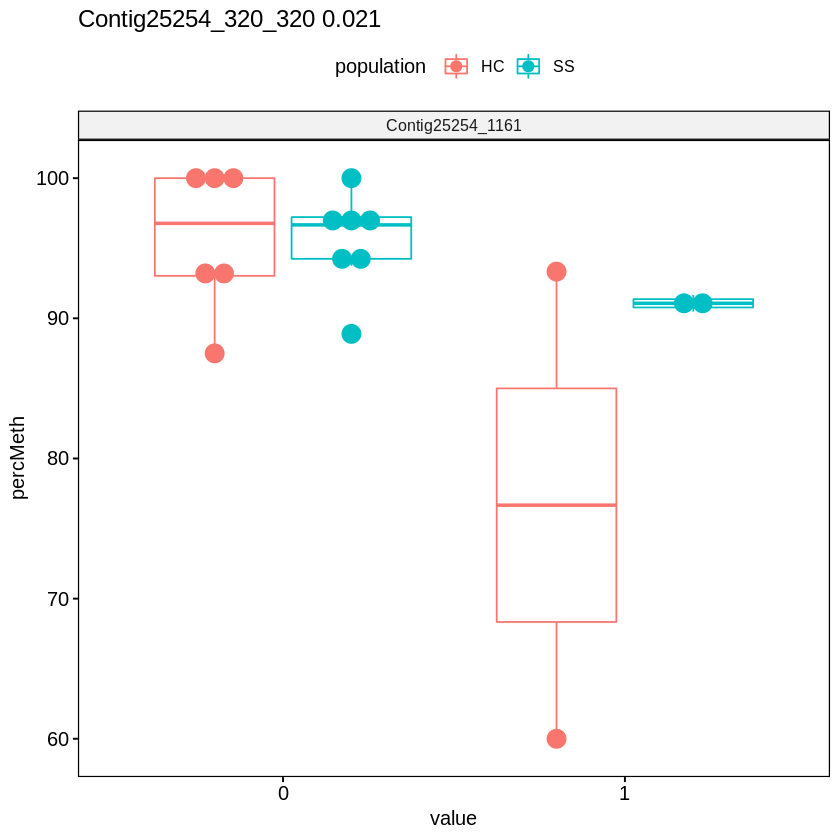

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



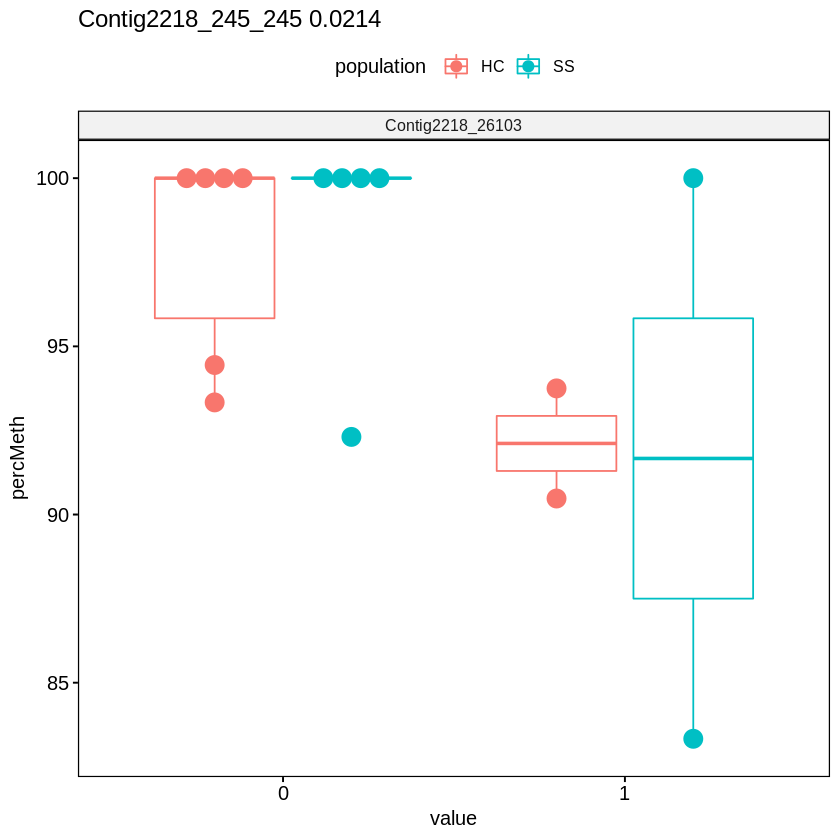

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


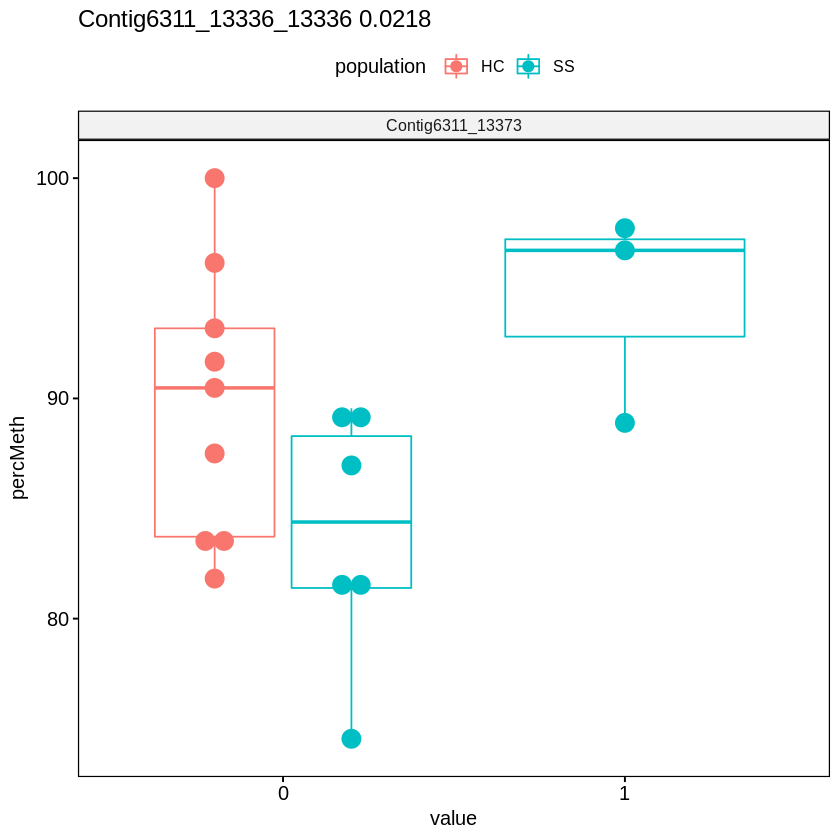

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



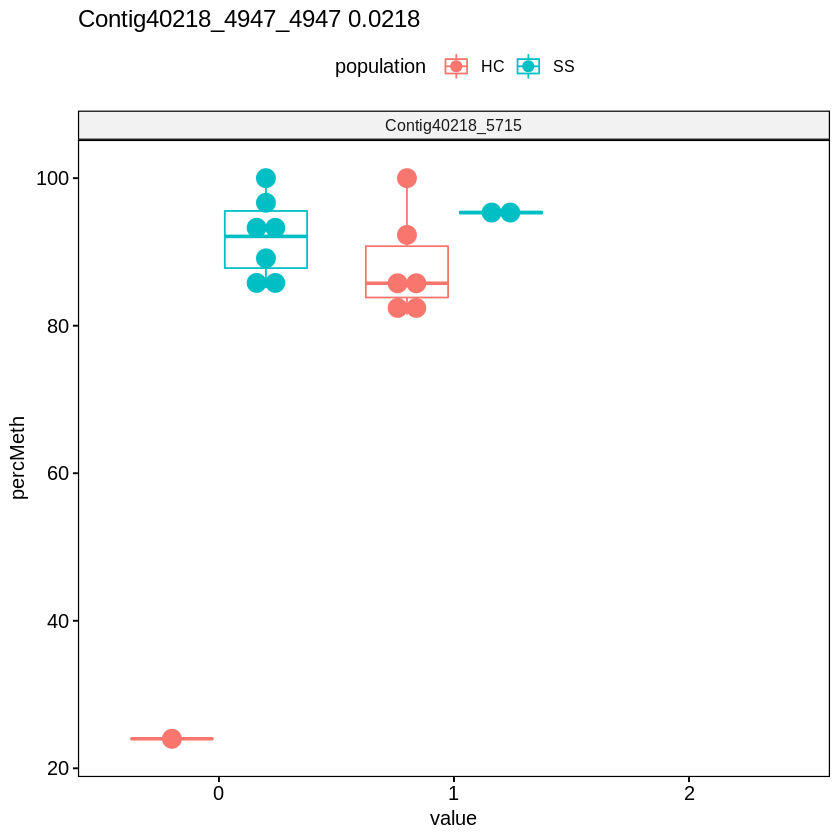

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



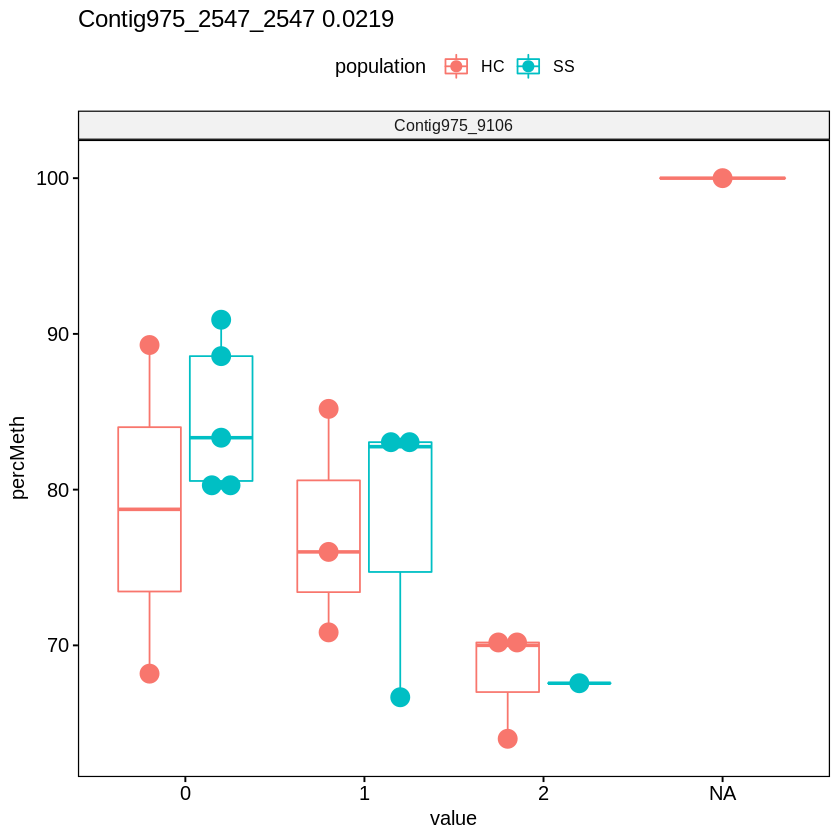

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


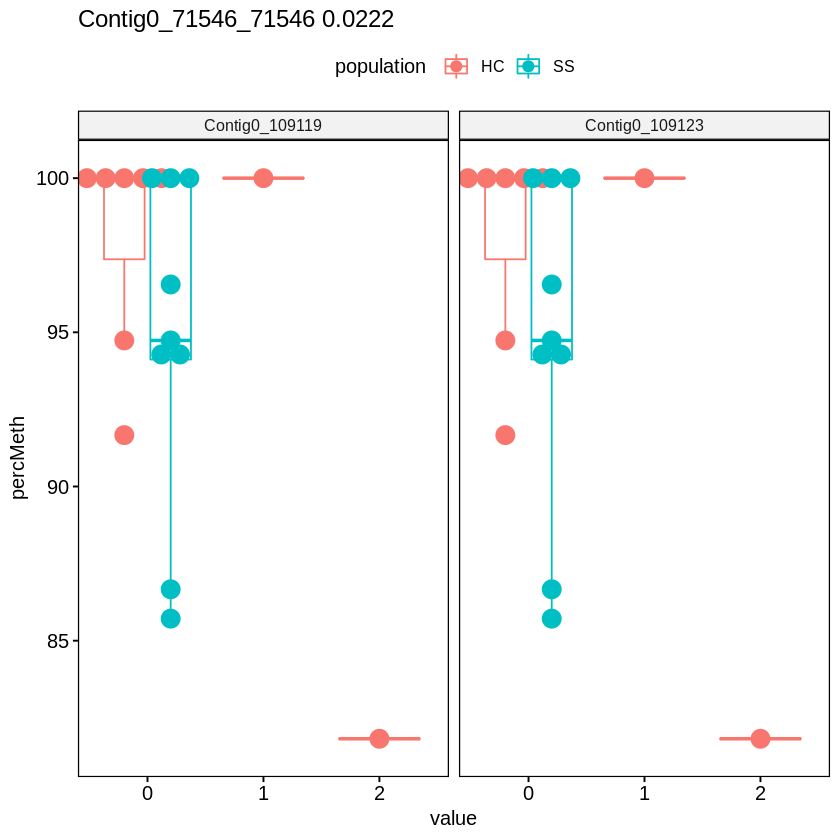

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


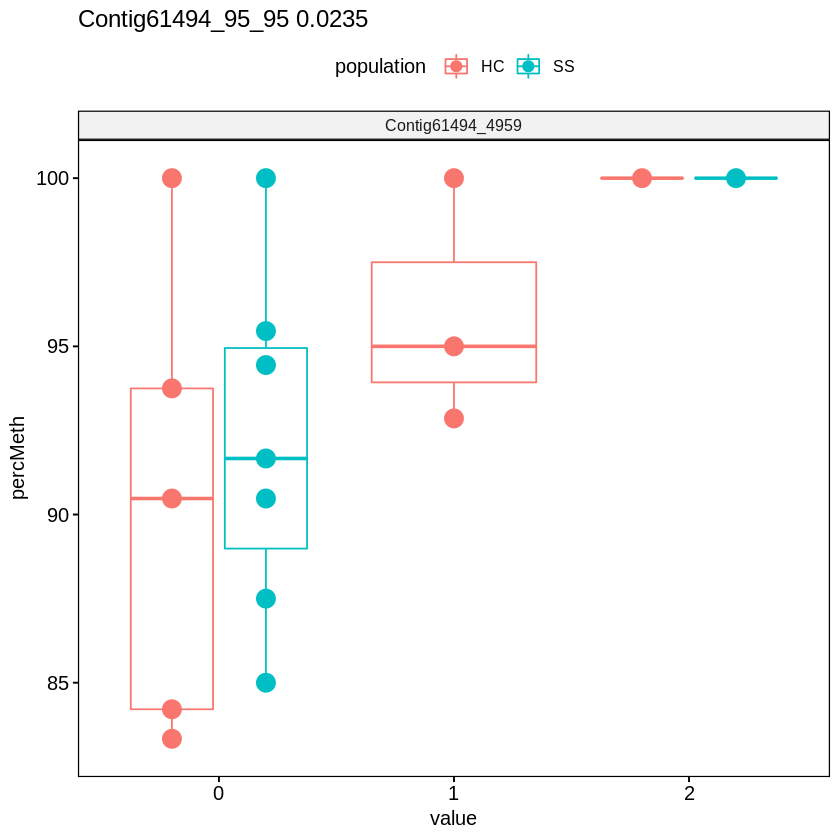

Warning message:
"Removed 4 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bindot)."


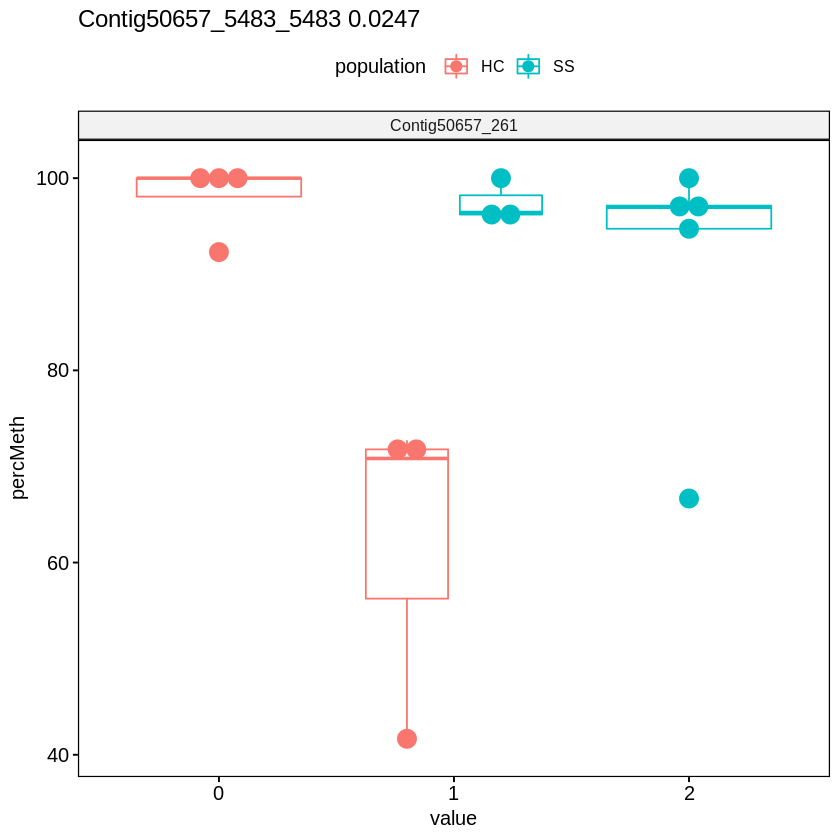

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


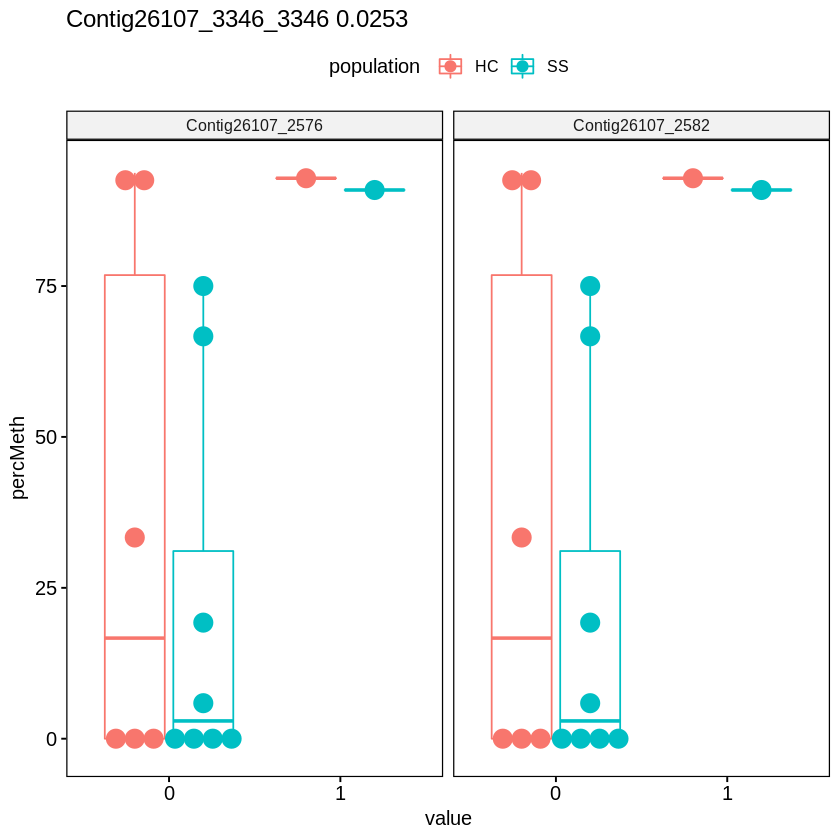

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


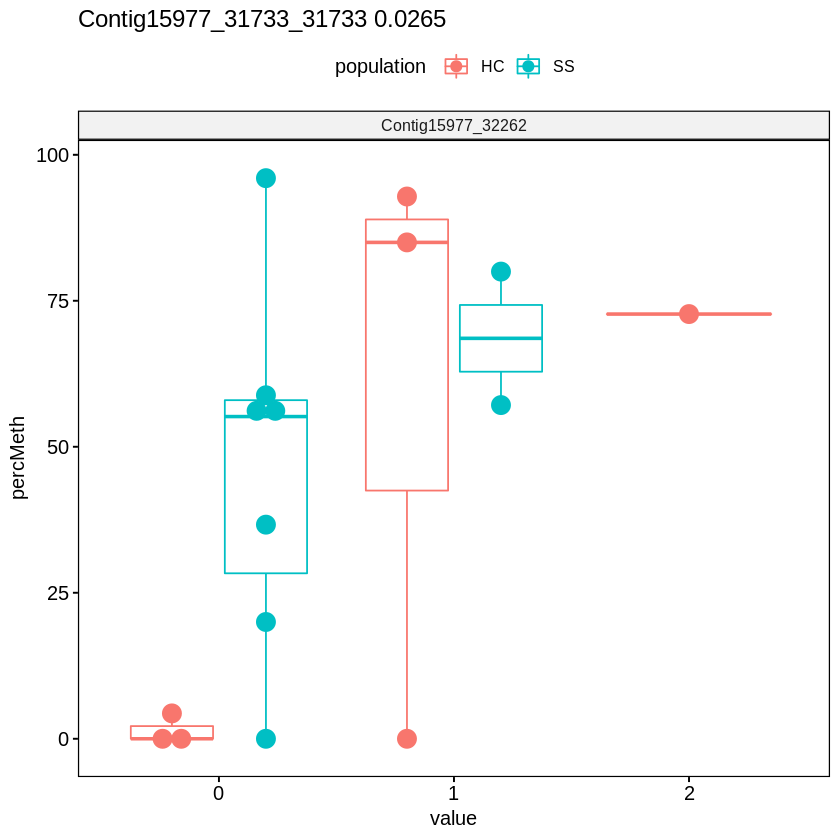

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


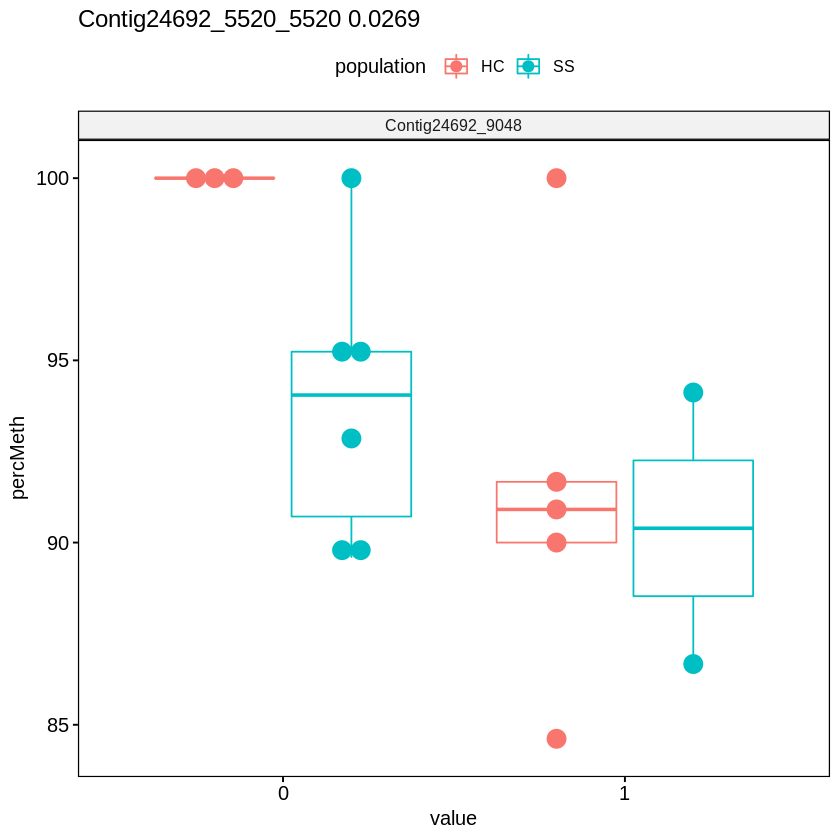

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


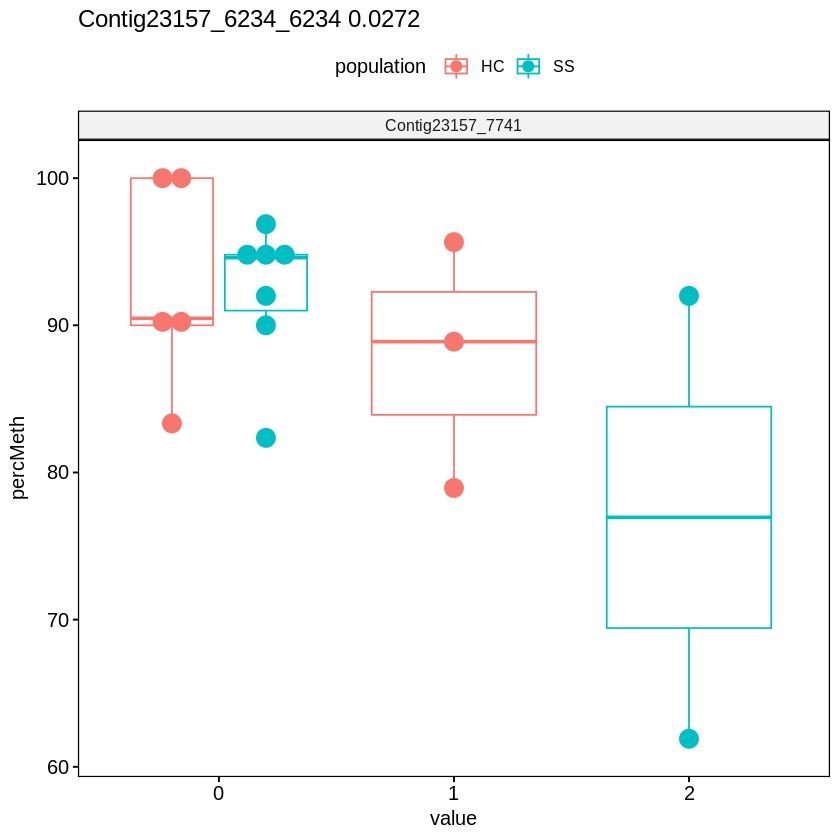

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


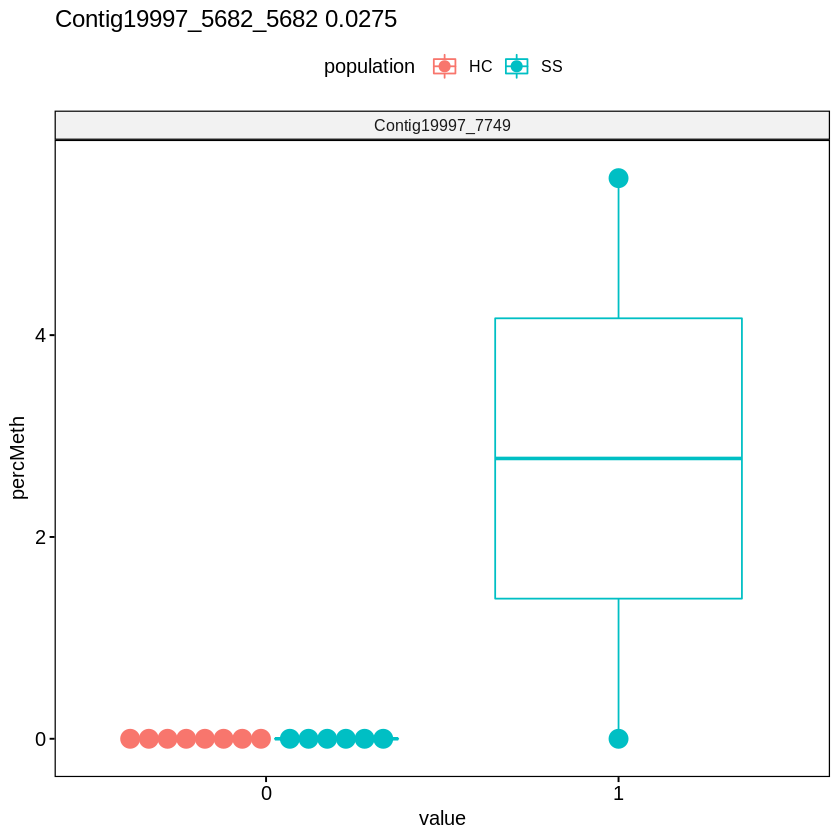

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



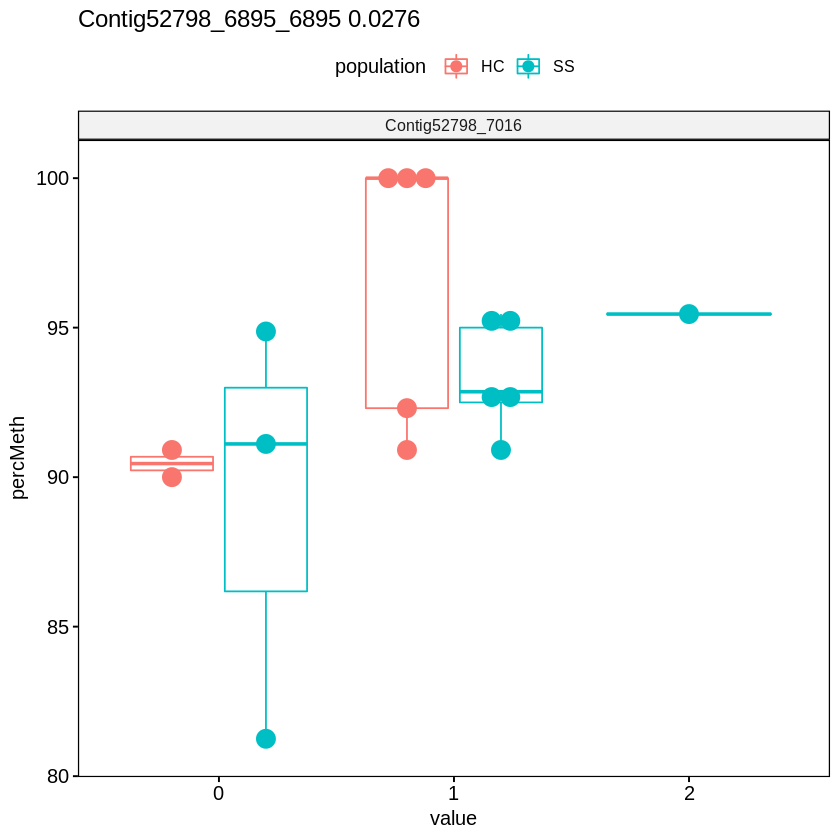

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


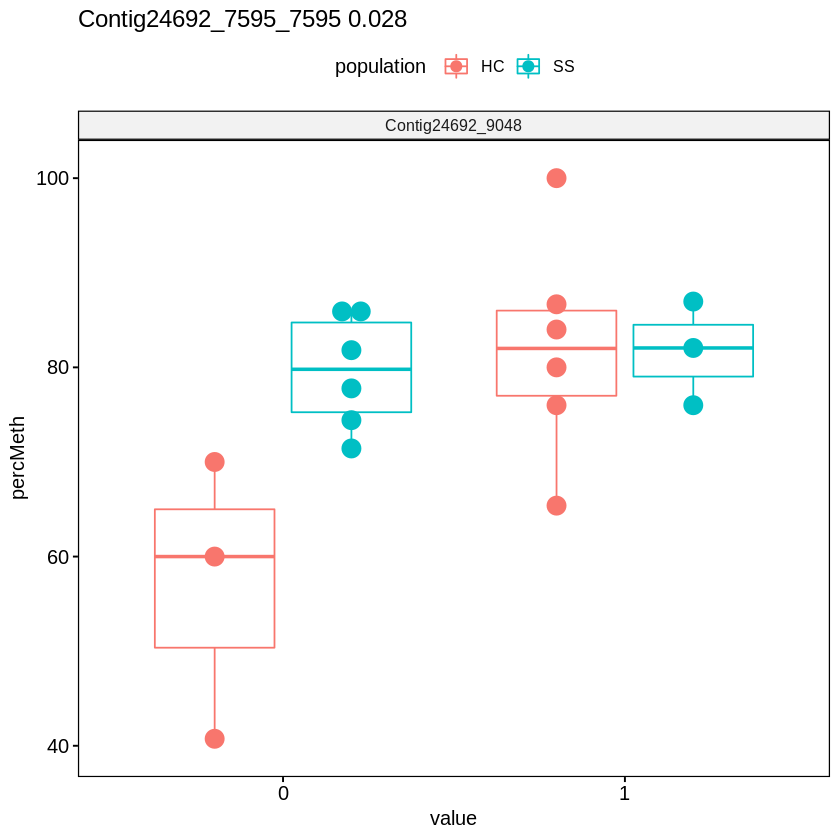

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


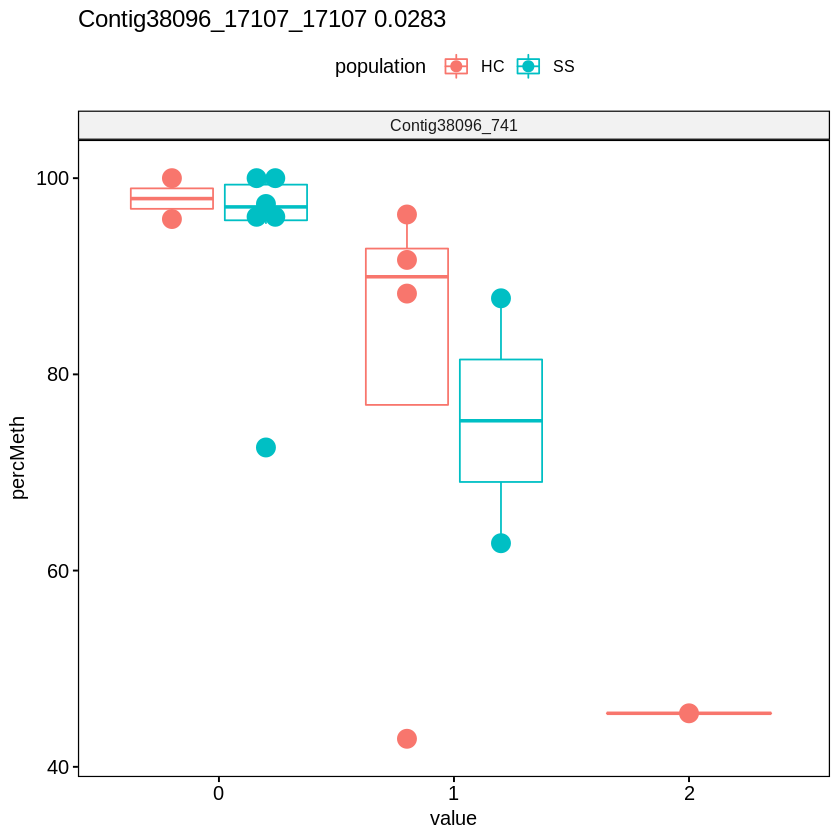

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



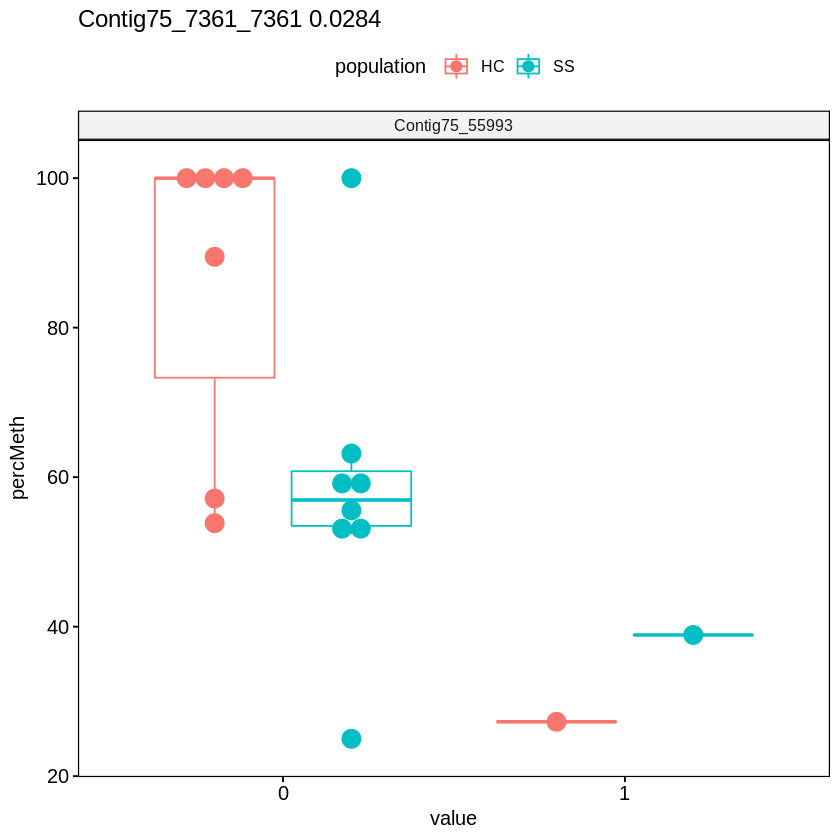

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


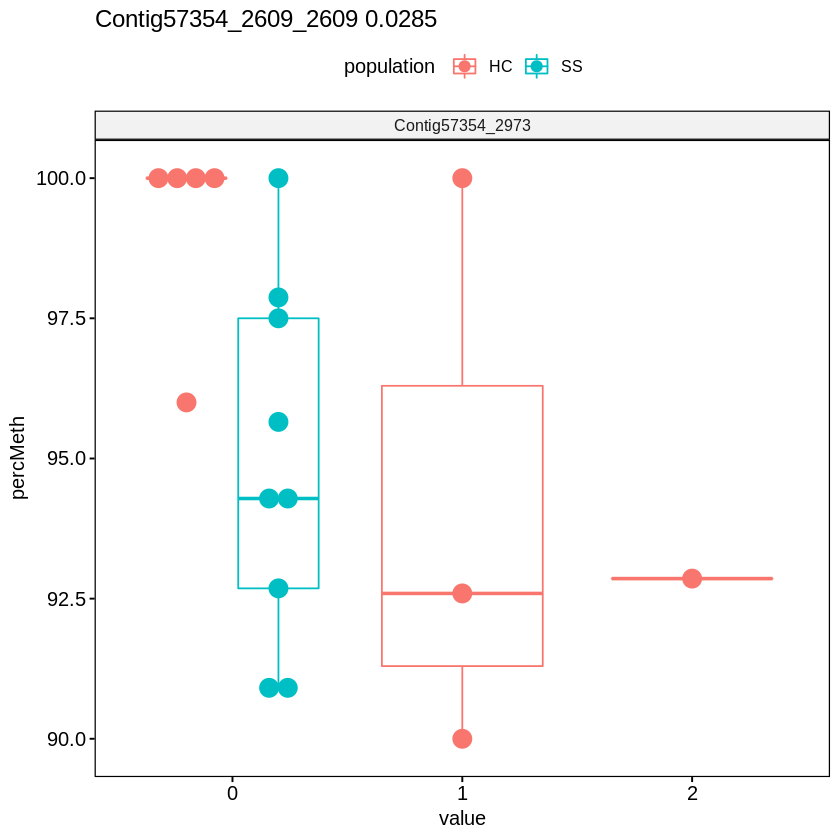

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



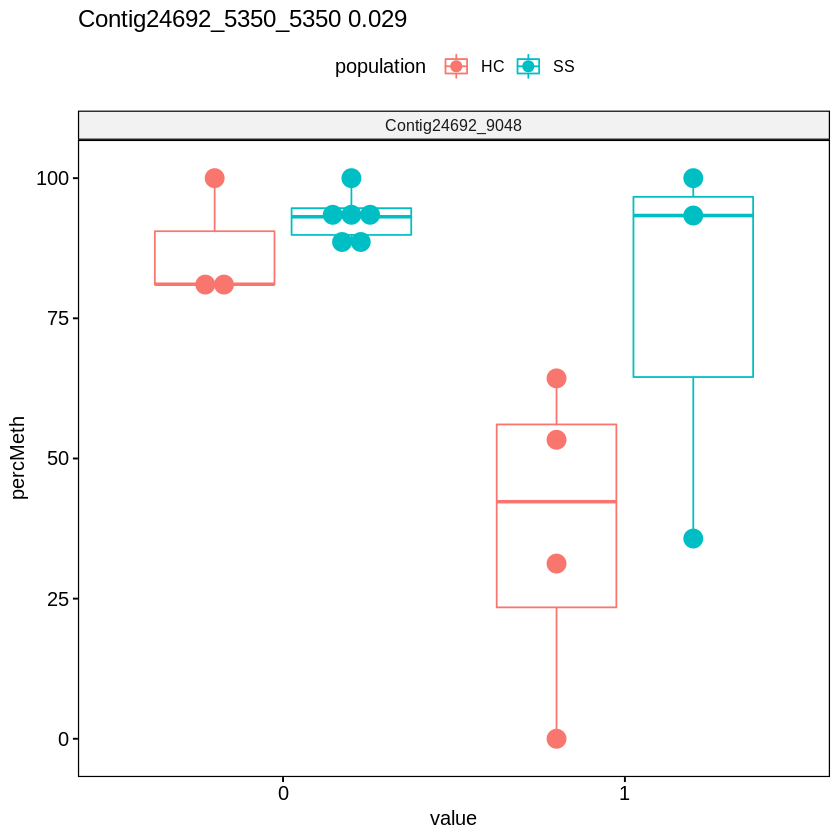

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



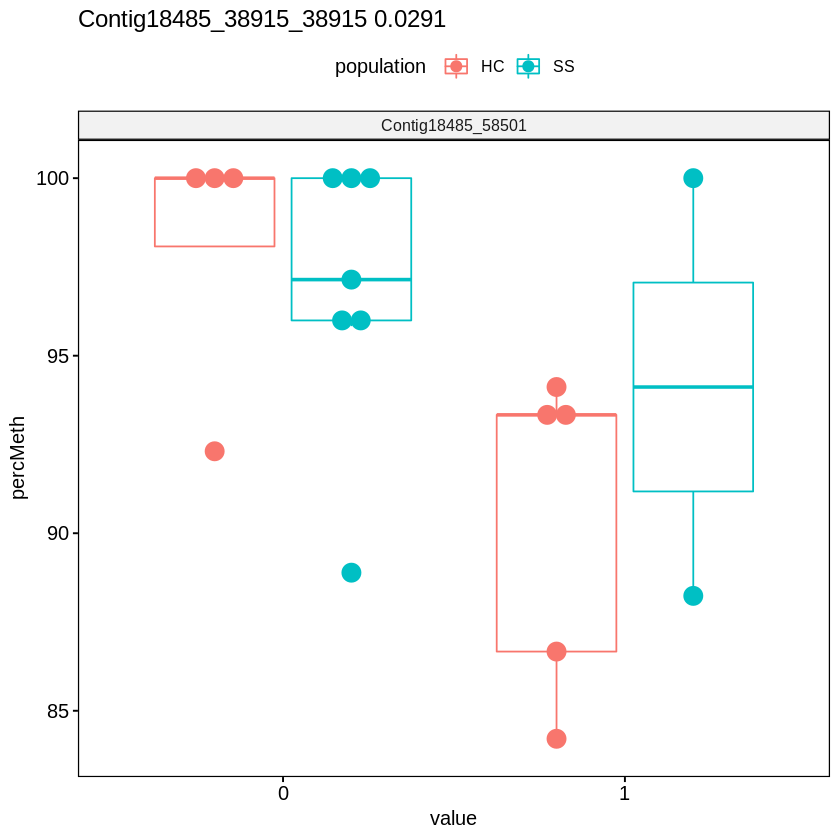

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



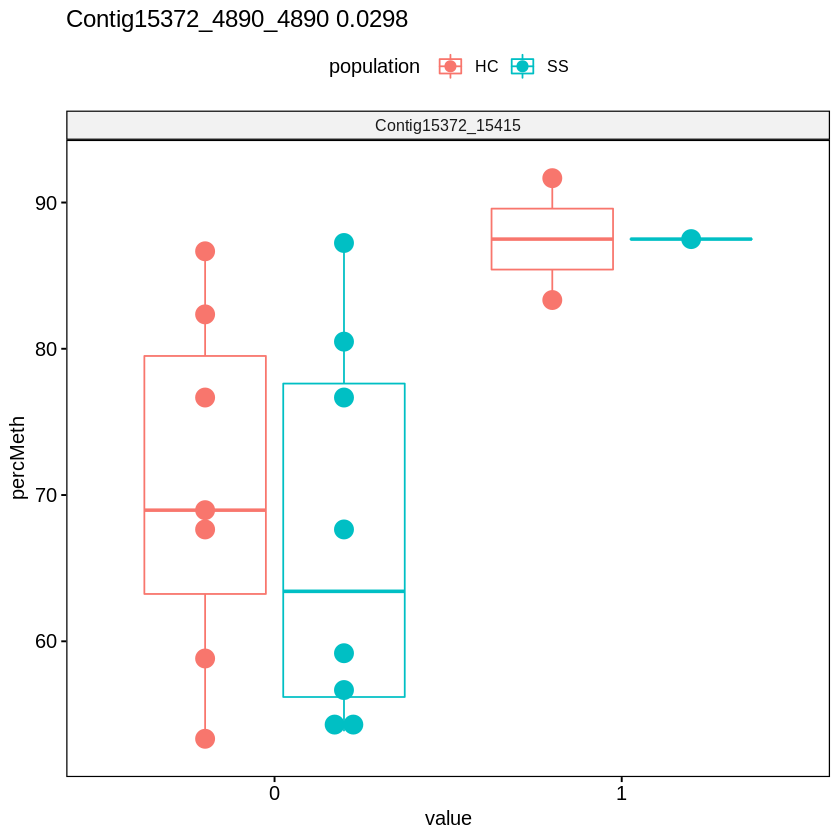

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


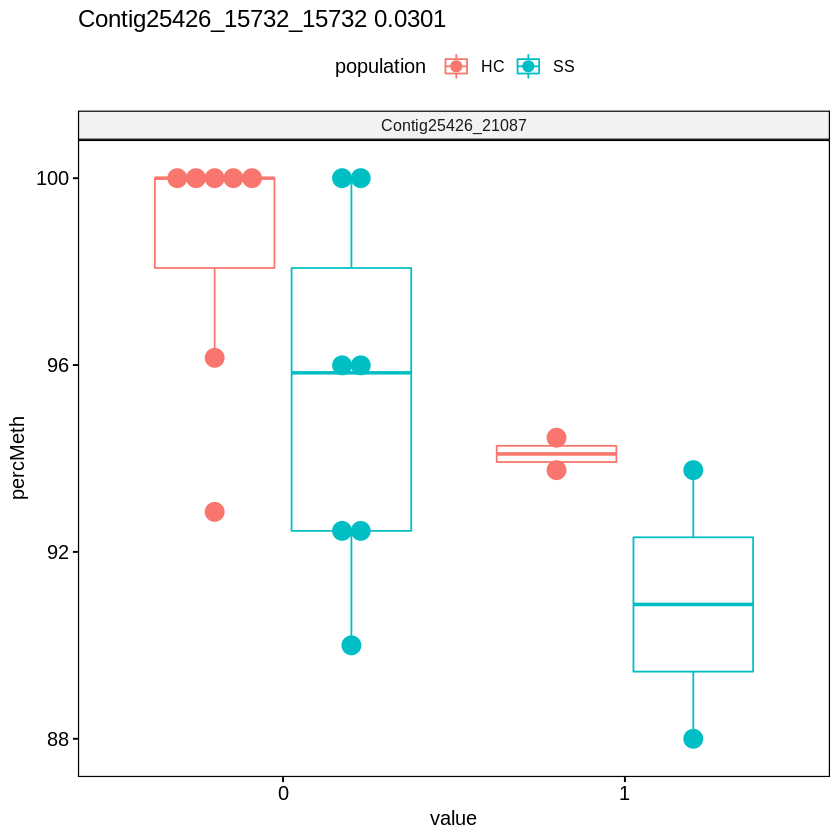

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


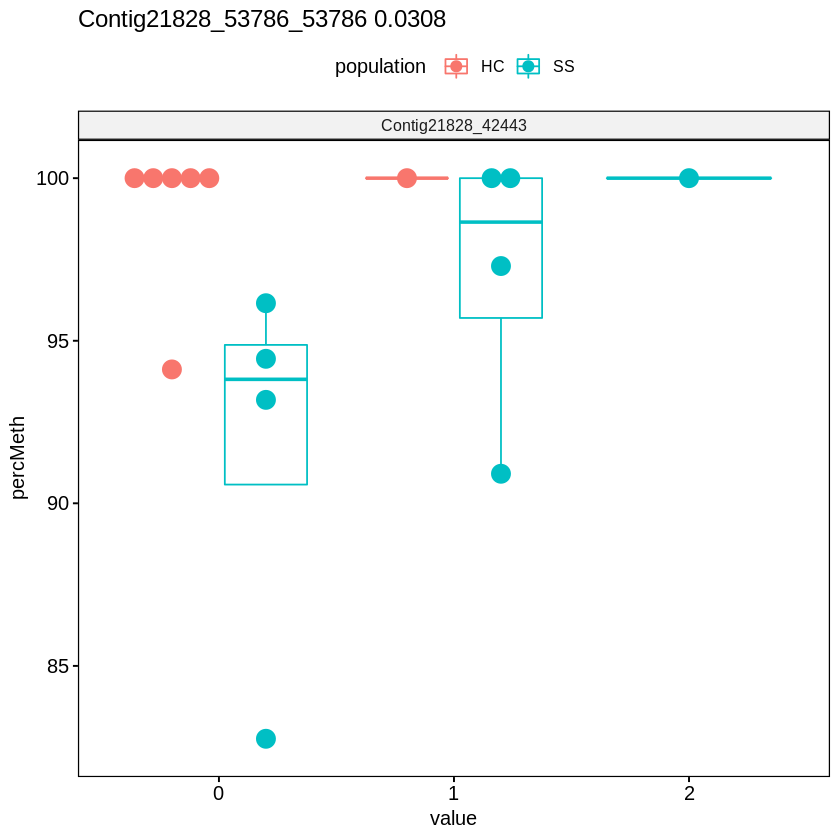

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


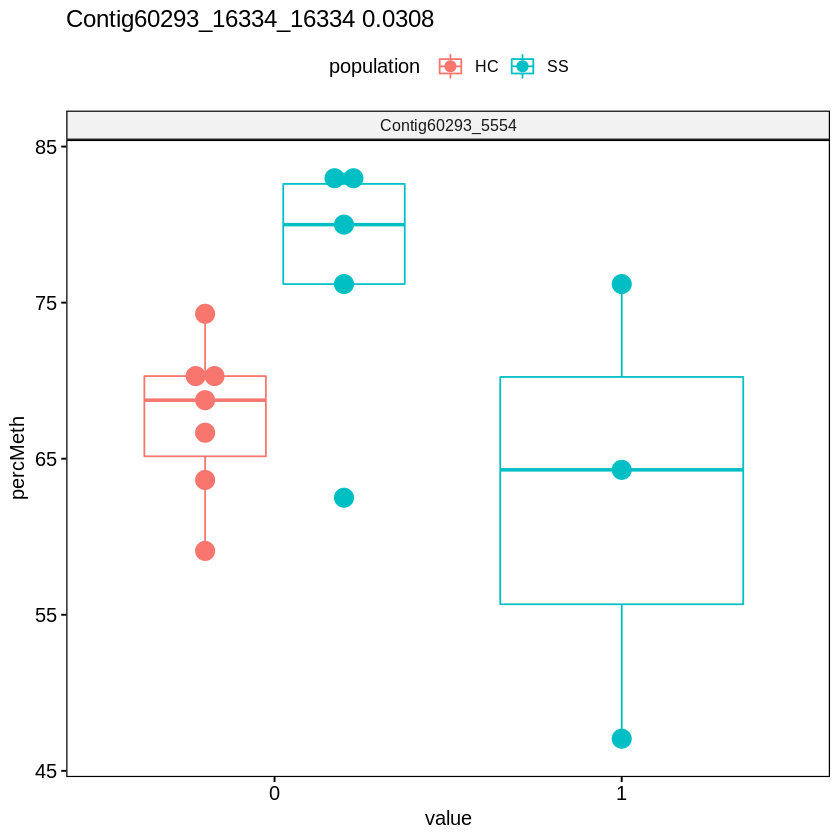

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


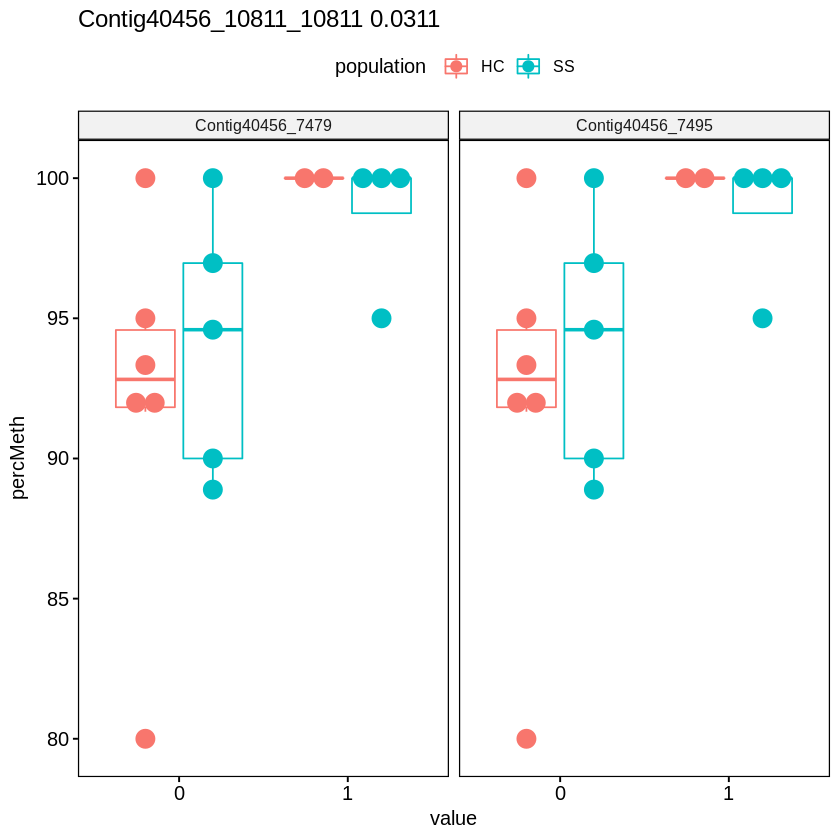

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


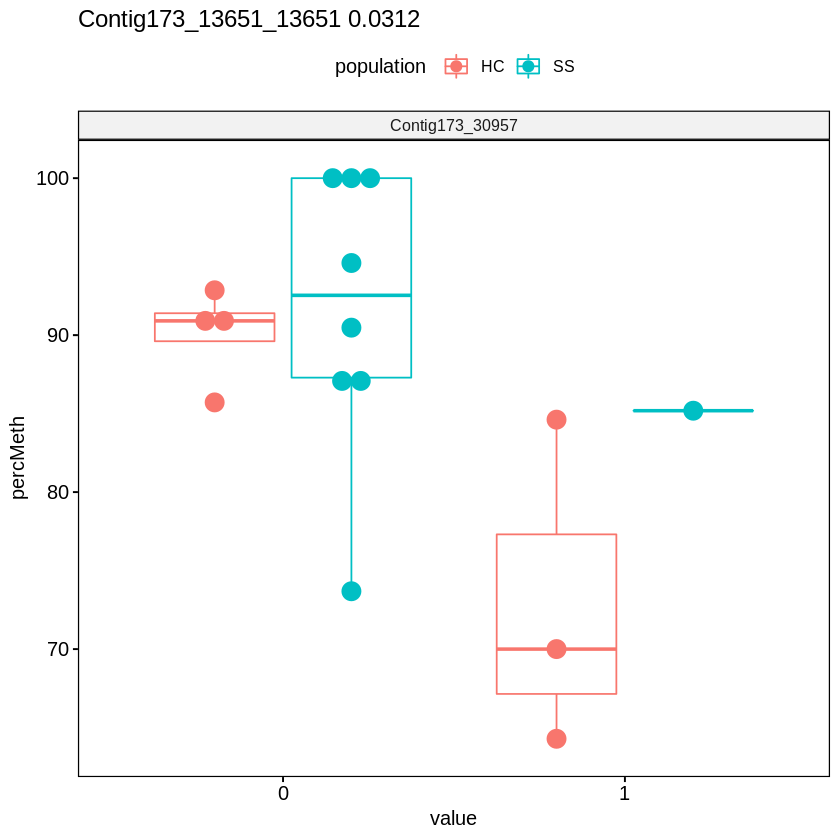

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


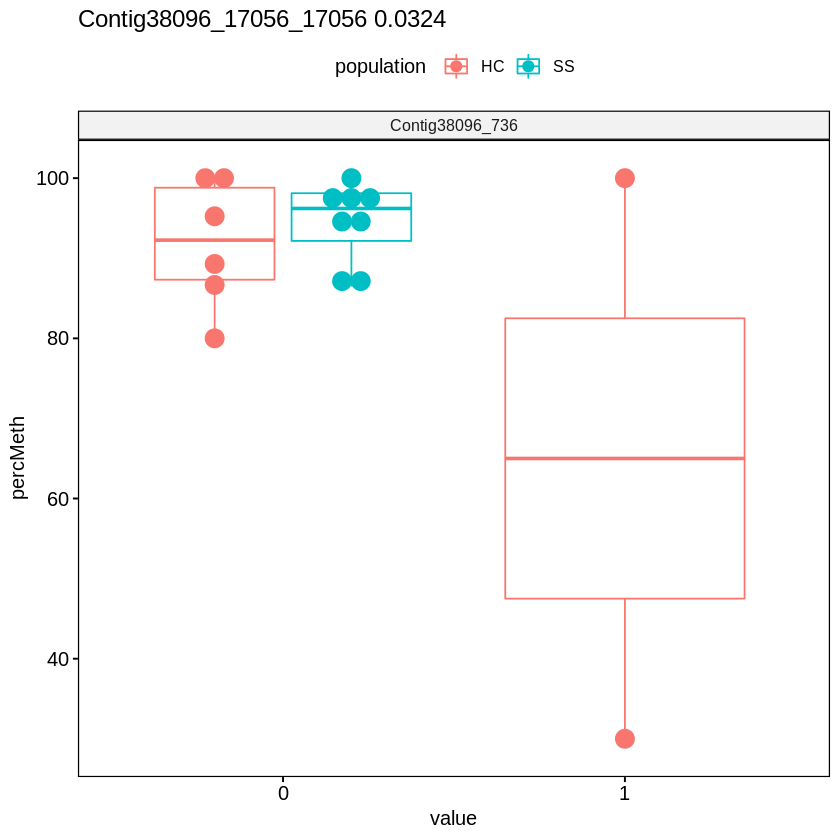

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


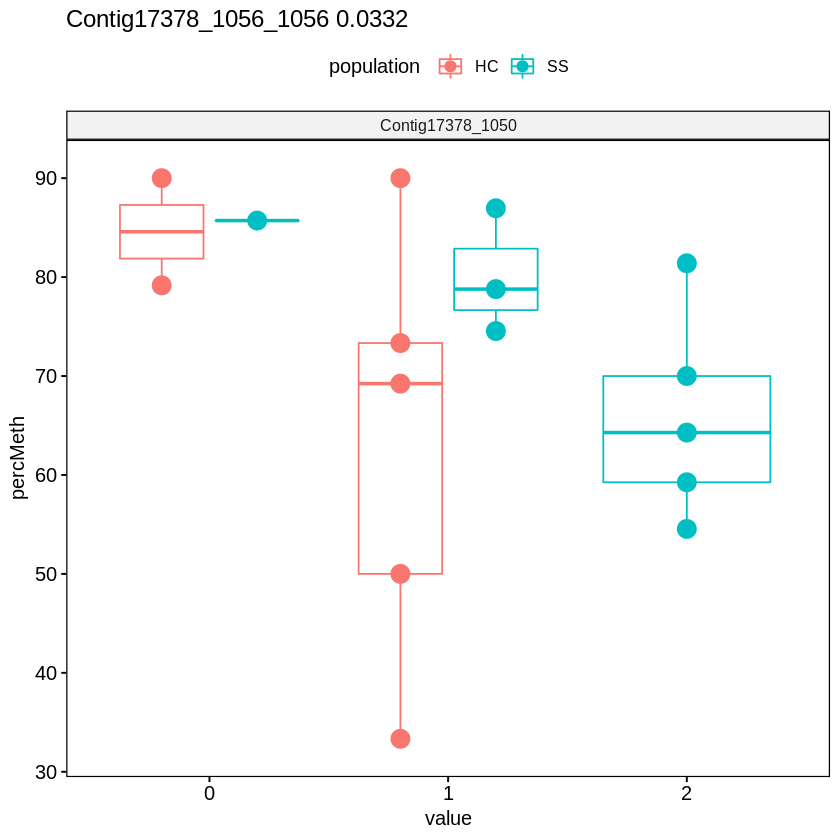

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


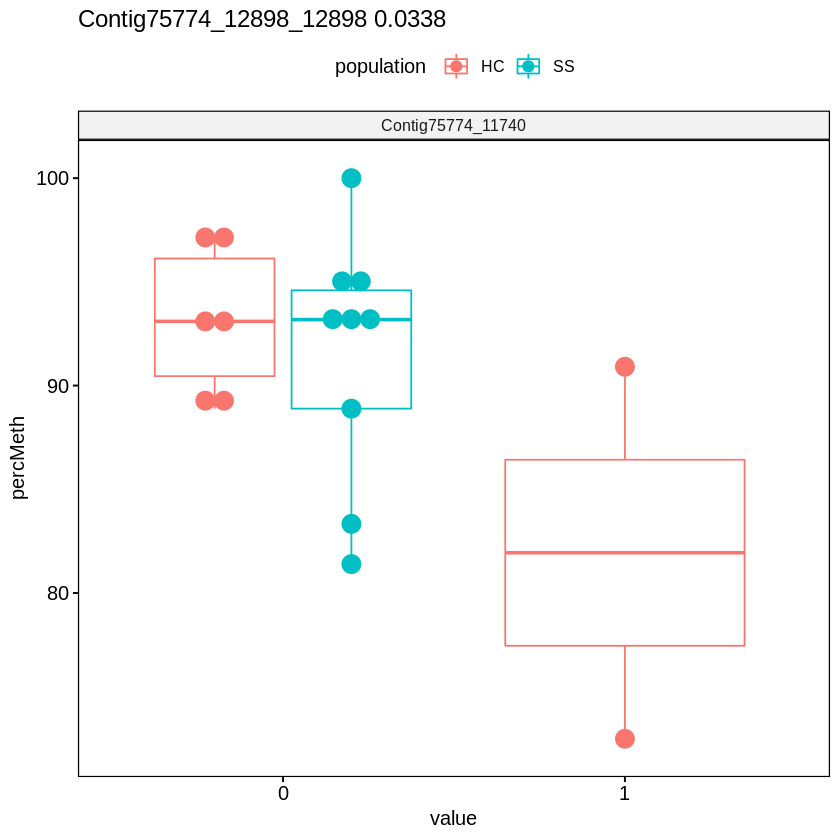

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


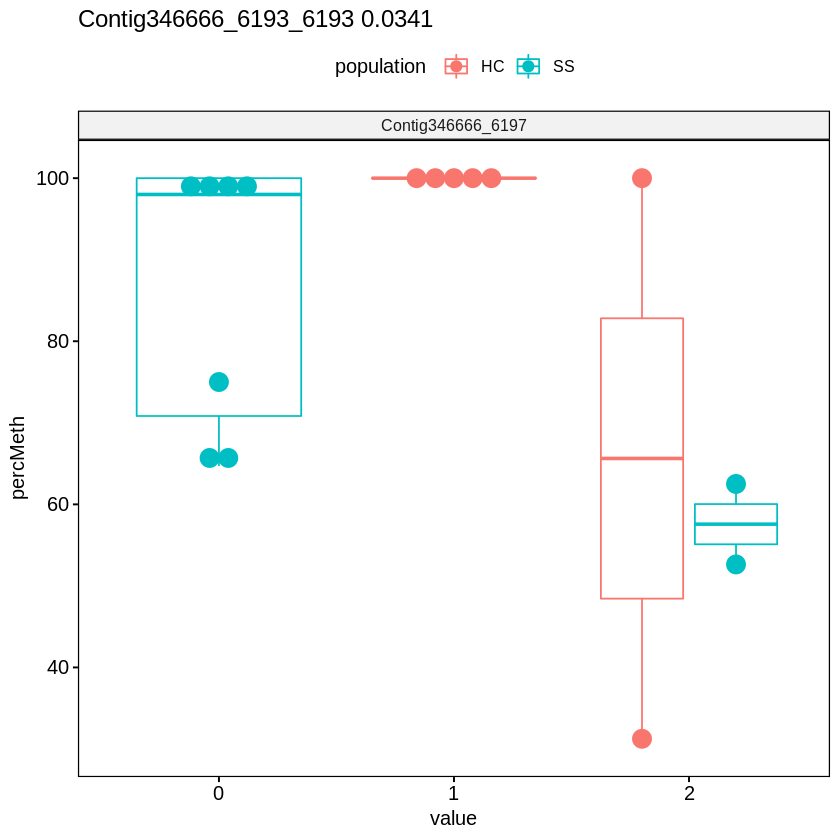

Warning message:
"Removed 8 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 8 rows containing non-finite values (stat_bindot)."


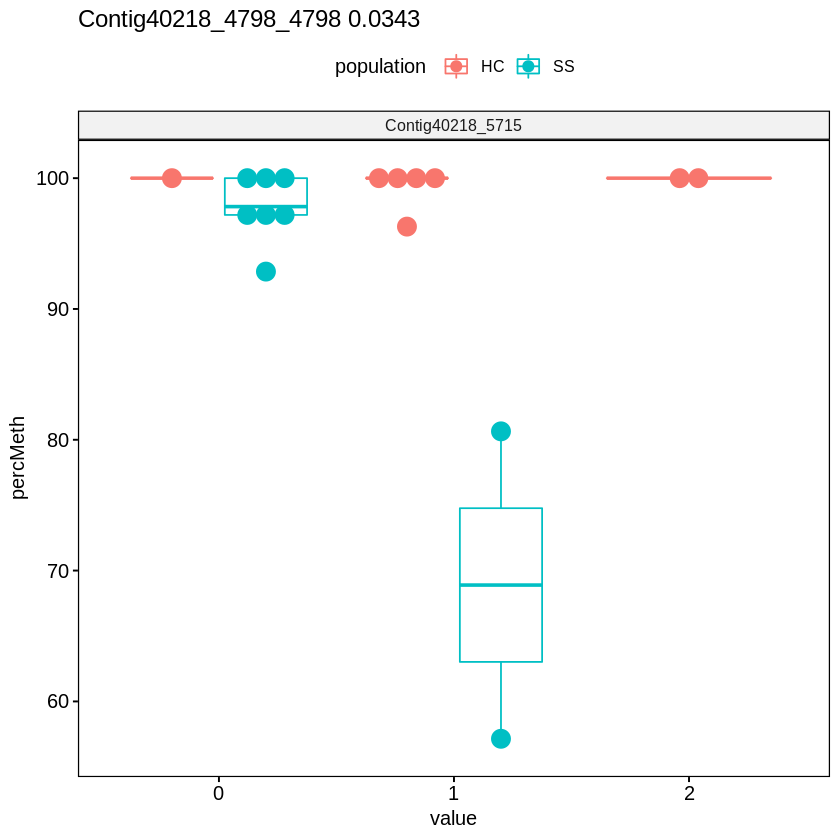

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


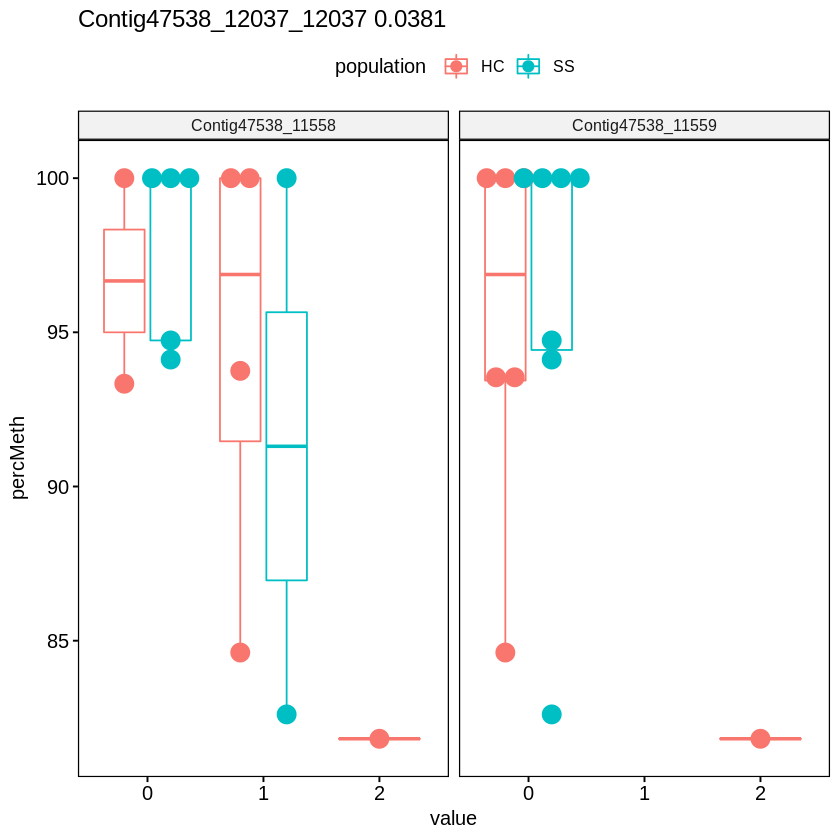

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


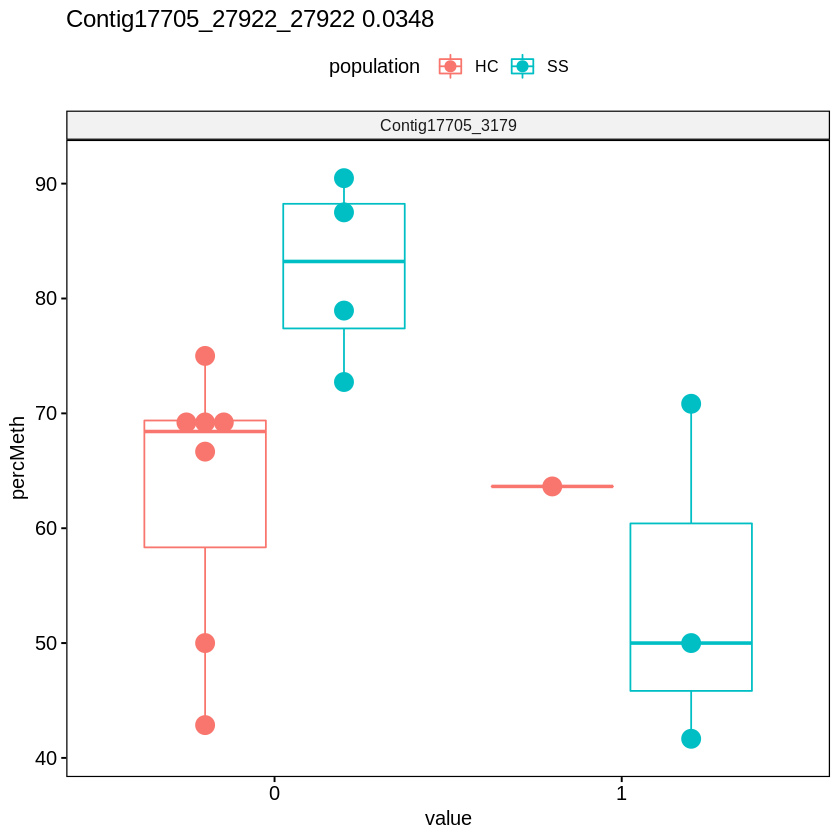

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


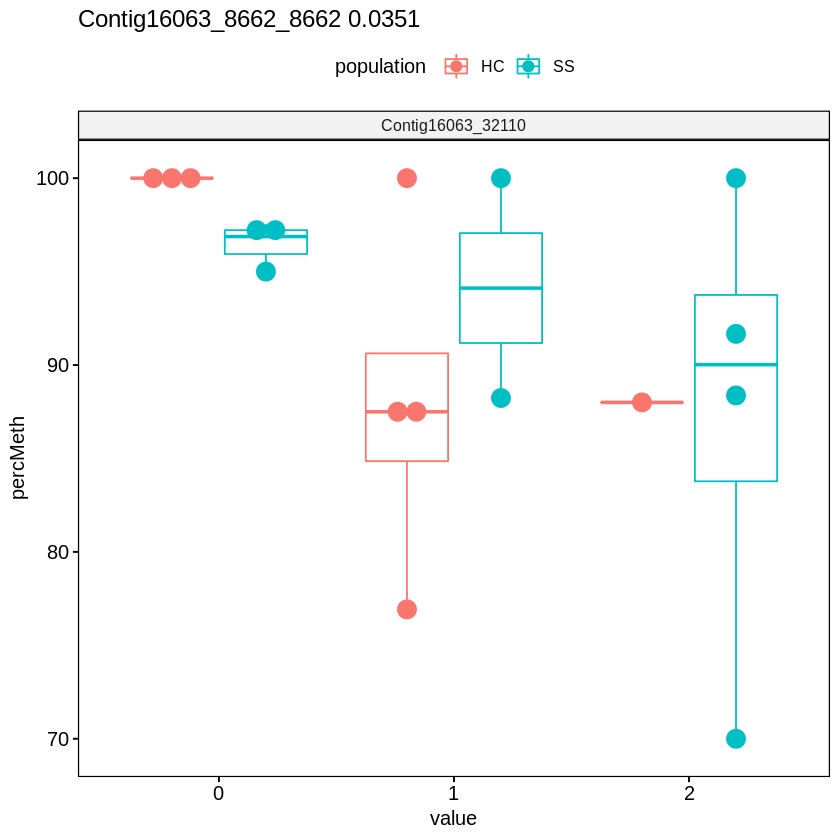

Warning message:
"Removed 4 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 4 rows containing non-finite values (stat_bindot)."


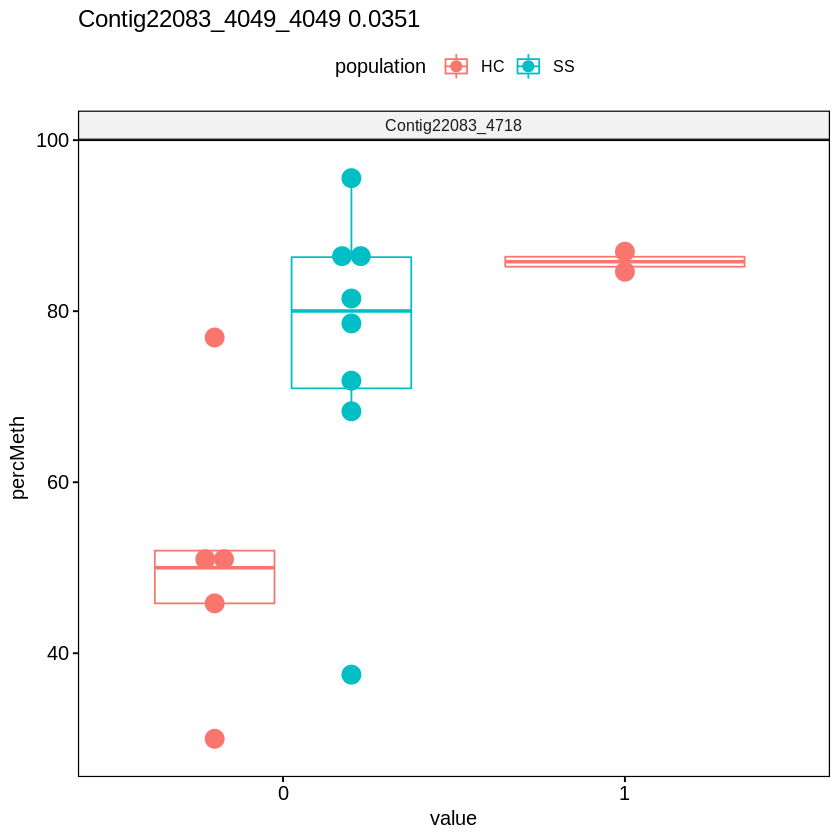

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


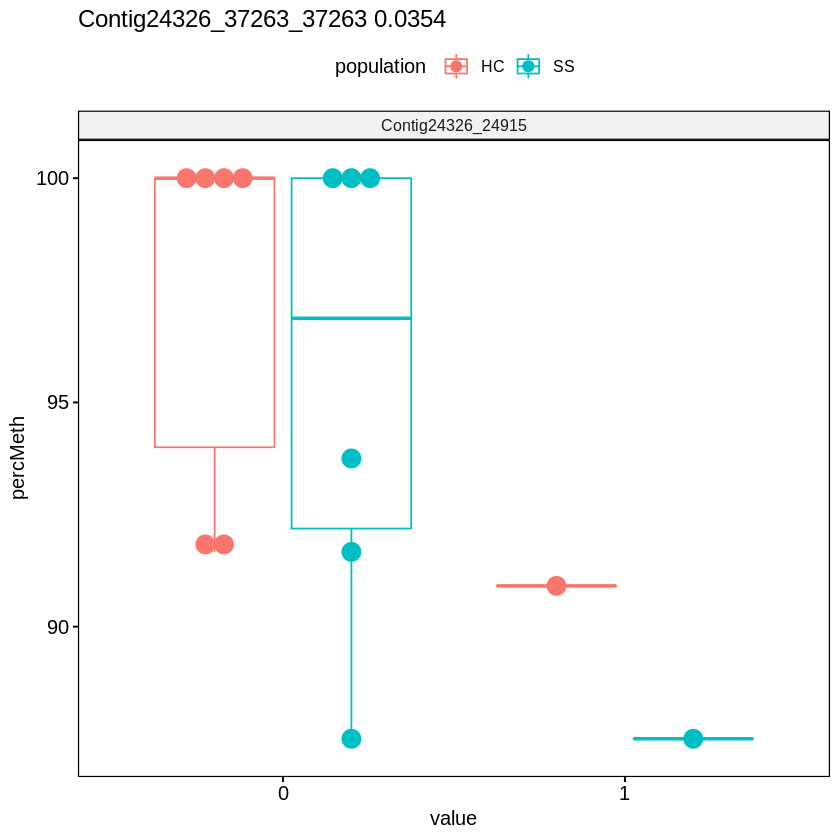

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



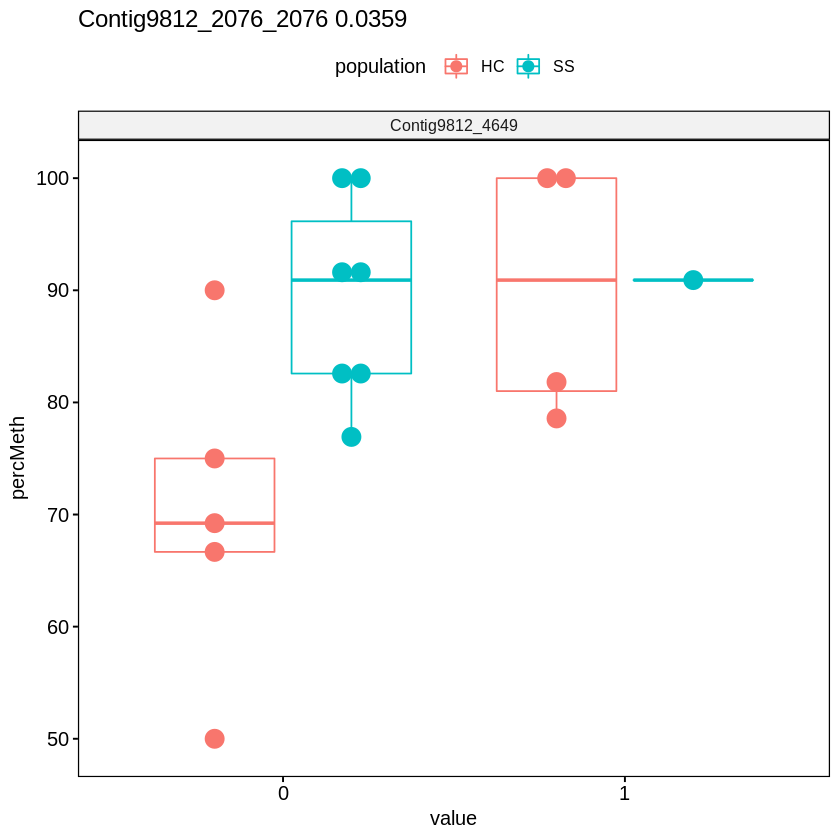

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



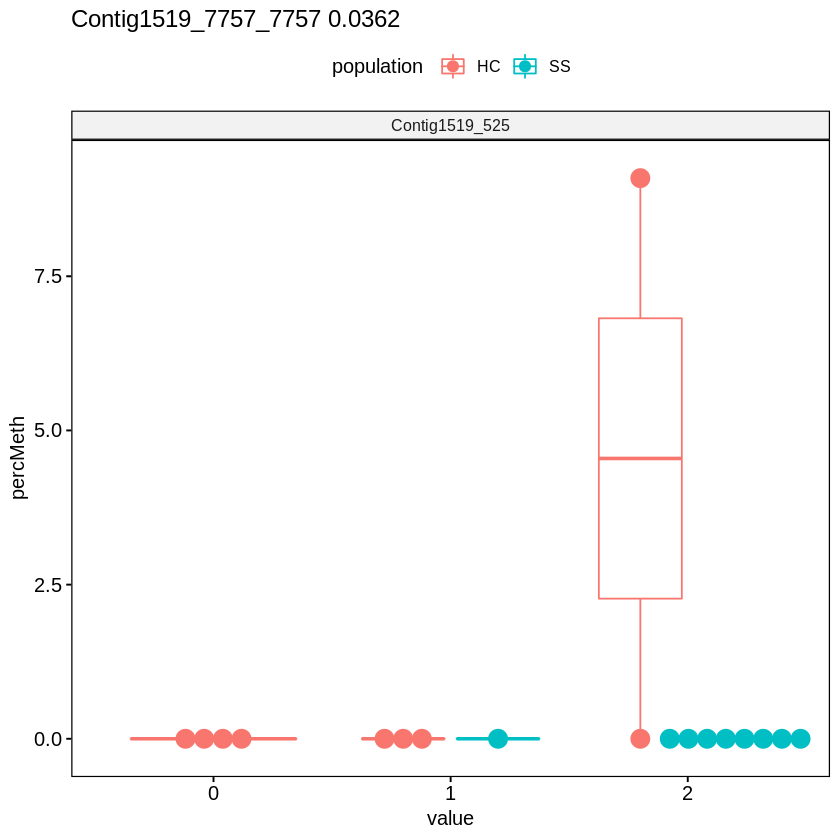

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


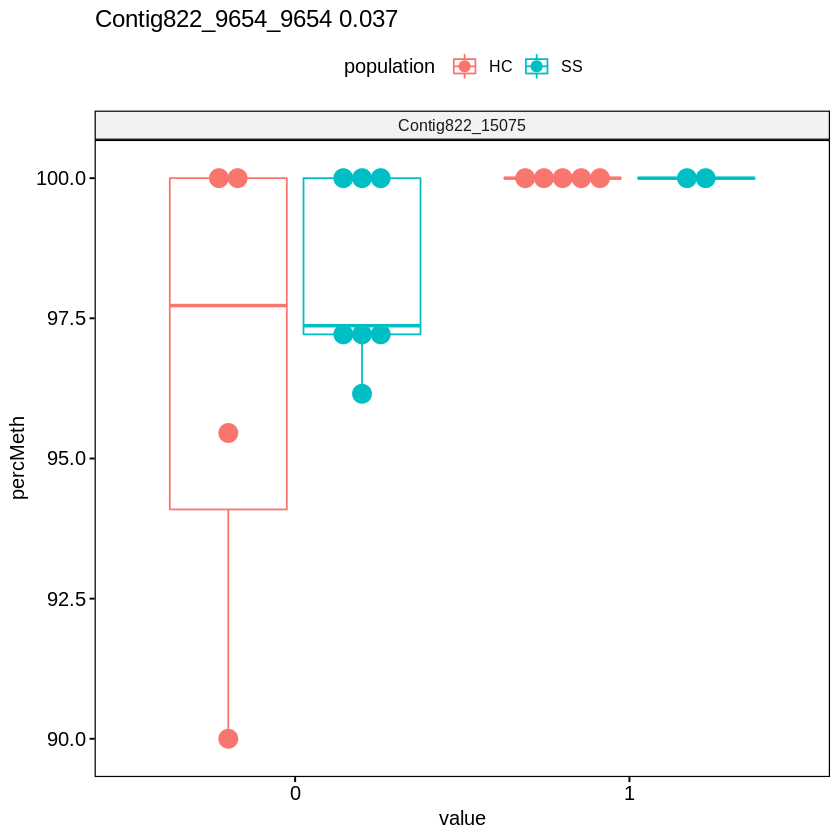

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



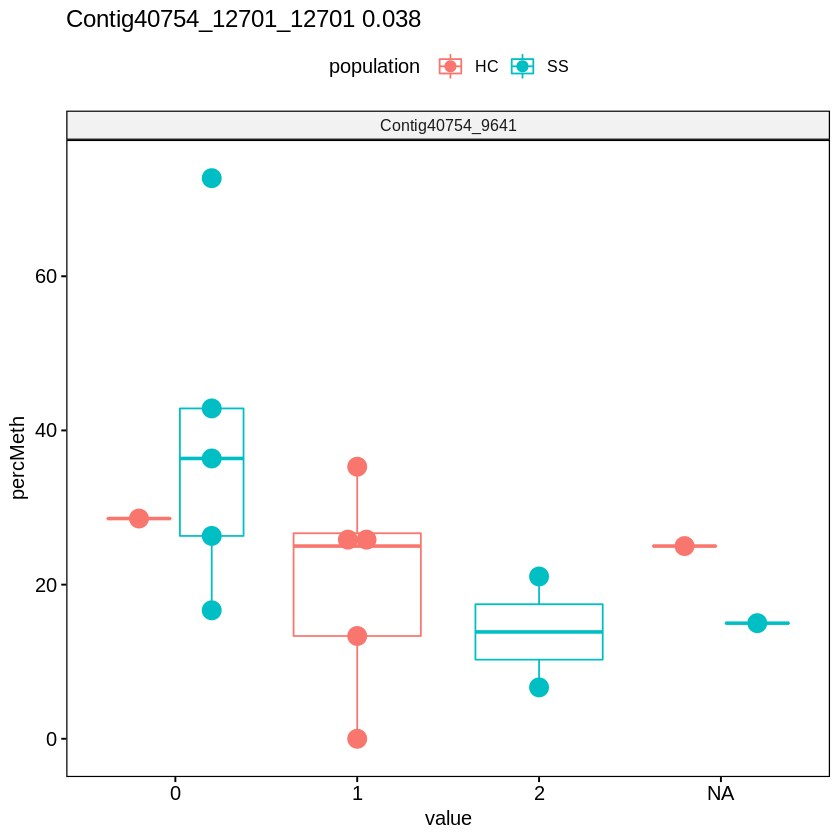

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


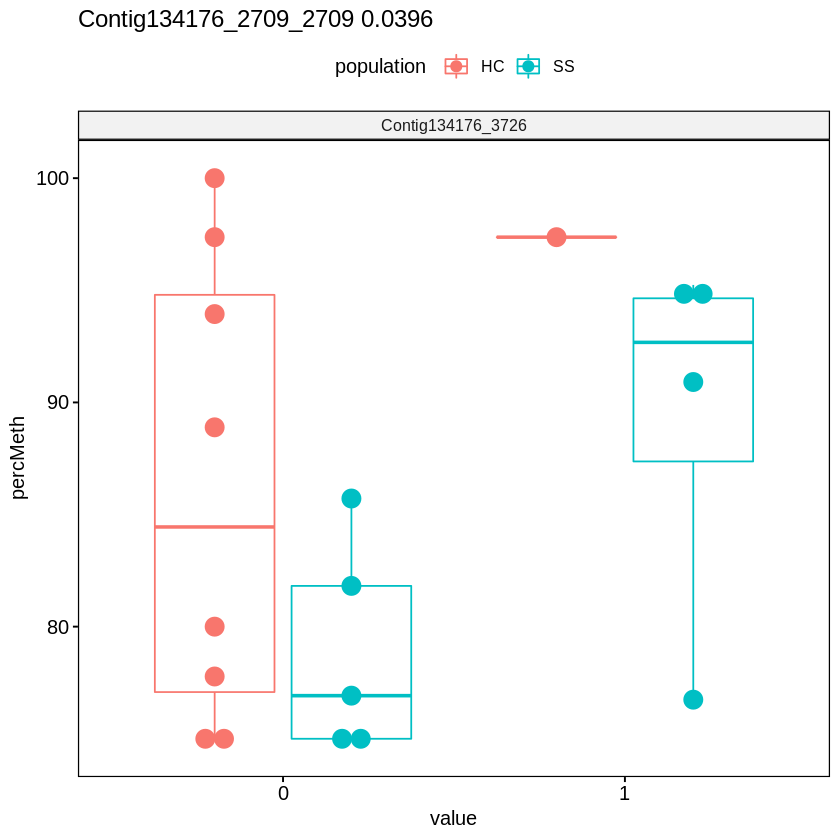

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


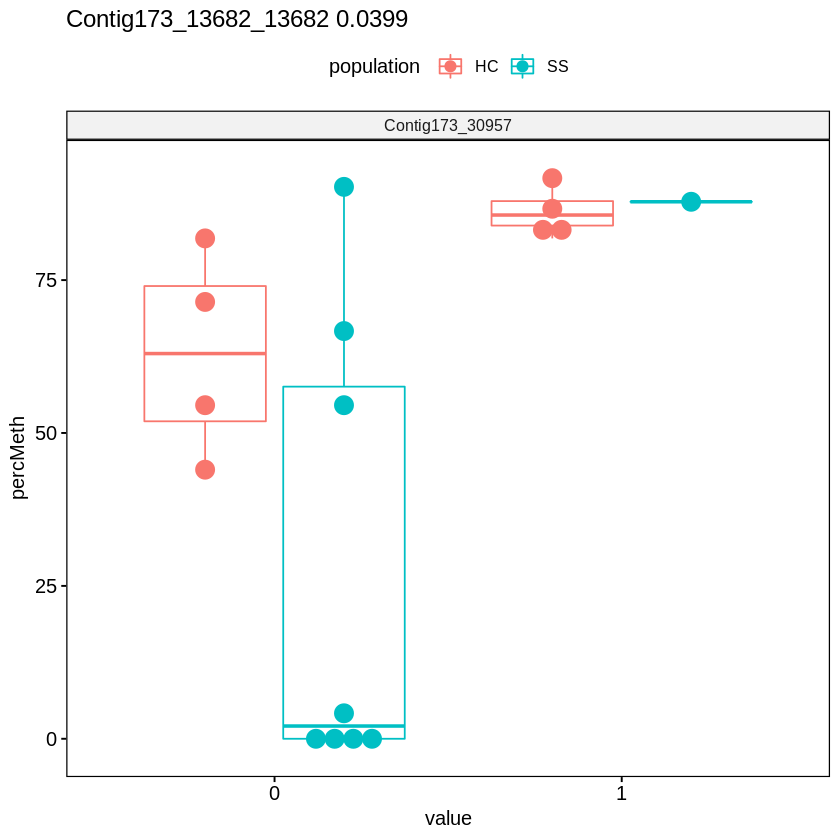

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


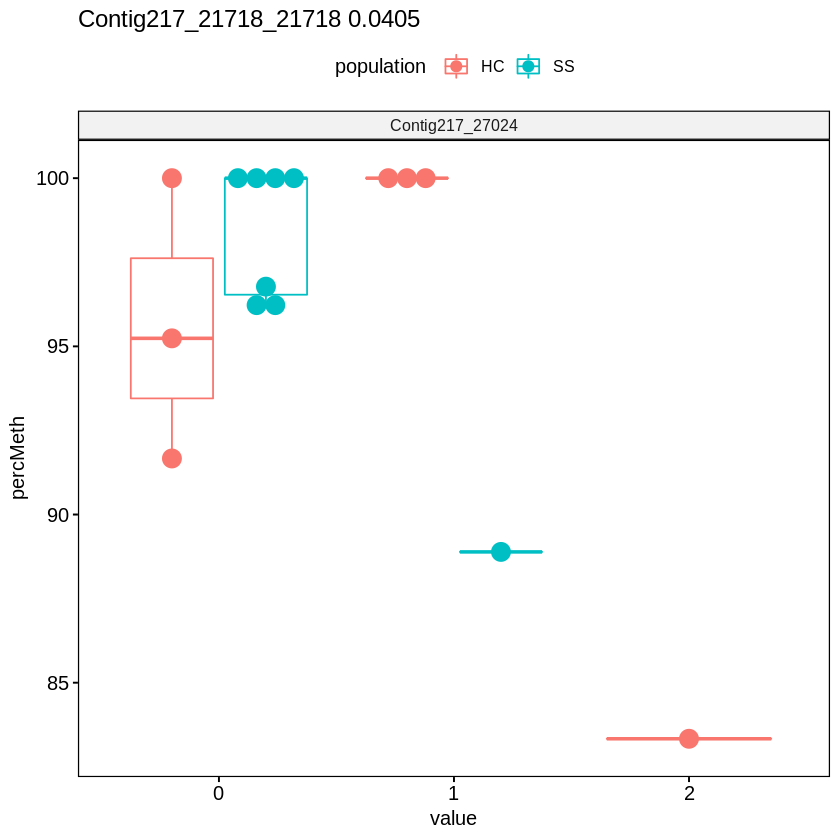

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



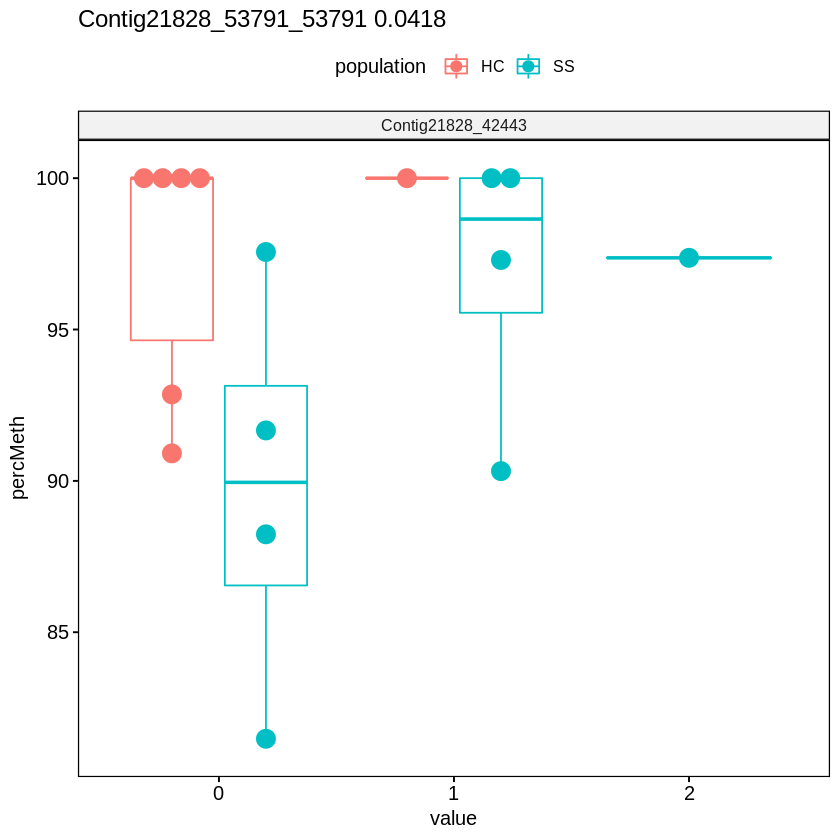

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


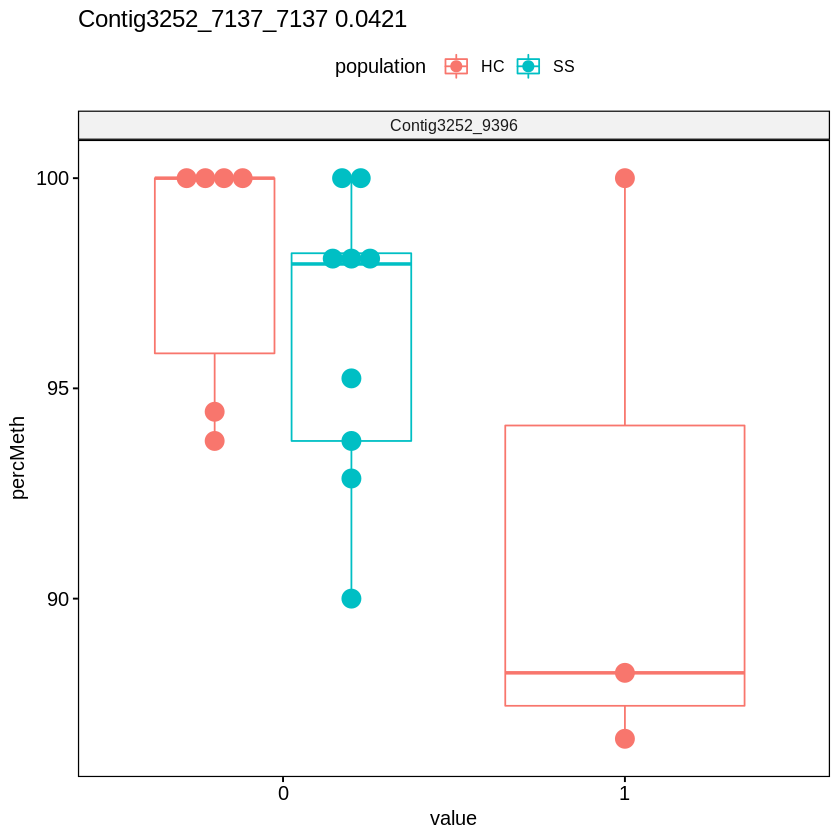

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


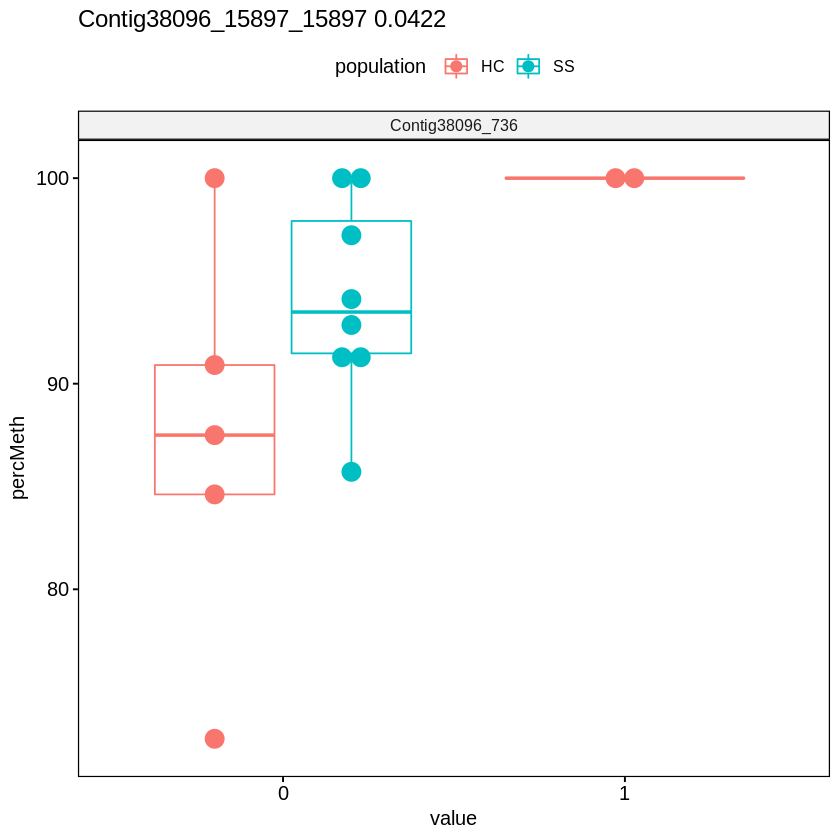

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


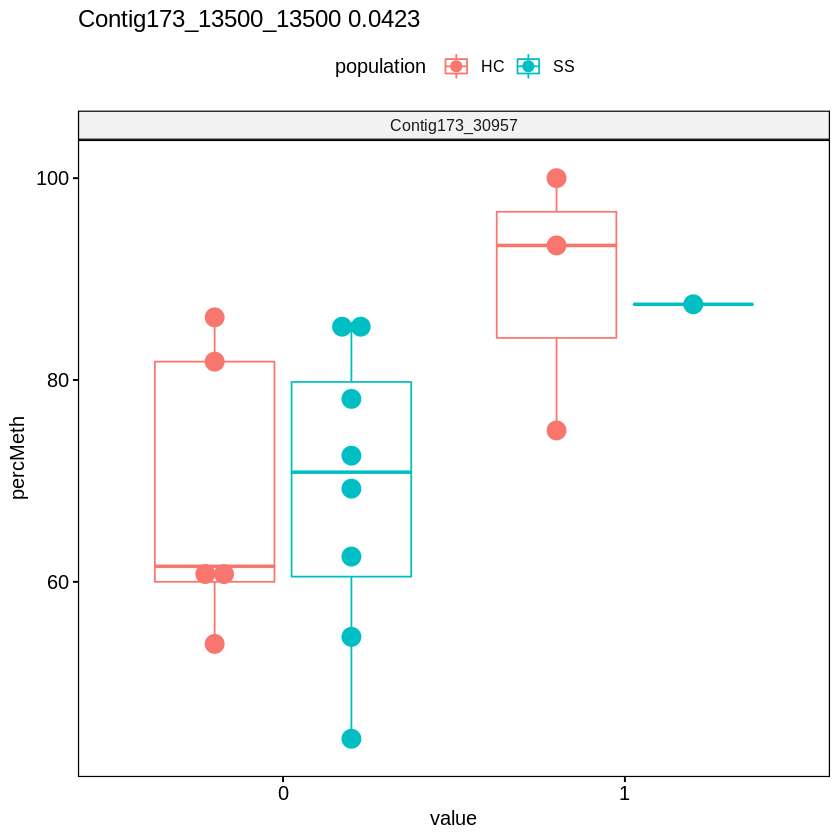

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


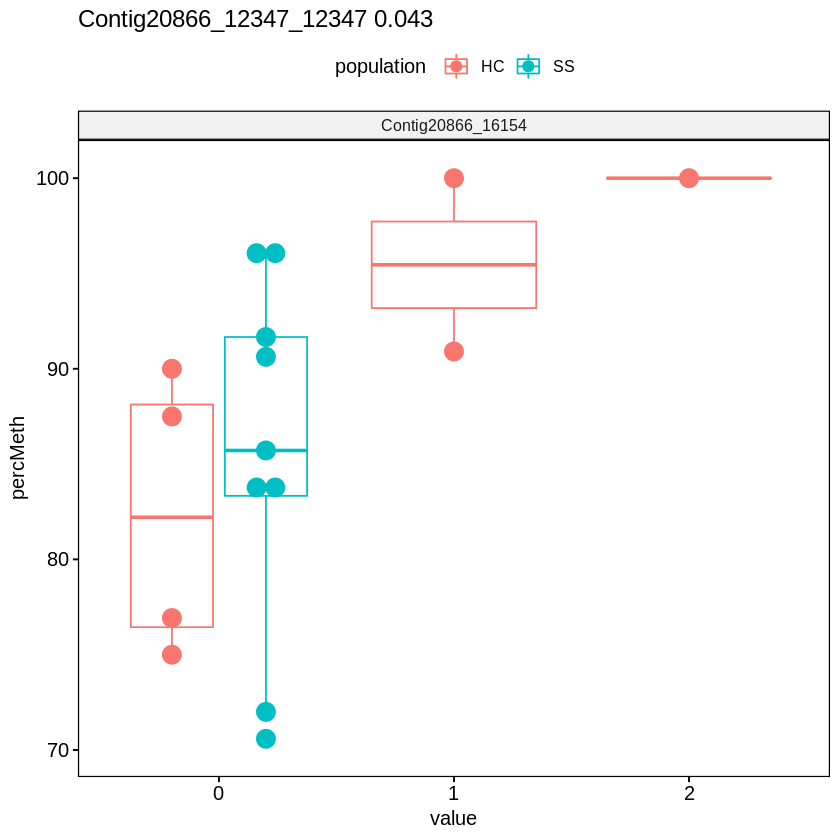

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



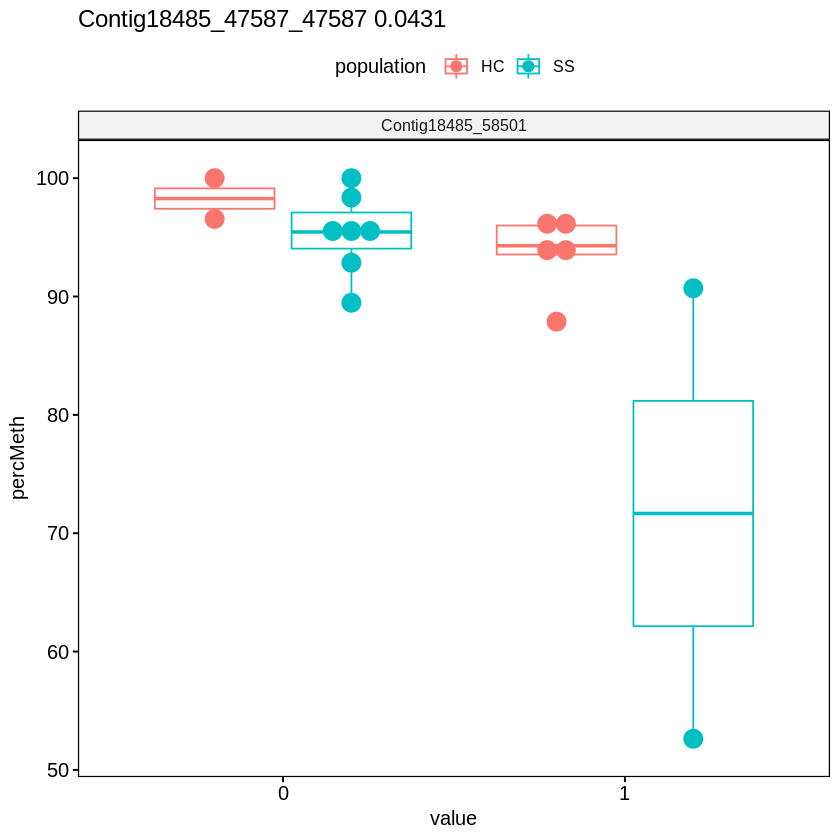

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



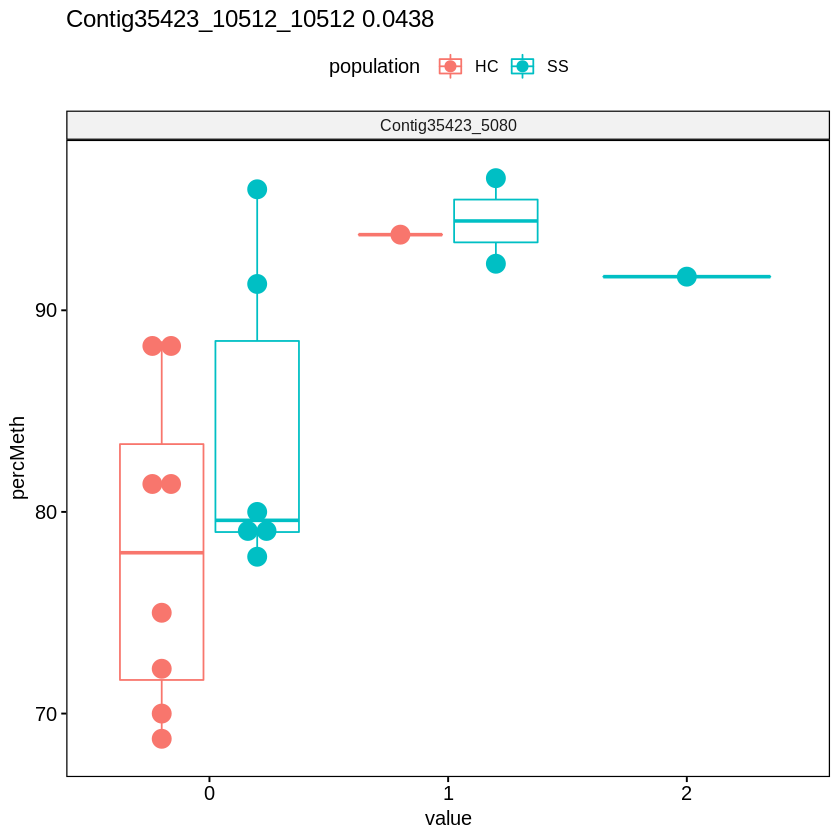

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


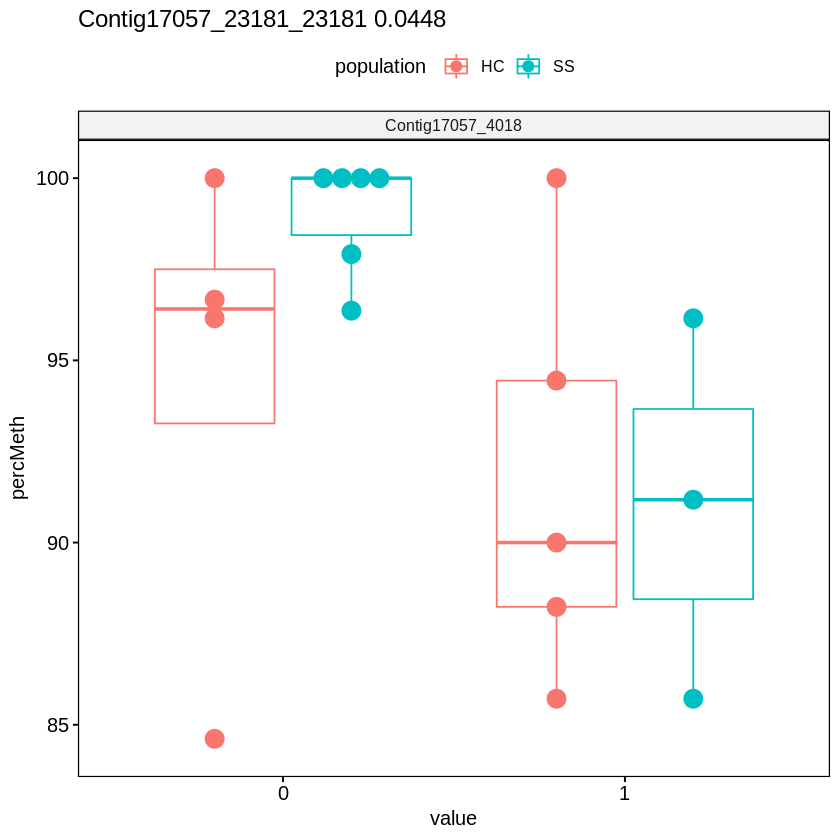

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


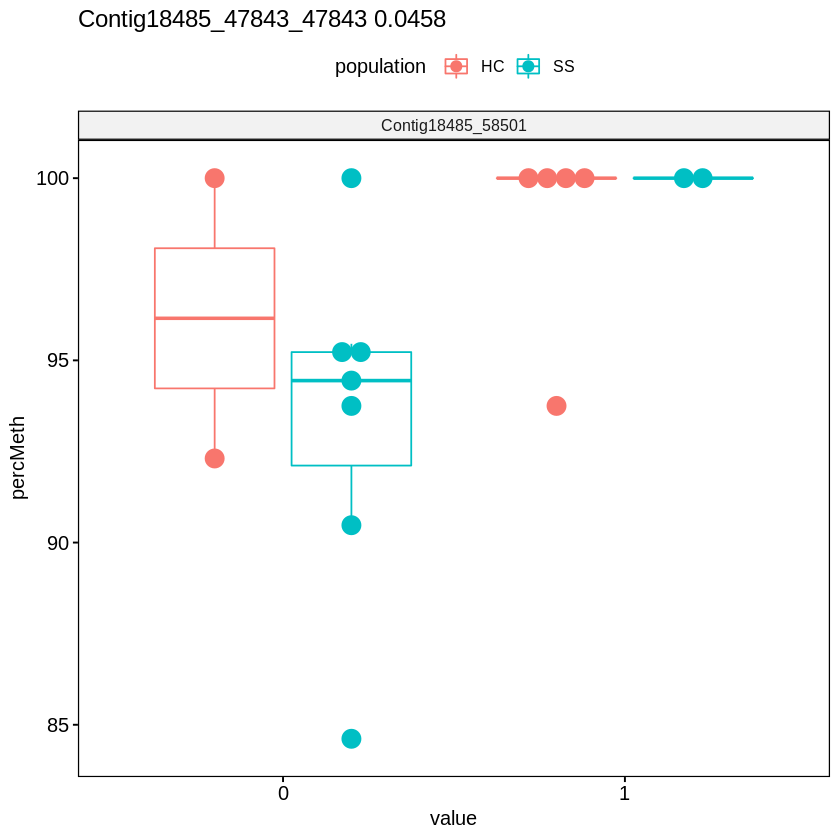

Warning message:
"Removed 3 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 3 rows containing non-finite values (stat_bindot)."


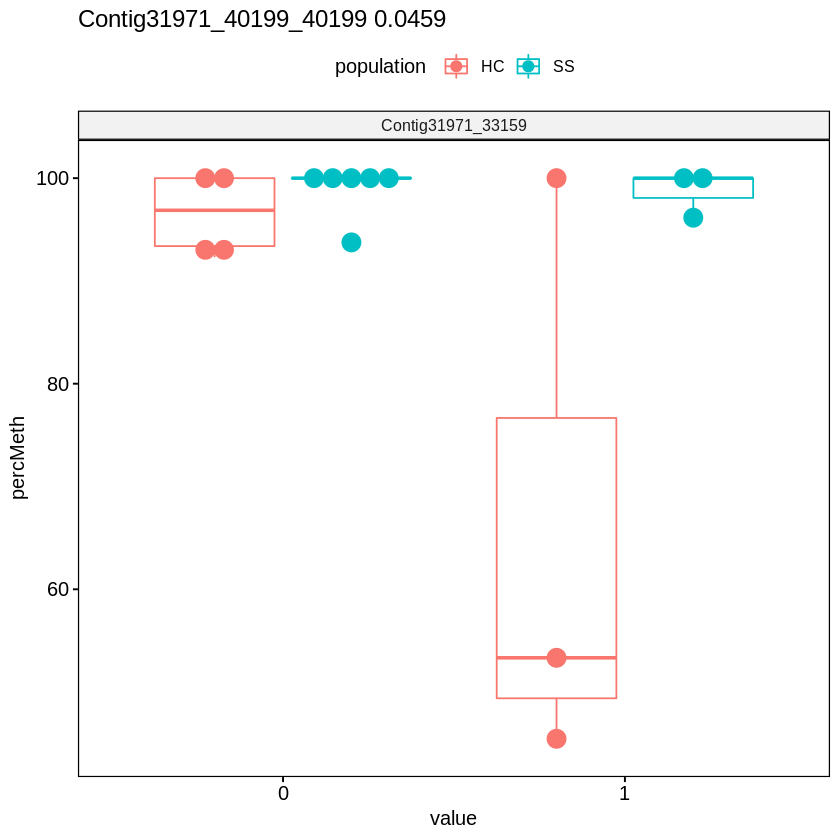

Warning message:
"Removed 1 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 1 rows containing non-finite values (stat_bindot)."


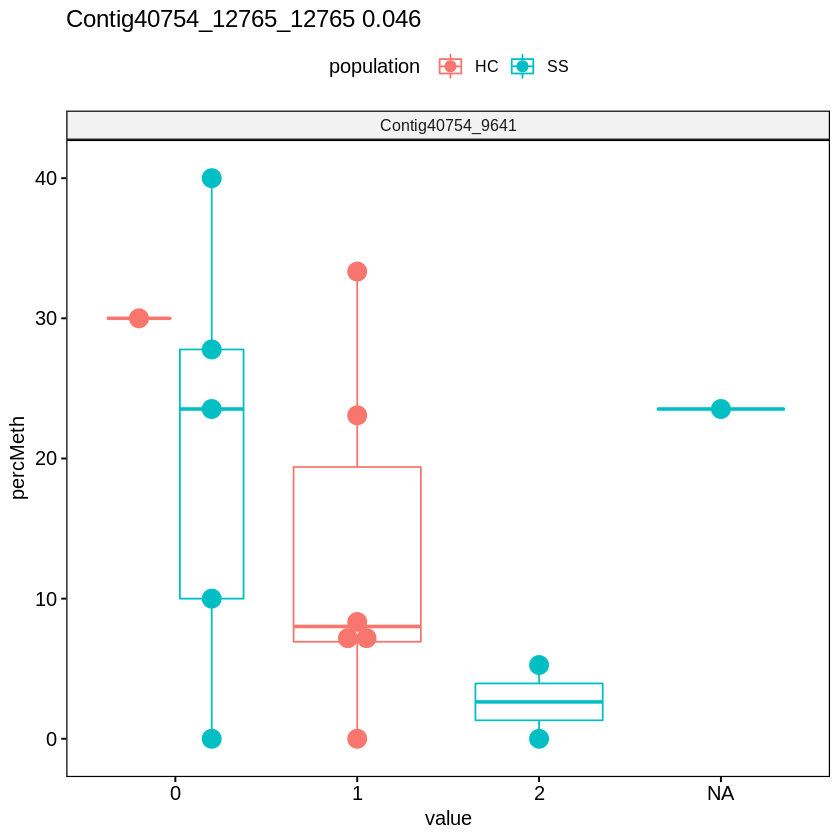

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



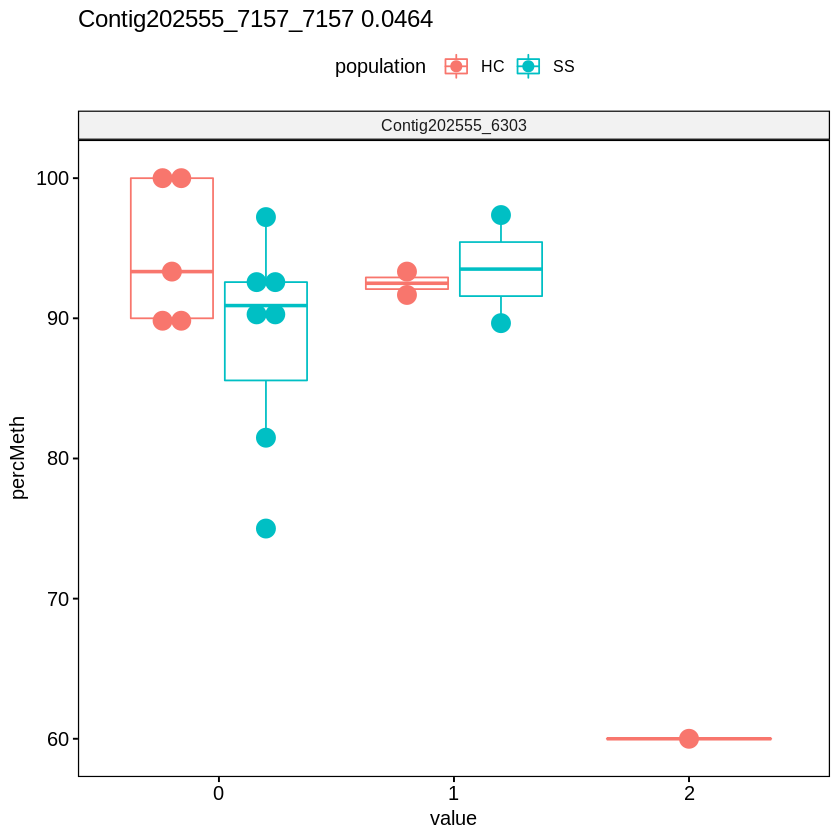

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


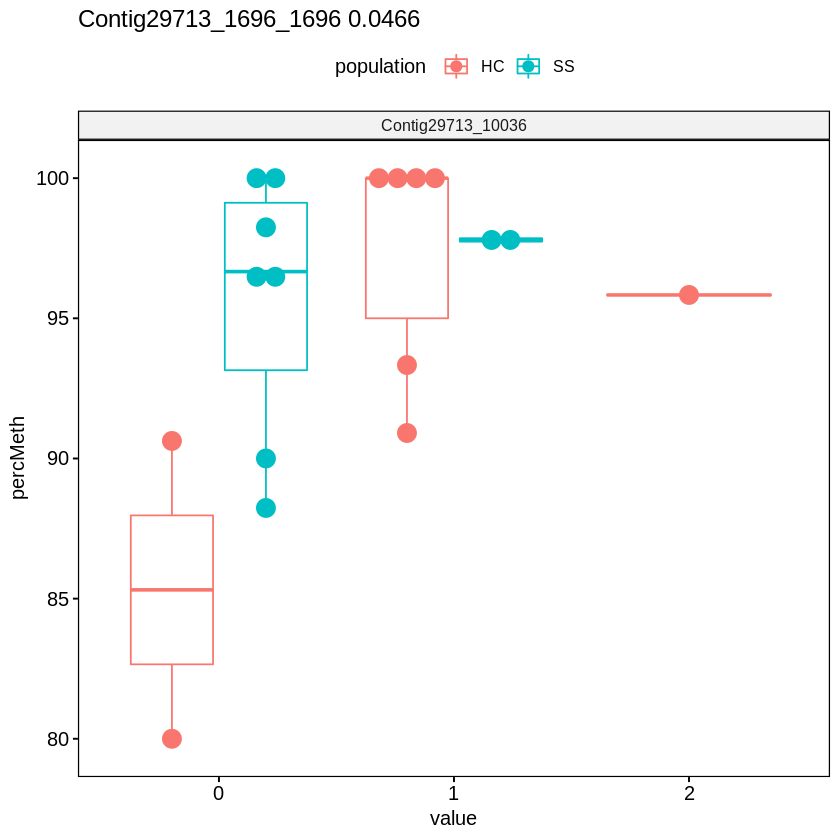

Warning message:
"Removed 2 rows containing non-finite values (stat_boxplot)."
`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
"Removed 2 rows containing non-finite values (stat_bindot)."


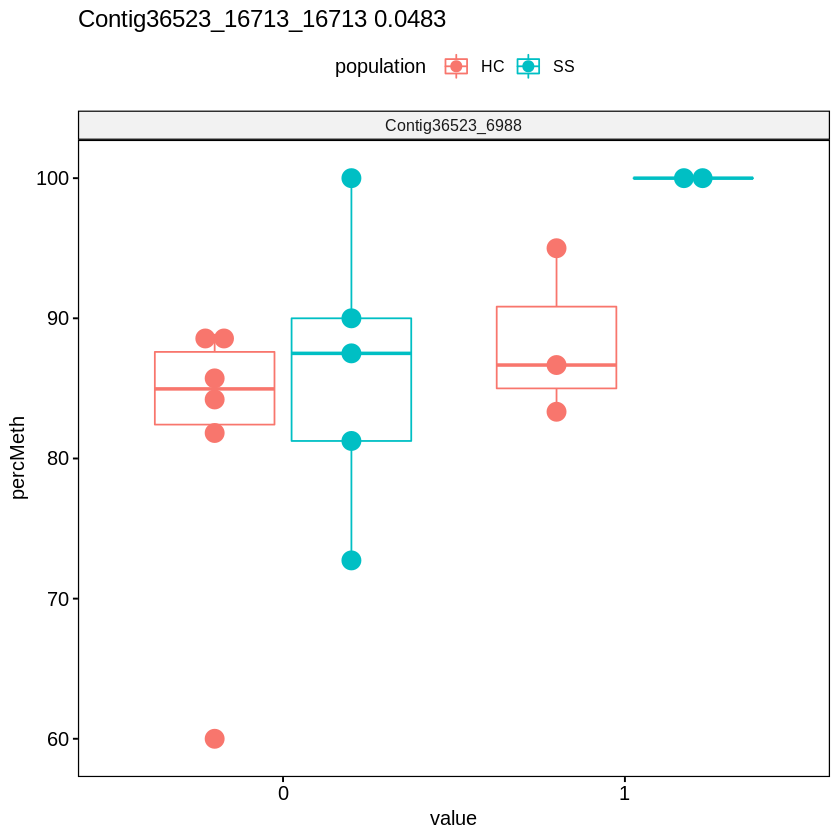

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



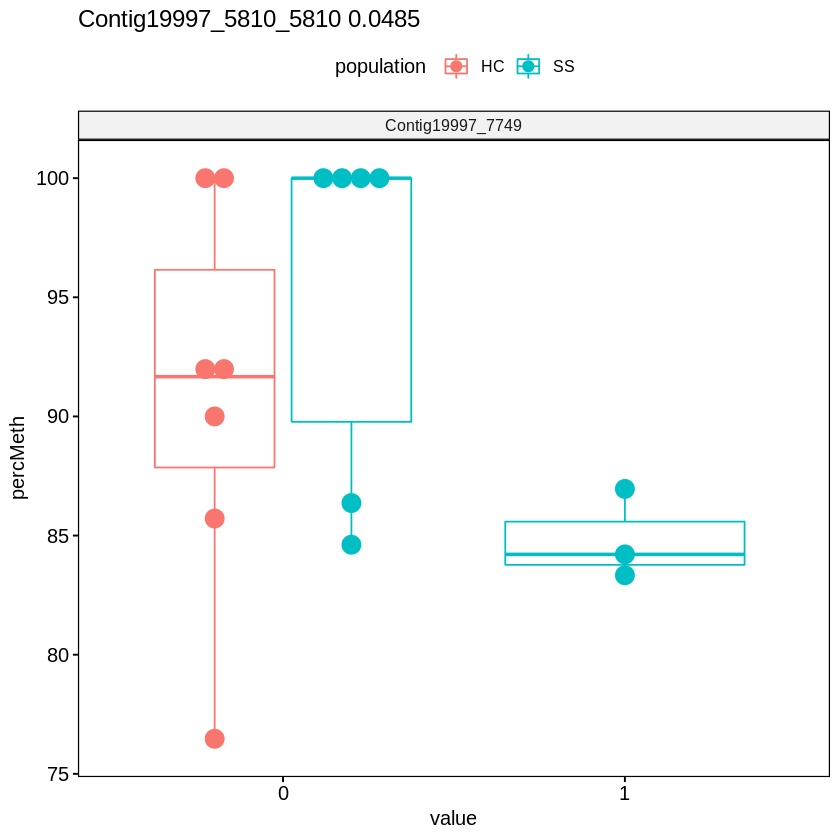

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



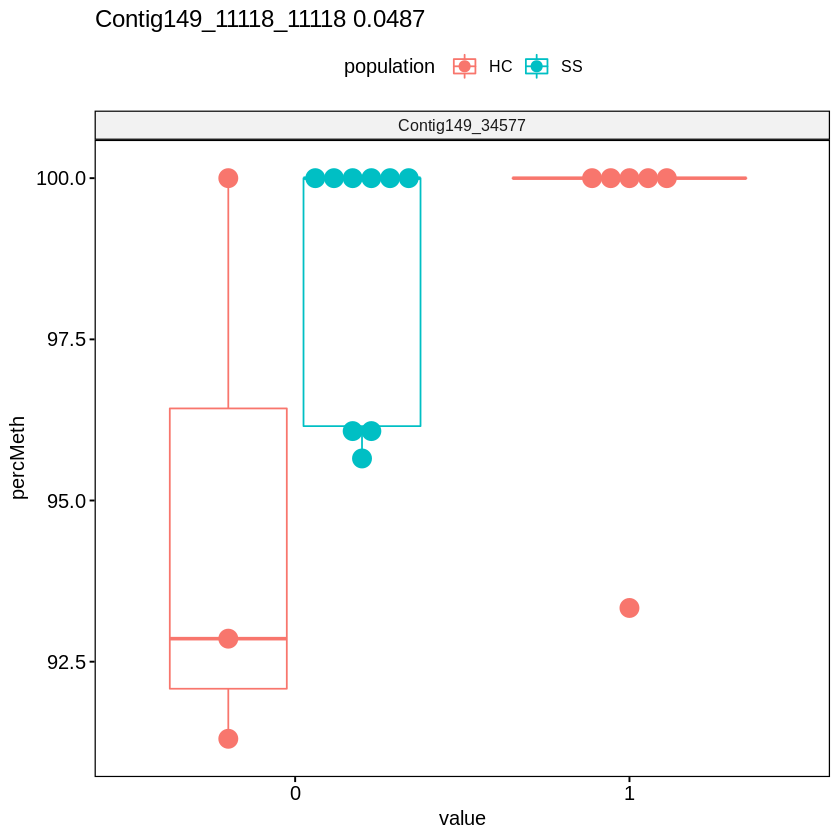

`stat_bindot()` using `bins = 30`. Pick better value with `binwidth`.



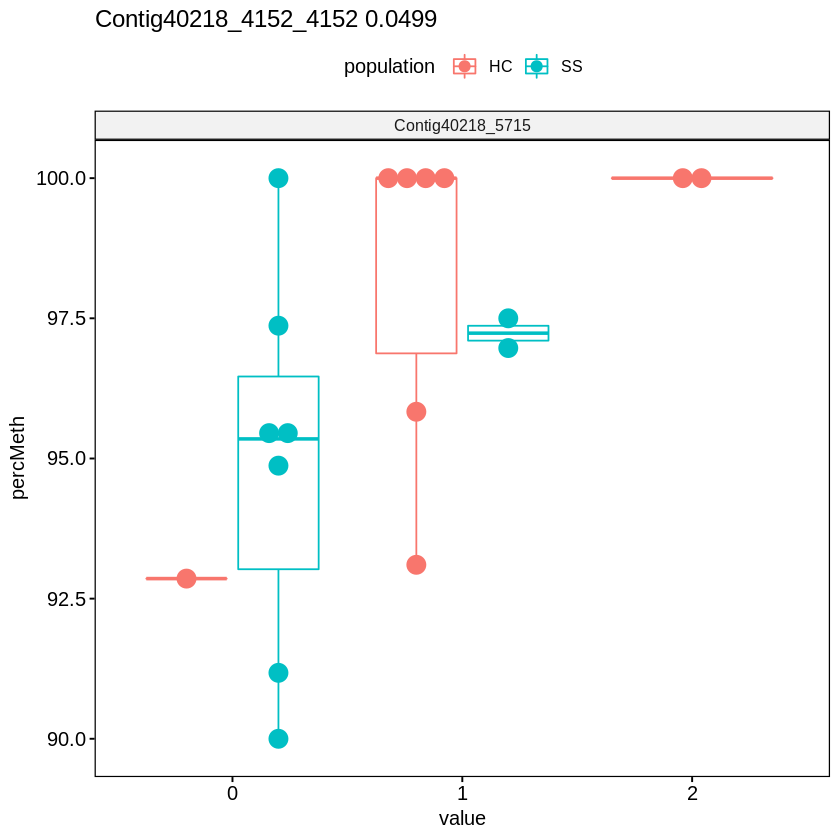

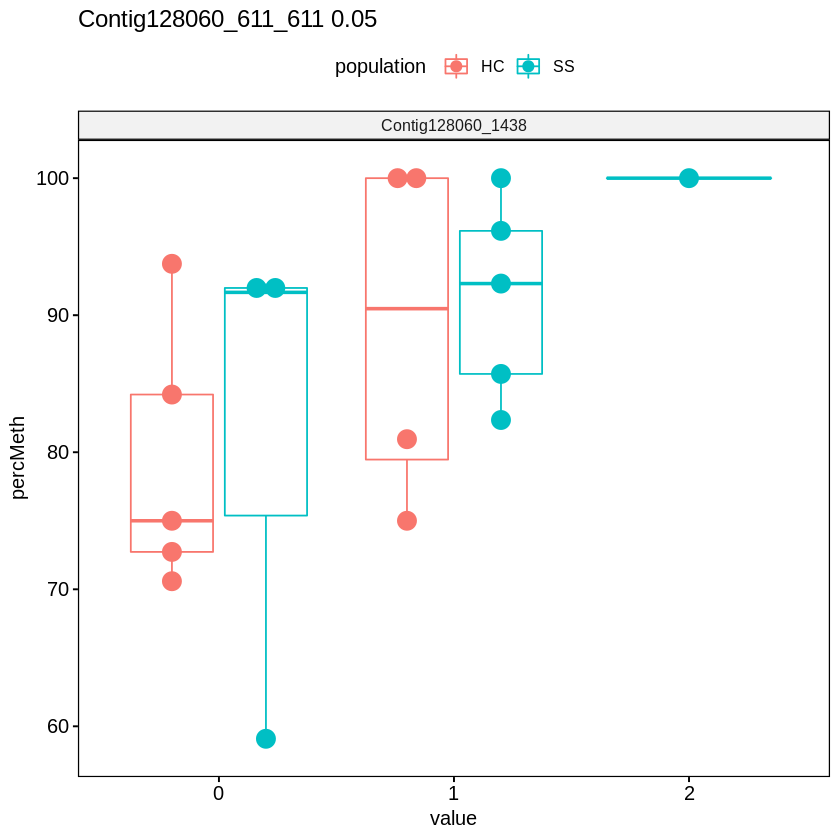

In [356]:
for(gene in unique(meS$cis$eqtls$gene)){
    m <- perc_meth %>% filter(site==gene)
s <- meS$cis$eqtls[which(meS$cis$eqtls$gene == gene),]$snps
    pval <- signif(mean_sigcis[which(mean_sigcis$gene == gene),"mean_pval"],digits=3)

g <- as.data.frame(t(geno[geno$id %in% s,]),stringsAsFactors = F)
colnames(g) <- g[1,]
g$sample <- rownames(g)
g <- g[-1,]
    
mer <- merge(m,g) %>% tidyr::gather("id","value",9:ncol(merge(m,g)))
mer$value <- as.numeric(mer$value)

plot <- mer %>%
ggboxplot(., x = "value", y= "percMeth",color="population", facet.by = c("id") , add ="dotplot") + 
    ggtitle(paste(gene,pval,sep=" "))
#stat_compare_means( method = "t.test",label="p.format") + ggtitle(gene)
print(plot)
}

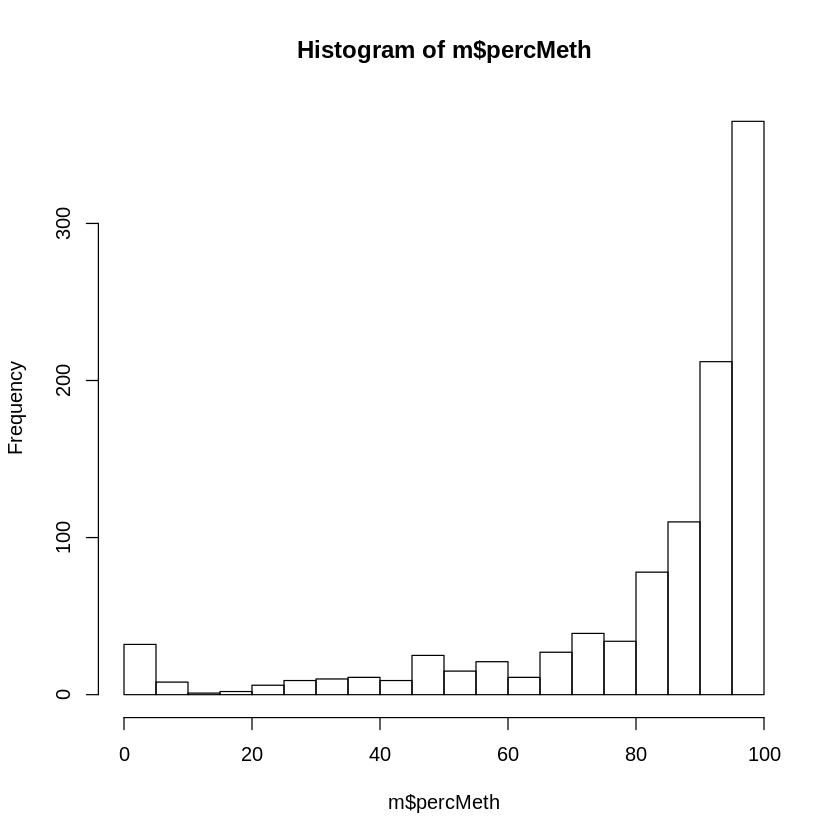

In [73]:
m <- perc_meth %>% filter(site %in% meS$cis$eqtls$gene & population %in% "HC")
hist(m$percMeth,breaks = 20)

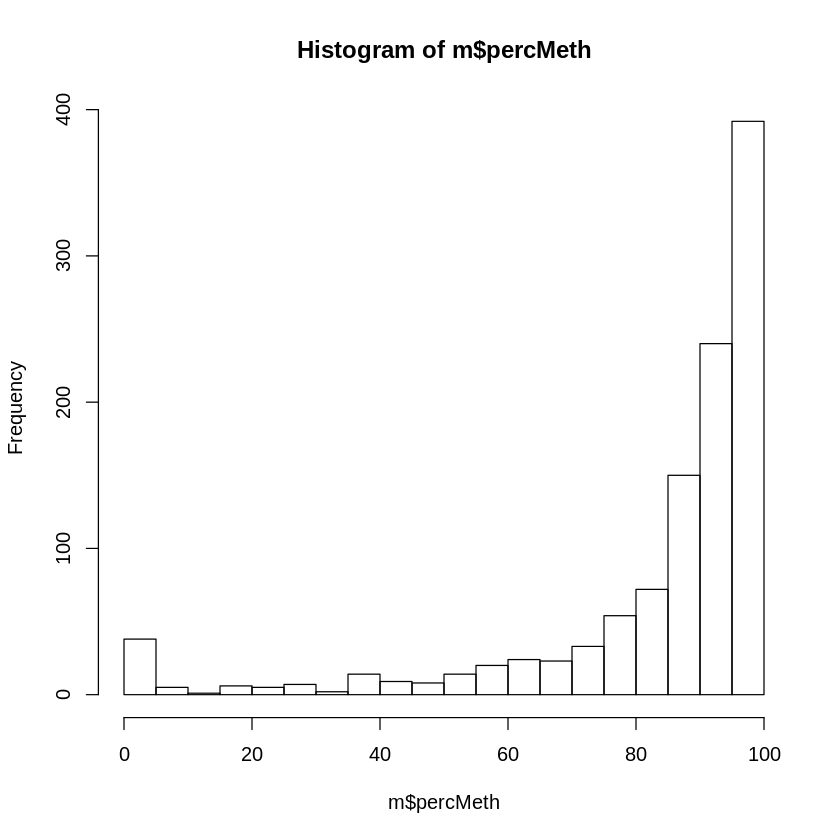

In [74]:
m <- perc_meth %>% filter(site %in% meS$cis$eqtls$gene & population %in% "SS")
hist(m$percMeth,breaks = 20)

## Enrichment

#### Make background and cis beds

Make bed file of all snps and all meth sites

In [75]:
module load gcc/6.2.0
module load bedtools/2.29.0

#### meth background

In [94]:
%expand
# meth background
dc <- as.data.frame(dc,stringsAsFactors = F)
chr = sapply(strsplit(dc$id,"_"), '[',1)
s1 = as.numeric(sapply(strsplit(dc$id,"_"), '[',2))
s2 = as.numeric(sapply(strsplit(dc$id,"_"), '[',3))
bed <- cbind(chr,s1,s2)
write.table(bed,"{mQTL}meth_allsites_mbd.bed",row.names = F, col.names = F,quote = F, sep = "\t")

In [108]:
%expand
bedtools intersect -wb -a "{mQTL}meth_allsites_mbd.bed" -b "{gf}/Olurida_v081-20190709.gene.gff" >  {mQTL}meth-background-gene.bed
bedtools intersect -wb -a "{mQTL}meth_allsites_mbd.bed" -b "{gf}/Olurida_v081-20190709.gene.2kbslop.gff" >  {mQTL}meth-background-gene2kb.bed
bedtools intersect -wb -a "{mQTL}meth_allsites_mbd.bed" -b "{gf}/Olurida_v081-20190709.2kbflank-up.gff" >  {mQTL}meth-background-2kbflank-up.bed
bedtools intersect -wb -a "{mQTL}meth_allsites_mbd.bed" -b "{gf}/Olurida_v081-20190709.2kbflank-down.gff" >  {mQTL}meth-background-2kbflank-down.bed
bedtools intersect -wb -a "{mQTL}meth_allsites_mbd.bed" -b "{gf}/Olurida_v081-20190709.exon.gff" >  {mQTL}meth-background-exon.bed
bedtools intersect -wb -a "{mQTL}meth_allsites_mbd.bed" -b "{gf}/Olurida_v081-20190709.CDS.gff" >  {mQTL}meth-background-CDS.bed
bedtools intersect -wb -a "{mQTL}meth_allsites_mbd.bed" -b "{gf}/Olurida_v081-20190709.mRNA.gff" >  {mQTL}meth-background-mRNA.bed
bedtools intersect -wb -a "{mQTL}meth_allsites_mbd.bed" -b "{gf}/Olurida_v081_TE-Cg.gff" >  {mQTL}meth-background-TE.bed
bedtools intersect -v -a "{mQTL}meth_allsites_mbd.bed" -b "{gf}/Olurida_v081-20190709.gene.2kbslop.gff" "{gf}/Olurida_v081-20190709.exon.gff" "{gf}/Olurida_v081-20190709.CDS.gff" "{gf}/Olurida_v081-20190709.mRNA.gff" "{gf}/Olurida_v081_TE-Cg.gff" >  {mQTL}meth-background-unknown.bed

In [109]:
%expand ${ }
cisfiles <- c("${mQTL}meth-background-CDS.bed", "${mQTL}meth-background-exon.bed", "${mQTL}meth-background-gene.bed", "${mQTL}meth-background-gene2kb.bed", "${mQTL}meth-background-2kbflank-up.bed", "${mQTL}meth-background-2kbflank-down.bed", "${mQTL}meth-background-mRNA.bed", "${mQTL}meth-background-TE.bed", "${mQTL}meth-background-unknown.bed")
cis.features <- list()
for (i in c(1:9)) {
  cis.features[[i]] <- read_delim(cisfiles[i], delim = '\t', col_names = FALSE) %>% as_tibble()}
for (i in 1:8) {
  cis.features[[i]] <- cis.features[[i]] %>%
    setNames(c("contig.cis","start.cis","end.cis","contig.feat", "source.feat","feature","start.feat","end.feat","unknown1","strand","unknown2","attribute")) %>%
mutate(ID=str_extract(attribute, "ID=(.*?);"),
       Parent=str_extract(attribute, "Parent=(.*?);"),
       Name=str_extract(attribute, "Name=(.*?);"),
       Alias=str_extract(attribute, "Alias=(.*?);"),
       AED=str_extract(attribute, "AED=(.*?);"),
       eAED=str_extract(attribute, "eAED=(.*?);"),
       Note=str_extract(attribute, "Note=(.*?);"),
       Ontology_term=str_extract(attribute, "Ontology_term=(.*?);"),
       Dbxref=str_extract(attribute, "Dbxref=(.*?);"),
       uniprotID=str_extract(attribute, "SPID=(.*?);")
       ) %>%
mutate_at("feature", as.factor)
}
names(cis.features) <- c("cis.CDS", "cis.exon", "cis.gene","cis.gene2kb", "cis.flank-up", "cis.flank-down","cis.mRNA", "cis.TE", "cis.unknown")
cis.features[["cis.unknown"]] <- 
  cis.features[["cis.unknown"]] %>% 
  setNames(c("contig.cis", "start.cis", "end.cis", "score.cis"))
cis.features[["cis.CDS"]] <- cis.features[["cis.CDS"]] %>% mutate_at("unknown2", as.character)
cis.features[["cis.TE"]] <- cis.features[["cis.TE"]] %>% mutate_at("unknown1", as.character)
cis.features[["cis.gene2kb"]]$feature <- "gene2kb"
cis.features[["cis.flank-up"]]$feature <- "flank-up"
cis.features[["cis.flank-down"]]$feature <- "flank-down"
cis.features[["cis.unknown"]]$feature <- "unknown"
cis.features.df <- bind_rows(cis.features) 
#save cis loci feature df object to file, to use in notebook #12 
save(cis.features.df, file="${mQTL}meth-background.features.df")

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_double(),
  X12 = col_character()
)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character()
)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character()
)

Parsed with column specification:
cols(


In [110]:
%expand
cis.summary <- table(cis.features.df[c("feature")]) #Note: "similarity" refers to transposable elements; also NO alternative splice variants are included. 
print(cis.summary)
save(cis.summary, file="{mQTL}meth-background_feature.summary")
print(round(table(cis.features.df[c("feature")])/33738,2))


       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
     15322      15943       1202       1184      18688      21073      18688 
similarity    unknown 
      1588      13072 

       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
      0.45       0.47       0.04       0.04       0.55       0.62       0.55 
similarity    unknown 
      0.05       0.39 


In [111]:
%expand
cis.features[["cis.gene2kb"]] %>%
   mutate(uniprotID=str_remove(uniprotID, "SPID=")) %>% mutate(uniprotID=str_remove(uniprotID, ";")) %>%
  select(uniprotID) %>% na.omit() %>% as.vector() %>% unique() %>% write.table(file="{mQTL}background_meth_genes2kb_uniprot.txt",quote = F,row.names = F,col.names = F)

In [119]:
%expand
# how many background meth sites in genes
cat {mQTL}meth-background-gene.bed \
| cut  -f1,2 | sort | uniq | wc -l

18097


In [120]:
%expand
# how many genes with background meth sites
cat {mQTL}meth-background-gene.bed \
| cut  -f4,7,8 | sort | uniq | wc -l

3304


In [81]:
# get sig meth sites
sig_meth_cis <- as.character(unique(meS$cis$eqtls$gene))

In [82]:
length(sig_meth_cis)

[1] 131

In [83]:
%expand
chr <- sapply(strsplit(sig_meth_cis,"_"), `[`, 1)
start <- sapply(strsplit(sig_meth_cis,"_"), `[`, 2)
end <- start
bed <- cbind(chr,start,end)
write.table(bed,"{mQTL}meth_mbd_maf05_sites_cis.bed",row.names = F, col.names = F,quote = F, sep = "\t")

### Identify cis meth sites in each feature with Bedtools

In [84]:
gf="../genome-features"

In [85]:
%expand
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.gene.gff" >  {mQTL}cis-meth-gene.bed
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.gene.2kbslop.gff" >  {mQTL}cis-meth-gene2kb.bed
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.2kbflank-up.gff" >  {mQTL}cis-meth-2kbflank-up.bed
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.2kbflank-down.gff" >  {mQTL}cis-meth-2kbflank-down.bed
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.exon.gff" >  {mQTL}cis-meth-exon.bed
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.CDS.gff" >  {mQTL}cis-meth-CDS.bed
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.mRNA.gff" >  {mQTL}cis-meth-mRNA.bed
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081_TE-Cg.gff" >  {mQTL}cis-meth-TE.bed
bedtools intersect -v -a "{mQTL}meth_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.gene.2kbslop.gff" "{gf}/Olurida_v081-20190709.exon.gff" "{gf}/Olurida_v081-20190709.CDS.gff" "{gf}/Olurida_v081-20190709.mRNA.gff" "{gf}/Olurida_v081_TE-Cg.gff" >  {mQTL}cis-meth-unknown.bed

In [133]:
%expand ${ }
cisfiles <- c("${mQTL}cis-meth-CDS.bed", "${mQTL}cis-meth-exon.bed", "${mQTL}cis-meth-gene.bed", "${mQTL}cis-meth-gene2kb.bed", "${mQTL}cis-meth-2kbflank-up.bed", "${mQTL}cis-meth-2kbflank-down.bed", "${mQTL}cis-meth-mRNA.bed", "${mQTL}cis-meth-TE.bed", "${mQTL}cis-meth-unknown.bed")
cis.features <- list()
for (i in c(1:9)) {
  cis.features[[i]] <- read_delim(cisfiles[i], delim = '\t', col_names = FALSE) %>% as_tibble()}
for (i in 1:8) {
  cis.features[[i]] <- cis.features[[i]] %>%
    setNames(c("contig.cis","start.cis","end.cis","contig.feat", "source.feat","feature","start.feat","end.feat","unknown1","strand","unknown2","attribute")) %>%
mutate(ID=str_extract(attribute, "ID=(.*?);"),
       Parent=str_extract(attribute, "Parent=(.*?);"),
       Name=str_extract(attribute, "Name=(.*?);"),
       Alias=str_extract(attribute, "Alias=(.*?);"),
       AED=str_extract(attribute, "AED=(.*?);"),
       eAED=str_extract(attribute, "eAED=(.*?);"),
       Note=str_extract(attribute, "Note=(.*?);"),
       Ontology_term=str_extract(attribute, "Ontology_term=(.*?);"),
       Dbxref=str_extract(attribute, "Dbxref=(.*?);"),
       uniprotID=str_extract(attribute, "SPID=(.*?);")
       ) %>%
mutate_at("feature", as.factor)
}
names(cis.features) <- c("cis.CDS", "cis.exon", "cis.gene","cis.gene2kb", "cis.flank-up", "cis.flank-down","cis.mRNA", "cis.TE", "cis.unknown")
cis.features[["cis.unknown"]] <- 
  cis.features[["cis.unknown"]] %>% 
  setNames(c("contig.cis", "start.cis", "end.cis", "score.cis"))
cis.features[["cis.CDS"]] <- cis.features[["cis.CDS"]] %>% mutate_at("unknown2", as.character)
cis.features[["cis.TE"]] <- cis.features[["cis.TE"]] %>% mutate_at("unknown1", as.character)
cis.features[["cis.gene2kb"]]$feature <- "gene2kb"
cis.features[["cis.flank-up"]]$feature <- "flank-up"
cis.features[["cis.flank-down"]]$feature <- "flank-down"
cis.features[["cis.unknown"]]$feature <- "unknown"
cis.features.df <- bind_rows(cis.features) 
#save cis loci feature df object to file, to use in notebook #12 
save(cis.features.df, file="${mQTL}cis-meth.features.df")

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_double(),
  X12 = col_character()
)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character()
)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character()
)

Parsed with column specification:
cols(


In [134]:
%expand
cis.summary <- table(cis.features.df[c("feature")]) #Note: "similarity" refers to transposable elements; also NO alternative splice variants are included. 
print(cis.summary)
save(cis.summary, file="{mQTL}cis-meth_feature.summary")
print(round(table(cis.features.df[c("feature")])/131,2))


       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
        70         75          2          2         90         94         90 
similarity    unknown 
         4         40 

       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
      0.53       0.57       0.02       0.02       0.69       0.72       0.69 
similarity    unknown 
      0.03       0.31 


In [135]:
%expand
cis.features[["cis.gene2kb"]] %>%
  mutate(uniprotID=str_remove(uniprotID, "SPID=")) %>% mutate(uniprotID=str_remove(uniprotID, ";")) %>%
  select(uniprotID) %>% na.omit() %>% as.vector() %>% unique() %>% write.table(file="{mQTL}meqtl_cis-methP05_genes2kb_uniprot.txt",quote = F,row.names = F,col.names = F)  

In [93]:
unique(cis.features[["cis.gene2kb"]][,c("contig.cis","Note")])

contig.cis 
1   Contig24215
2   Contig24017
3   Contig54642
4   Contig41076
5   Contig31124
6   Contig37183
7   Contig43574
8   Contig19662
9   Contig22638
10  Contig25558
11  Contig52148
12  Contig822  
13  Contig75   
14  Contig25452
15  Contig16063
16  Contig18889
17  Contig17378
18  Contig25896
19  Contig60781
20  Contig33157
21  Contig18086
22  Contig43656
23  Contig34824
24  Contig3252 
25  Contig22083
26  Contig16263
27  Contig32566
28  Contig32566
29  Contig17057
30  Contig17057
... ...        
33  Contig77382
34  Contig38096
35  Contig82836
36  Contig20037
37  Contig28902
38  Contig40218
39  Contig37588
40  Contig37588
41  Contig0    
42  Contig61494
43  Contig50657
44  Contig19997
45  Contig52798
46  Contig18485
47  Contig15372
48  Contig25426
49  Contig21828
50  Contig17378
51  Contig47538
52  Contig17705
53  Contig24326
54  Contig1519 
55  Contig40754
56  Contig217  
57  Contig217  
58  Contig20866
59  Contig35423
60  Contig31971
61  Contig31971
62  Contig36523
    Note                                                                                                    
1   Note=Similar to alpha-Spec: Spectrin alpha chain (Drosophila melanogaster OX%3D7227);                   
2   Note=Similar to ZUP1: Zinc finger-containing ubiquitin peptidase 1 (Macaca fascicularis OX%3D9541);     
3   Note=Similar to ANK1: Ankyrin-1 (Homo sapiens OX%3D9606);                                               
4   Note=Protein of unknown function;                                                                       
5   Note=Similar to Chdh: Choline dehydrogenase%2C mitochondrial (Mus musculus OX%3D10090);                 
6   Note=Protein of unknown function;                                                                       
7   Note=Protein of unknown function;                                                                       
8   Note=Similar to TCF7: Transcription factor 7 (Homo sapiens OX%3D9606);                                  
9   Note=Protein of unknown function;                                                                       
10  Note=Similar to PP2D1: Protein phosphatase 2C-like domain-containing protein 1 (Homo sapiens OX%3D9606);
11  Note=Similar to TRIM2: Tripartite motif-containing protein 2 (Bos taurus OX%3D9913);                    
12  Note=Similar to DUSP16: Dual specificity protein phosphatase 16 (Homo sapiens OX%3D9606);               
13  Note=Similar to TOE1: Target of EGR1 protein 1 (Homo sapiens OX%3D9606);                                
14  Note=Similar to SDR16C5: Epidermal retinol dehydrogenase 2 (Homo sapiens OX%3D9606);                    
15  Note=Similar to RAPGEF2: Rap guanine nucleotide exchange factor 2 (Canis lupus familiaris OX%3D9615);   
16  Note=Similar to C12orf56: Uncharacterized protein C12orf56 (Homo sapiens OX%3D9606);                    
17  Note=Similar to Znf329: Zinc finger protein 329 (Mus musculus OX%3D10090);                              
18  Note=Similar to EFCAB8: EF-hand calcium-binding domain-containing protein 8 (Homo sapiens OX%3D9606);   
19  Note=Protein of unknown function;                                                                       
20  Note=Similar to THG1L: Probable tRNA(His) guanylyltransferase (Bos taurus OX%3D9913);                   
21  Note=Similar to PRICKLE2: Prickle-like protein 2 (Homo sapiens OX%3D9606);                              
22  Note=Similar to MPDU1: Mannose-P-dolichol utilization defect 1 protein (Homo sapiens OX%3D9606);        
23  Note=Similar to Hspa12b: Heat shock 70 kDa protein 12B (Mus musculus OX%3D10090);                       
24  Note=Protein of unknown function;                                                                       
25  Note=Protein of unknown function;                                                                       
26  Note=Protein of unknown function;                                                                       
27  Note=Protein of unknown function;                                

## Cis-meth DAVID results  
42 david ids  
zing finger region:C2H2 types , CC nucleoplasm, BP : ox-reduct

### Identify cis snps in each feature with Bedtools

In [100]:
# get sig meth sites
sig_snp_cis <- as.character(unique(meS$cis$eqtls$snps))

In [102]:
length(sig_snp_cis)

[1] 104

In [103]:
%expand
chr <- sapply(strsplit(sig_snp_cis,"_"), `[`, 1)
start <- sapply(strsplit(sig_snp_cis,"_"), `[`, 2)
end <- start
bed <- cbind(chr,start,end)
write.table(bed,"{mQTL}snp_mbd_maf05_sites_cis.bed",row.names = F, col.names = F,quote = F, sep = "\t")

In [104]:
%expand
bedtools intersect -wb -a "{mQTL}snp_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.gene.gff" >  {mQTL}cis-snp-gene.bed
bedtools intersect -wb -a "{mQTL}snp_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.gene.2kbslop.gff" >  {mQTL}cis-snp-gene2kb.bed
bedtools intersect -wb -a "{mQTL}snp_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.2kbflank-up.gff" >  {mQTL}cis-snp-2kbflank-up.bed
bedtools intersect -wb -a "{mQTL}snp_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.2kbflank-down.gff" >  {mQTL}cis-snp-2kbflank-down.bed
bedtools intersect -wb -a "{mQTL}snp_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.exon.gff" >  {mQTL}cis-snp-exon.bed
bedtools intersect -wb -a "{mQTL}snp_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.CDS.gff" >  {mQTL}cis-snp-CDS.bed
bedtools intersect -wb -a "{mQTL}snp_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.mRNA.gff" >  {mQTL}cis-snp-mRNA.bed
bedtools intersect -wb -a "{mQTL}snp_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081_TE-Cg.gff" >  {mQTL}cis-snp-TE.bed
bedtools intersect -v -a "{mQTL}snp_mbd_maf05_sites_cis.bed" -b "{gf}/Olurida_v081-20190709.gene.2kbslop.gff" "{gf}/Olurida_v081-20190709.exon.gff" "{gf}/Olurida_v081-20190709.CDS.gff" "{gf}/Olurida_v081-20190709.mRNA.gff" "{gf}/Olurida_v081_TE-Cg.gff" >  {mQTL}cis-snp-unknown.bed

In [136]:
%expand ${ }
cisfiles <- c("${mQTL}cis-snp-CDS.bed", "${mQTL}cis-snp-exon.bed", "${mQTL}cis-snp-gene.bed", "${mQTL}cis-snp-gene2kb.bed", "${mQTL}cis-snp-2kbflank-up.bed", "${mQTL}cis-snp-2kbflank-down.bed", "${mQTL}cis-snp-mRNA.bed", "${mQTL}cis-snp-TE.bed", "${mQTL}cis-snp-unknown.bed")
cis.features <- list()
for (i in c(1:9)) {
  cis.features[[i]] <- read_delim(cisfiles[i], delim = '\t', col_names = FALSE) %>% as_tibble()}
for (i in 1:8) {
  cis.features[[i]] <- cis.features[[i]] %>%
    setNames(c("contig.cis","start.cis","end.cis","contig.feat", "source.feat","feature","start.feat","end.feat","unknown1","strand","unknown2","attribute")) %>%
mutate(ID=str_extract(attribute, "ID=(.*?);"),
       Parent=str_extract(attribute, "Parent=(.*?);"),
       Name=str_extract(attribute, "Name=(.*?);"),
       Alias=str_extract(attribute, "Alias=(.*?);"),
       AED=str_extract(attribute, "AED=(.*?);"),
       eAED=str_extract(attribute, "eAED=(.*?);"),
       Note=str_extract(attribute, "Note=(.*?);"),
       Ontology_term=str_extract(attribute, "Ontology_term=(.*?);"),
       Dbxref=str_extract(attribute, "Dbxref=(.*?);"),
       uniprotID=str_extract(attribute, "SPID=(.*?);")
       ) %>%
mutate_at("feature", as.factor)
}
names(cis.features) <- c("cis.CDS", "cis.exon", "cis.gene","cis.gene2kb", "cis.flank-up", "cis.flank-down","cis.mRNA", "cis.TE", "cis.unknown")
cis.features[["cis.unknown"]] <- 
  cis.features[["cis.unknown"]] %>% 
  setNames(c("contig.cis", "start.cis", "end.cis", "score.cis"))
cis.features[["cis.CDS"]] <- cis.features[["cis.CDS"]] %>% mutate_at("unknown2", as.character)
cis.features[["cis.TE"]] <- cis.features[["cis.TE"]] %>% mutate_at("unknown1", as.character)
cis.features[["cis.gene2kb"]]$feature <- "gene2kb"
cis.features[["cis.flank-up"]]$feature <- "flank-up"
cis.features[["cis.flank-down"]]$feature <- "flank-down"
cis.features[["cis.unknown"]]$feature <- "unknown"
cis.features.df <- bind_rows(cis.features) 
#save cis loci feature df object to file, to use in notebook #12 
save(cis.features.df, file="${mQTL}cis-snp.features.df")

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_double(),
  X12 = col_character()
)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character()
)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character()
)

Parsed with column specification:
cols(


In [137]:
%expand
cis.summary <- table(cis.features.df[c("feature")]) #Note: "similarity" refers to transposable elements; also NO alternative splice variants are included. 
print(cis.summary)
save(cis.summary, file="{mQTL}cis-snp_feature.summary")
print(round(table(cis.features.df[c("feature")])/104,2))


       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
         7         10         10         10         51         71         51 
similarity    unknown 
         5         37 

       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
      0.07       0.10       0.10       0.10       0.49       0.68       0.49 
similarity    unknown 
      0.05       0.36 


In [91]:
#FDR threshold
unique(cis.features.df[which(cis.features.df$contig.cis %in% c("Contig23519","Contig24215","Contig24017","Contig54642","Contig41076")),
                       c("contig.cis","start.cis","feature","Note")])

contig.cis  start.cis feature
1  Contig24215  1925     CDS    
2  Contig24017 15216     CDS    
3  Contig54642  8901     CDS    
4  Contig24215  1835     CDS    
5  Contig41076 12546     CDS    
6  Contig54642  8478     CDS    
7  Contig41076 12577     CDS    
8  Contig41076 13391     CDS    
9  Contig54642  8433     CDS    
10 Contig24017 15252     CDS    
11 Contig24215  1925     exon   
12 Contig24017 15216     exon   
13 Contig54642  8901     exon   
14 Contig24215  1835     exon   
15 Contig41076 12546     exon   
16 Contig54642  8478     exon   
17 Contig41076 12577     exon   
18 Contig41076 13391     exon   
19 Contig54642  8433     exon   
20 Contig24017 15252     exon   
21 Contig24215  1925     gene   
22 Contig24017 15216     gene   
23 Contig54642  8901     gene   
24 Contig24215  1835     gene   
25 Contig41076 12546     gene   
26 Contig54642  8478     gene   
27 Contig41076 12577     gene   
28 Contig41076 13391     gene   
29 Contig54642  8433     gene   
30 Contig24017 15252     gene   
31 Contig24215  1925     gene2kb
32 Contig24017 15216     gene2kb
33 Contig54642  8901     gene2kb
34 Contig24215  1835     gene2kb
35 Contig41076 12546     gene2kb
36 Contig54642  8478     gene2kb
37 Contig41076 12577     gene2kb
38 Contig41076 13391     gene2kb
39 Contig54642  8433     gene2kb
40 Contig24017 15252     gene2kb
41 Contig24215  1925     mRNA   
42 Contig24017 15216     mRNA   
43 Contig54642  8901     mRNA   
44 Contig24215  1835     mRNA   
45 Contig41076 12546     mRNA   
46 Contig54642  8478     mRNA   
47 Contig41076 12577     mRNA   
48 Contig41076 13391     mRNA   
49 Contig54642  8433     mRNA   
50 Contig24017 15252     mRNA   
51 Contig23519  9293     unknown
   Note                                                                                               
1  NA                                                                                                 
2  NA                                                                                                 
3  NA                                                                                                 
4  NA                                                                                                 
5  NA                                                                                                 
6  NA                                                                                                 
7  NA                                                                                                 
8  NA                                                                                                 
9  NA                                                                                                 
10 NA                                                                                                 
11 NA                                                                                                 
12 NA                                                                                                 
13 NA                                                                                                 
14 NA                                                                                                 
15 NA                                                                                                 
16 NA                                                                                                 
17 NA                                                                                                 
18 NA                                                                                                 
19 NA                                                                                                 
20 NA                                                                                                 
21 Note=Similar to alpha-Spec: Spectrin alpha chain (Drosophila melanogaster OX%3D7227);              
22 Note=Similar to ZU

In [138]:
%expand
cis.features[["cis.gene2kb"]] %>%
  mutate(uniprotID=str_remove(uniprotID, "SPID=")) %>% mutate(uniprotID=str_remove(uniprotID, ";")) %>%
  select(uniprotID) %>% na.omit() %>% as.vector() %>% unique() %>% write.table(file="{mQTL}meqtl_cis-snpP05_genes2kb_uniprot.txt",quote = F,row.names = F,col.names = F)  

### Cis DAVID results  
37 genes,796  in background

BP: ubiquitin-dependent protein catabolic process  
Interpro: PDZ domains (binding motifs)  
lysine demethylase 3B, nuclear receptor coactivator6,  prickle2
CC: nucleoplasm

## Trans enrichment

In [59]:
module load gcc/6.2.0
module load bedtools/2.29.0

In [121]:
# get sig SNPs
sig_snp_trans <- as.character(unique(meS$trans$eqtls$snps[which(meS$trans$eqtls$FDR <0.05)]))

In [122]:
length(sig_snp_trans)

[1] 1632

In [123]:
%expand
chr <- sapply(strsplit(sig_snp_trans,"_"), `[`, 1)
start <- sapply(strsplit(sig_snp_trans,"_"), `[`, 2)
end <- start
bed <- cbind(chr,start,end)
write.table(bed,"{mQTL}snps_mbd_maf05_sites_transF05.bed",row.names = F, col.names = F,quote = F, sep = "\t")

### Identify trans snps in each feature with Bedtools

In [127]:
%expand
bedtools intersect -wb -a "{mQTL}snps_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.gene.gff" >  {mQTL}transF05-snp-gene.bed
bedtools intersect -wb -a "{mQTL}snps_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.gene.2kbslop.gff" >  {mQTL}transF05-snp-gene2kb.bed
bedtools intersect -wb -a "{mQTL}snps_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.2kbflank-up.gff" >  {mQTL}transF05-snp-2kbflank-up.bed
bedtools intersect -wb -a "{mQTL}snps_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.2kbflank-down.gff" >  {mQTL}transF05-snp-2kbflank-down.bed
bedtools intersect -wb -a "{mQTL}snps_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.exon.gff" >  {mQTL}transF05-snp-exon.bed
bedtools intersect -wb -a "{mQTL}snps_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.CDS.gff" >  {mQTL}transF05-snp-CDS.bed
bedtools intersect -wb -a "{mQTL}snps_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.mRNA.gff" >  {mQTL}transF05-snp-mRNA.bed
bedtools intersect -wb -a "{mQTL}snps_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081_TE-Cg.gff" >  {mQTL}transF05-snp-TE.bed
bedtools intersect -v -a "{mQTL}snps_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.gene.2kbslop.gff" "{gf}/Olurida_v081-20190709.exon.gff" "{gf}/Olurida_v081-20190709.CDS.gff" "{gf}/Olurida_v081-20190709.mRNA.gff" "{gf}/Olurida_v081_TE-Cg.gff" >  {mQTL}transF05-snp-unknown.bed

In [128]:
%expand ${ }
trans01files <- c("${mQTL}transF05-snp-CDS.bed", "${mQTL}transF05-snp-exon.bed", "${mQTL}transF05-snp-gene.bed", "${mQTL}transF05-snp-gene2kb.bed", "${mQTL}transF05-snp-2kbflank-up.bed", "${mQTL}transF05-snp-2kbflank-down.bed", "${mQTL}transF05-snp-mRNA.bed", "${mQTL}transF05-snp-TE.bed", "${mQTL}transF05-snp-unknown.bed")
trans01.features <- list()
for (i in c(1:9)) {
  trans01.features[[i]] <- read_delim(trans01files[i], delim = '\t', col_names = FALSE) %>% as_tibble()}
for (i in 1:8) {
  trans01.features[[i]] <- trans01.features[[i]] %>%
    setNames(c("contig.trans01","start.trans01","end.trans01","contig.feat", "source.feat","feature","start.feat","end.feat","unknown1","strand","unknown2","attribute")) %>%
mutate(ID=str_extract(attribute, "ID=(.*?);"),
       Parent=str_extract(attribute, "Parent=(.*?);"),
       Name=str_extract(attribute, "Name=(.*?);"),
       Alias=str_extract(attribute, "Alias=(.*?);"),
       AED=str_extract(attribute, "AED=(.*?);"),
       eAED=str_extract(attribute, "eAED=(.*?);"),
       Note=str_extract(attribute, "Note=(.*?);"),
       Ontology_term=str_extract(attribute, "Ontology_term=(.*?);"),
       Dbxref=str_extract(attribute, "Dbxref=(.*?);"),
       uniprotID=str_extract(attribute, "SPID=(.*?);")
       ) %>%
mutate_at("feature", as.factor)
}
names(trans01.features) <- c("trans01.CDS", "trans01.exon", "trans01.gene","trans01.gene2kb", "trans01.flank-up", "trans01.flank-down","trans01.mRNA", "trans01.TE", "trans01.unknown")
trans01.features[["trans01.unknown"]] <- 
  trans01.features[["trans01.unknown"]] %>% 
  setNames(c("contig.trans01", "start.trans01", "end.trans01", "score.trans01"))
trans01.features[["trans01.CDS"]] <- trans01.features[["trans01.CDS"]] %>% mutate_at("unknown2", as.character)
trans01.features[["trans01.TE"]] <- trans01.features[["trans01.TE"]] %>% mutate_at("unknown1", as.character)
trans01.features[["trans01.gene2kb"]]$feature <- "gene2kb"
trans01.features[["trans01.flank-up"]]$feature <- "flank-up"
trans01.features[["trans01.flank-down"]]$feature <- "flank-down"
trans01.features[["trans01.unknown"]]$feature <- "unknown"
trans01.features.df <- bind_rows(trans01.features) 
#trans01.features[[3]] %>% left_join(uniprot, by=c("contig.feat","start.feat", "end.feat")) 
#save trans01 loci feature df object to file, to use in notebook #12 
save(trans01.features.df, file="${mQTL}transF05_snp.features.df")

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_double(),
  X12 = col_character()
)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character()
)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character()
)

Parsed with column specification:
cols(


In [130]:
%expand
print(trans01.summary <- table(trans01.features.df[c("feature")]))#Note: "similarity" refers to transposable elements; also NO alternative splice variants are included. 
print(round(table(trans01.features.df[c("feature")])/1632,2))
save(trans01.summary, file="{mQTL}transF05_snp_feature.summary")


       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
       101        119         63         75        449        587        449 
similarity    unknown 
       159        978 

       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
      0.06       0.07       0.04       0.05       0.28       0.36       0.28 
similarity    unknown 
      0.10       0.60 


In [131]:
%expand
trans01.features[["trans01.gene2kb"]] %>%
   mutate(uniprotID=str_remove(uniprotID, "SPID=")) %>% mutate(uniprotID=str_remove(uniprotID, ";")) %>%
  select(uniprotID) %>% na.omit() %>% as.vector() %>% unique() %>% write.table(file="{mQTL}transF05_snps_genes2kb_uniprot.txt",quote = F,row.names = F,col.names = F)

In [132]:
%expand
wc -l {mQTL}transF05_snps_genes2kb_uniprot.txt

279 ../analyses/2bRAD/mQTL/transF05_snps_genes2kb_uniprot.txt


### Trans DAVID results  
279 genes, 796 in background  

BP: DNA recombination  
UP keyword: Zinc, Metal-binding  
Up seq feature: glycosylation site:N-linked  
Interpro: EF-hand-like domain  
MF: metal ion binding  
BP: protein ubiquination

#### Enrichment of methylation sites with a trans snp

In [139]:
# get sig SNPs
sig_meth_trans <- as.character(unique(meS$trans$eqtls$gene[which(meS$trans$eqtls$FDR <0.05)]))

In [140]:
length(sig_meth_trans)

[1] 4936

In [141]:
%expand
chr <- sapply(strsplit(sig_meth_trans,"_"), `[`, 1)
start <- sapply(strsplit(sig_meth_trans,"_"), `[`, 2)
end <- start
bed <- cbind(chr,start,end)
write.table(bed,"{mQTL}meth_mbd_maf05_sites_transF05.bed",row.names = F, col.names = F,quote = F, sep = "\t")

### Identify trans meth sites in each feature with Bedtools

In [142]:
%expand
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.gene.gff" >  {mQTL}methtransF05-gene.bed
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.gene.2kbslop.gff" >  {mQTL}methtransF05-gene2kb.bed
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.2kbflank-up.gff" >  {mQTL}methtransF05-2kbflank-up.bed
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.2kbflank-down.gff" >  {mQTL}methtransF05-2kbflank-down.bed
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.exon.gff" >  {mQTL}methtransF05-exon.bed
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.CDS.gff" >  {mQTL}methtransF05-CDS.bed
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.mRNA.gff" >  {mQTL}methtransF05-mRNA.bed
bedtools intersect -wb -a "{mQTL}meth_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081_TE-Cg.gff" >  {mQTL}methtransF05-TE.bed
bedtools intersect -v -a "{mQTL}meth_mbd_maf05_sites_transF05.bed" -b "{gf}/Olurida_v081-20190709.gene.2kbslop.gff" "{gf}/Olurida_v081-20190709.exon.gff" "{gf}/Olurida_v081-20190709.CDS.gff" "{gf}/Olurida_v081-20190709.mRNA.gff" "{gf}/Olurida_v081_TE-Cg.gff" >  {mQTL}methtransF05-unknown.bed

In [143]:
%expand ${ }
trans01files <- c("${mQTL}methtransF05-CDS.bed", "${mQTL}methtransF05-exon.bed", "${mQTL}methtransF05-gene.bed", "${mQTL}methtransF05-gene2kb.bed", "${mQTL}methtransF05-2kbflank-up.bed", "${mQTL}methtransF05-2kbflank-down.bed", "${mQTL}methtransF05-mRNA.bed", "${mQTL}methtransF05-TE.bed", "${mQTL}methtransF05-unknown.bed")
methtrans01.features <- list()
for (i in c(1:9)) {
  methtrans01.features[[i]] <- read_delim(trans01files[i], delim = '\t', col_names = FALSE) %>% as_tibble()}
for (i in 1:8) {
  methtrans01.features[[i]] <- methtrans01.features[[i]] %>%
    setNames(c("contig.trans01","start.trans01","end.trans01","contig.feat", "source.feat","feature","start.feat","end.feat","unknown1","strand","unknown2","attribute")) %>%
mutate(ID=str_extract(attribute, "ID=(.*?);"),
       Parent=str_extract(attribute, "Parent=(.*?);"),
       Name=str_extract(attribute, "Name=(.*?);"),
       Alias=str_extract(attribute, "Alias=(.*?);"),
       AED=str_extract(attribute, "AED=(.*?);"),
       eAED=str_extract(attribute, "eAED=(.*?);"),
       Note=str_extract(attribute, "Note=(.*?);"),
       Ontology_term=str_extract(attribute, "Ontology_term=(.*?);"),
       Dbxref=str_extract(attribute, "Dbxref=(.*?);"),
       uniprotID=str_extract(attribute, "SPID=(.*?);")
       ) %>%
mutate_at("feature", as.factor)
}
names(methtrans01.features) <- c("trans01.CDS", "trans01.exon", "trans01.gene","trans01.gene2kb", "trans01.flank-up", "trans01.flank-down","trans01.mRNA", "trans01.TE", "trans01.unknown")
methtrans01.features[["trans01.unknown"]] <- 
  methtrans01.features[["trans01.unknown"]] %>% 
  setNames(c("contig.trans01", "start.trans01", "end.trans01", "score.trans01"))
methtrans01.features[["trans01.CDS"]] <- methtrans01.features[["trans01.CDS"]] %>% mutate_at("unknown2", as.character)
methtrans01.features[["trans01.TE"]] <- methtrans01.features[["trans01.TE"]] %>% mutate_at("unknown1", as.character)
methtrans01.features[["trans01.gene2kb"]]$feature <- "gene2kb"
methtrans01.features[["trans01.flank-up"]]$feature <- "flank-up"
methtrans01.features[["trans01.flank-down"]]$feature <- "flank-down"
methtrans01.features[["trans01.unknown"]]$feature <- "unknown"
methtrans01.features.df <- bind_rows(methtrans01.features) 
#methtrans01.features[[3]] %>% left_join(uniprot, by=c("contig.feat","start.feat", "end.feat")) 
#save trans01 loci feature df object to file, to use in notebook #12 
save(methtrans01.features.df, file="${mQTL}methtransF05.features.df")

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_double(),
  X12 = col_character()
)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character()
)

Parsed with column specification:
cols(
  X1 = col_character(),
  X2 = col_double(),
  X3 = col_double(),
  X4 = col_character(),
  X5 = col_character(),
  X6 = col_character(),
  X7 = col_double(),
  X8 = col_double(),
  X9 = col_character(),
  X10 = col_character(),
  X11 = col_character(),
  X12 = col_character()
)

Parsed with column specification:
cols(


In [144]:
%expand
print(methtrans01.summary <- table(methtrans01.features.df[c("feature")]))#Note: "similarity" refers to transposable elements; also NO alternative splice variants are included. 
print(round(table(methtrans01.features.df[c("feature")])/4936,2))
save(methtrans01.summary, file="{mQTL}methtransF05_feature.summary")


       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
      2558       2664        153        169       2972       3294       2972 
similarity    unknown 
       167       1768 

       CDS       exon flank-down   flank-up       gene    gene2kb       mRNA 
      0.52       0.54       0.03       0.03       0.60       0.67       0.60 
similarity    unknown 
      0.03       0.36 


In [145]:
%expand
methtrans01.features[["trans01.gene2kb"]] %>%
   mutate(uniprotID=str_remove(uniprotID, "SPID=")) %>% mutate(uniprotID=str_remove(uniprotID, ";")) %>%
  select(uniprotID) %>% na.omit() %>% as.vector() %>% unique() %>% write.table(file="{mQTL}methtransF05_genes2kb_uniprot.txt",quote = F,row.names = F,col.names = F)

In [146]:
%expand
wc -l {mQTL}methtransF05_genes2kb_uniprot.txt

1105 ../analyses/2bRAD/mQTL/methtransF05_genes2kb_uniprot.txt


### Trans meth DAVID results  
1105 genes, 2367 in background

Up keyword: alternative splicing, zinc-finger, nucleus, polymorphism,  
Interpro: Zinc finger C2H2  

21 BP (protein localization to plasma membrane, regulation of transcription  
7 CC  (nucleus)  
15 MF (nucleic acid binding and zinc-ion binding binding) 
RNA recognition motif, UBA domain  